# **An Explainable Multimodal Framework for Real-Time Bitcoin Forecasting.**

**By:** ***Dipesh Badal***

Human centered Artificial Intelligence (TU Dublin, Tallaght Campus)

**Supervisor:** Dr. Abdelsalam Busalim

**Co-supervisor and Indrustry Partner:** Mr. Donghyeok Lee (CeADAR)

**Date:** 2025/09/06 (Saturday)

# **Install Libraries**

## **Creating Technical Indicators only (BTC Price Dataset)**

In [ ]:
# This is only for Bitcoin Technical indicators creation
!pip uninstall pandas_ta -y
!pip uninstall numpy -y
!pip install numpy==1.26.4
!pip install pandas-ta

## **Modeling and Shap**

In [ ]:
!pip install tensorflow

In [ ]:
!pip install xgboost

In [ ]:
pip install scikit-optimize

In [ ]:
pip install shap

# **Common Cell**

These are the common cell's for importing libraries, mount google drive, define file paths.

## **Import Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_ta as ta # This is for only creating Technical indicators
import os
from dateutil.parser import parse

# Set some display options for better viewing
pd.set_option('display.max_columns', 50)
sns.set_style('whitegrid')

print("Libraries imported successfully!")

# A folder to save the analysis plots
EDA_PLOTS_FOLDER = "eda_plots"

Libraries imported successfully!


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import xgboost as xgb

## **Mount Google Drive**




In [ ]:
import shutil
shutil.rmtree('/content/drive', ignore_errors=True)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Define file paths**

In [ ]:
reddit_path = '/content/drive/MyDrive/Thesis/reddit.csv'

In [ ]:
btc_price_path = '/content/drive/MyDrive/Thesis/price.csv'

In [ ]:
btc_news_path = '/content/drive/MyDrive/Thesis/news.csv'

In [ ]:
onchain_path = '/content/drive/MyDrive/Thesis/onchain.csv'

In [ ]:
fear_greed_path = '/content/drive/MyDrive/Thesis/alternative_me_bitcoin_fear_greed_index.csv'

# **Individual Data cleaning and Pre-processing**

# **A. BTC Price Dataset (Binance)**:

## **Step 1: Initial Inspection**

1. Loaded the dataset `BTCUSDT_15m_merged.csv`.  
2. Viewed the general structure and column information using `.info()`.  
3. Displayed the first few rows with `.head()`.  
4. Generated summary statistics with `.describe()` to spot outliers or unusual ranges.  
5. Checked for missing values in each column using `.isna().sum()`.  
6. Counted unique values in all columns with `.nunique()` to detect inconsistencies.  
7. Verified the date range by converting `timestamp` to datetime and checking the minimum and maximum.  
8. Checked for duplicate rows using `.duplicated().sum()`.

**1. load the dataset**

In [ ]:
price_df = pd.read_csv(btc_price_path)

**2. View general structure and info**

In [ ]:
print("---- DataFrame Info ----")
print(price_df.info())

---- DataFrame Info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157562 entries, 0 to 157561
Data columns (total 12 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   timestamp               157562 non-null  int64  
 1   open                    157562 non-null  float64
 2   high                    157562 non-null  float64
 3   low                     157562 non-null  float64
 4   close                   157562 non-null  float64
 5   volume                  157562 non-null  float64
 6   close_time              157562 non-null  int64  
 7   quote_asset_volume      157562 non-null  float64
 8   num_trades              157562 non-null  int64  
 9   taker_buy_base_volume   157562 non-null  float64
 10  taker_buy_quote_volume  157562 non-null  float64
 11  ignore                  157562 non-null  int64  
dtypes: float64(8), int64(4)
memory usage: 14.4 MB
None


**3. Show first few rows**

In [ ]:
price_df.head()

,timestamp,open,high,low,close,volume,close_time,quote_asset_volume,num_trades,taker_buy_base_volume,taker_buy_quote_volume,ignore
0,1609459200000,28923.63,29017.50,28690.17,28752.80,840.077569,1609460099999,2.423972e+07,19318,393.704224,1.136006e+07,0
1,1609460100000,28752.80,28875.55,28720.91,28836.63,480.611179,1609460999999,1.384695e+07,13876,235.967978,6.798117e+06,0
2,1609461000000,28836.63,28943.87,28836.62,28930.11,471.134708,1609461899999,1.361619e+07,12234,307.966715,8.899807e+06,0
3,1609461900000,28930.11,29031.34,28889.99,28995.13,519.987989,1609462799999,1.506597e+07,12961,277.720321,8.045564e+06,0
4,1609462800000,28995.13,29385.00,28960.35,29382.59,1735.839005,1609463699999,5.068079e+07,32696,1152.696972,3.366289e+07,0


**4. Show summary statistics (detect weird outliers or unexpected ranges)**

In [ ]:
print("\n---- Describe ----")
print(price_df.describe(include='all'))


---- Describe ----
          timestamp           open           high            low  \
count  1.575620e+05  157562.000000  157562.000000  157562.000000   
mean   1.937629e+14   48475.737879   48575.359885   48373.387461   
std    5.456146e+14   24563.798073   24601.390252   24525.306790   
min    1.609459e+12   15648.230000   15712.000000   15476.000000   
25%    1.644969e+12   28337.305000   28386.402500   28289.787500   
50%    1.680425e+12   42789.915000   42868.070000   42710.000000   
75%    1.715876e+12   62820.000000   62946.000000   62704.345000   
max    1.751327e+15  111898.740000  111980.000000  111681.810000   

               close         volume    close_time  quote_asset_volume  \
count  157562.000000  157562.000000  1.575620e+05        1.575620e+05   
mean    48476.233495     843.439119  1.937630e+14        2.879969e+07   
std     24564.193290    1326.081874  5.456149e+14        3.404103e+07   
min     15649.520000       0.000000  1.609460e+12        0.000000e+00   
25

**5. Check for missing values per column**

In [ ]:
print("\n---- Missing Values ----")
print(price_df.isnull().sum())


---- Missing Values ----
timestamp                 0
open                      0
high                      0
low                       0
close                     0
volume                    0
close_time                0
quote_asset_volume        0
num_trades                0
taker_buy_base_volume     0
taker_buy_quote_volume    0
ignore                    0
dtype: int64


**6. Check unique value counts for all columns (detect categorical/numeric mix-ups)**

In [ ]:
print("\n---- Unique Values ----")
for col in price_df.columns:
    print(f"{col}: {price_df[col].nunique()} unique")


---- Unique Values ----
timestamp: 157562 unique
open: 151644 unique
high: 140878 unique
low: 142631 unique
close: 151612 unique
volume: 157460 unique
close_time: 157562 unique
quote_asset_volume: 157553 unique
num_trades: 60211 unique
taker_buy_base_volume: 157359 unique
taker_buy_quote_volume: 157553 unique
ignore: 1 unique


**7. Check date range**

In [ ]:
if 'timestamp' in price_df.columns:
    print(f"\nMin date: {price_df['timestamp'].min()}  Max date: {price_df['timestamp'].max()}")


Min date: 1609459200000  Max date: 1751327100000000


**8. Check for duplicate rows**

In [ ]:
print(f"\nDuplicate rows: {price_df.duplicated().sum()}")


Duplicate rows: 0


**Findings from Initial Inspection**



*   Timestamps are in milliseconds and mixed date format
*   No missing values
*   No duplicate rows
*   `ignore` column is always zero—can be dropped
*   Column names/descriptions are clear



## **Step 2: DATA PRE-PROCESSING & CLEANING**

1. Performed **multi-stage timestamp conversion** (ms, s, us) and consolidated into a final `datetime` column.  
2. Set `datetime` as the index, sorted chronologically, and dropped unused columns (`timestamp`, `close_time`, `ignore`, and temporary datetime conversions).  
3. Removed duplicate rows to ensure each timestamp is unique.  
4. Verified and enforced numeric types for all price/volume-related columns (`open`, `high`, `low`, `close`, `volume`, etc.).  
5. Checked for missing 15-minute intervals by comparing against a full expected datetime range.  
6. Reindexed the DataFrame to a complete 15-minute grid.  
7. Forward-filled OHLC columns (`open`, `high`, `low`, `close`) to handle gaps.  
8. Filled event-based columns (`volume`, `quote_asset_volume`, `num_trades`, `taker_buy_base_volume`, `taker_buy_quote_volume`) with zeros where missing.  
9. Renamed index to `datetime` and validated that the final row count matched the expected number of 15-minute intervals.  

**1: Handeling Datetime and Set Index**

In [ ]:
# Perform the robust multi-stage timestamp conversion
print("Performing multi-stage timestamp conversion...")
price_df['datetime_ms'] = pd.to_datetime(price_df['timestamp'], unit='ms', errors='coerce')
price_df['datetime_s'] = pd.to_datetime(price_df['timestamp'], unit='s', errors='coerce')
price_df['datetime_us'] = pd.to_datetime(price_df['timestamp'], unit='us', errors='coerce')

price_df['datetime'] = price_df['datetime_ms'].fillna(price_df['datetime_s']).fillna(price_df['datetime_us'])
price_df.dropna(subset=['datetime'], inplace=True)
print("✓ Timestamp conversion complete.")

#Finalizing the DataFrame
price_df.set_index('datetime', inplace=True)
price_df.sort_index(inplace=True)
price_df.drop(columns=['timestamp', 'close_time', 'ignore', 'datetime_ms', 'datetime_s', 'datetime_us'], inplace=True)
print("✓ Index set and unnecessary columns dropped.")

Performing multi-stage timestamp conversion...
✓ Timestamp conversion complete.
✓ Index set and unnecessary columns dropped.


**Final Check for Duplicates or Gaps**

In [ ]:
# Check for Duplicates
# Ensures each timestamp is unique.
initial_rows = price_df.shape[0]
price_df.drop_duplicates(inplace=True)
print(f"\nDuplicate rows found and removed: {initial_rows - price_df.shape[0]}")


Duplicate rows found and removed: 8


**Ensure Correct Data Types**

In [ ]:
# Verify that all price/volume columns are numeric for calculations.
for col in price_df.columns:
    if 'volume' in col or col in ['open', 'high', 'low', 'close']:
        price_df[col] = pd.to_numeric(price_df[col])
print("\nData types verified and corrected.")


Data types verified and corrected.


**Check for missing 15-min intervals**

In [ ]:
# Check for missing 15-min intervals
expected = pd.date_range(start=price_df.index.min(), end=price_df.index.max(), freq='15min')
missing_times = expected.difference(price_df.index)
print("Missing 15-min intervals:", len(missing_times))

Missing 15-min intervals: 78


**Reindex and Fill Missing Times**

1. Create a full regular 15-min datetime index from min to max time.

2. Reindex DataFrame to this.

3. Fill missing rows using a smart method:

* Price columns: use previous value (ffill).

* Volume/num_trades: Set to zero.

In [ ]:
# 1. Create a full 15-min datetime index
full_index = pd.date_range(start=price_df.index.min(), end=price_df.index.max(), freq='15min')

# 2. Reindex to this full index (adds missing rows)
price_df = price_df.reindex(full_index)

# 3. Forward-fill price columns
for col in ['open', 'high', 'low', 'close']:
    price_df[col] = price_df[col].ffill()

# 4. Fill missing event-based columns (volume/trades) with zero
for col in ['volume', 'quote_asset_volume', 'num_trades', 'taker_buy_base_volume', 'taker_buy_quote_volume']:
    if col in price_df.columns:
        price_df[col] = price_df[col].fillna(0)

# 5. Set index name
price_df.index.name = 'datetime'

In [ ]:
price_df.head()

,open,high,low,close,volume,quote_asset_volume,num_trades,taker_buy_base_volume,taker_buy_quote_volume
datetime,,,,,,,,,
2021-01-01 00:00:00,28923.63,29017.50,28690.17,28752.80,840.077569,2.423972e+07,19318.0,393.704224,1.136006e+07
2021-01-01 00:15:00,28752.80,28875.55,28720.91,28836.63,480.611179,1.384695e+07,13876.0,235.967978,6.798117e+06
2021-01-01 00:30:00,28836.63,28943.87,28836.62,28930.11,471.134708,1.361619e+07,12234.0,307.966715,8.899807e+06
2021-01-01 00:45:00,28930.11,29031.34,28889.99,28995.13,519.987989,1.506597e+07,12961.0,277.720321,8.045564e+06
2021-01-01 01:00:00,28995.13,29385.00,28960.35,29382.59,1735.839005,5.068079e+07,32696.0,1152.696972,3.366289e+07


**Final check for missing interval**

In [ ]:
# Check for missing 15-min intervals
expected = pd.date_range(start=price_df.index.min(), end=price_df.index.max(), freq='15min')
missing_times = expected.difference(price_df.index)
print("Missing 15-min intervals:", len(missing_times))
print("Expected rows : 157632")
print("Actual rows   :", price_df.shape[0])

Missing 15-min intervals: 0
Expected rows : 157632
Actual rows   : 157632


## **Step 3: EXPLORATORY DATA ANALYSIS (EDA)**

In [ ]:
# 🔍 Step 3: Exploratory Data Analysis (BTC Price)

### 3.1 Price and Volume Trends
- **BTCUSDT Price (2021–2025):**
  The price series shows multiple bull and bear cycles. After a strong rally in 2021, BTC entered a prolonged drawdown through 2022, bottomed in early 2023, and then resumed an upward trend, surpassing prior highs by 2025.

- **BTCUSDT Trading Volume (2021–2025):**
  Volume was elevated during the 2021 bull market, spiked significantly in mid–2022 to early–2023 (possibly due to panic sell-offs and volatility events), and stabilized afterward at lower levels, with occasional spikes reflecting local market events.

---

### 3.2 Correlation Analysis
- **Correlation Matrix (OHLCV & Trades):**
  - `open`, `high`, `low`, and `close` are perfectly correlated (as expected in high-frequency OHLC data).
  - `volume` is moderately negatively correlated with prices (≈ –0.37), suggesting heavy trading often coincided with price declines.
  - `num_trades` is strongly correlated with `volume` (≈ 0.74), which indicates trade count and traded volume move together.

---

### 3.3 Outlier Checks
- **OHLC Columns (open, high, low, close):**
  Line plots of each column showed smooth progression without extreme spikes, confirming there are no structural outliers or broken datapoints in price fields.

---

### 3.4 Distribution Analysis
- **Trade Volume Distribution:**
  Histogram shows a heavy right-skew. Most 15-min intervals have low volumes, while a few extreme intervals had very large spikes (tail events).

- **Number of Trades Distribution:**
  Also right-skewed with a long tail. The majority of intervals have modest trade counts, but extreme outliers reach hundreds of thousands of trades, reflecting high-frequency bursts during volatile events.

---

### 3.5 Trend Resampling
- **BTCUSDT Daily Close (2021–2025):**
  Daily resampling of close prices smooths intra-day noise and clearly shows macro cycles:
  - Bull run through 2021.
  - Bear phase throughout 2022 with bottom in early 2023.
  - Recovery and new highs across 2024–2025.


In [ ]:
print("\n--- Starting Part 2: Exploratory Data Analysis ---")
os.makedirs(EDA_PLOTS_FOLDER, exist_ok=True)


--- Starting Part 2: Exploratory Data Analysis ---


**Price and Volume**

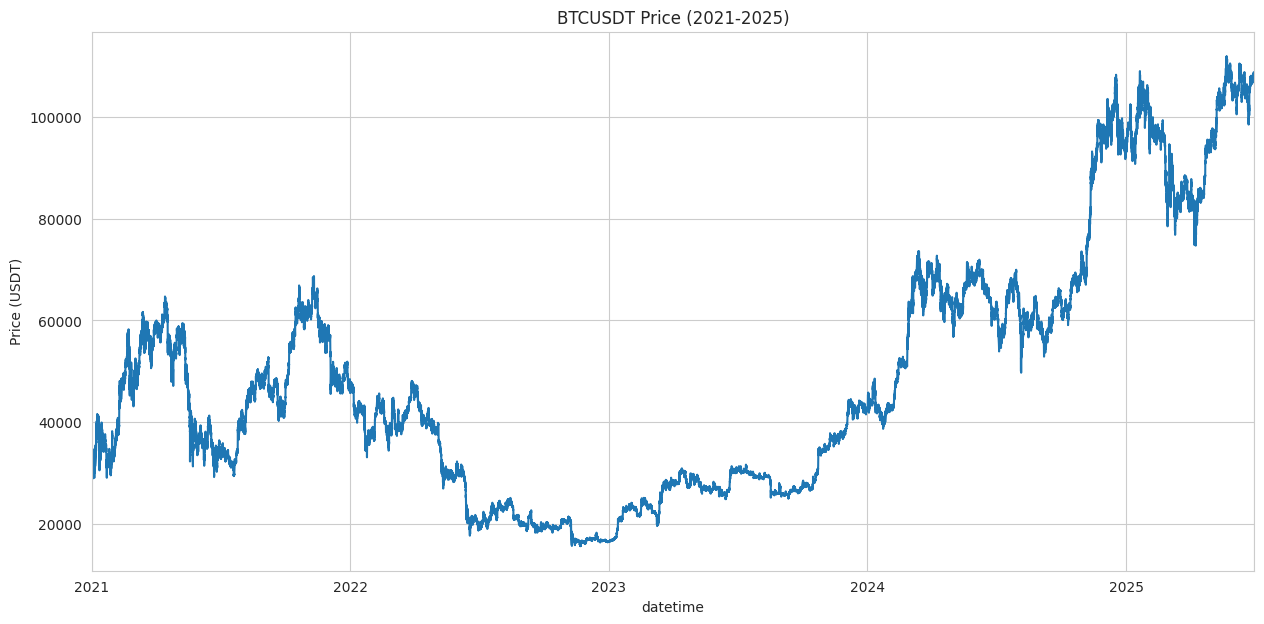

In [ ]:
# 2.1: Price and Volume Visualization
plt.figure(figsize=(15, 7))
price_df['close'].plot(title='BTCUSDT Price (2021-2025)')
plt.ylabel('Price (USDT)')
plt.savefig(f'{EDA_PLOTS_FOLDER}/price_timeseries.png')
plt.show()
plt.close()

**Price and volume**

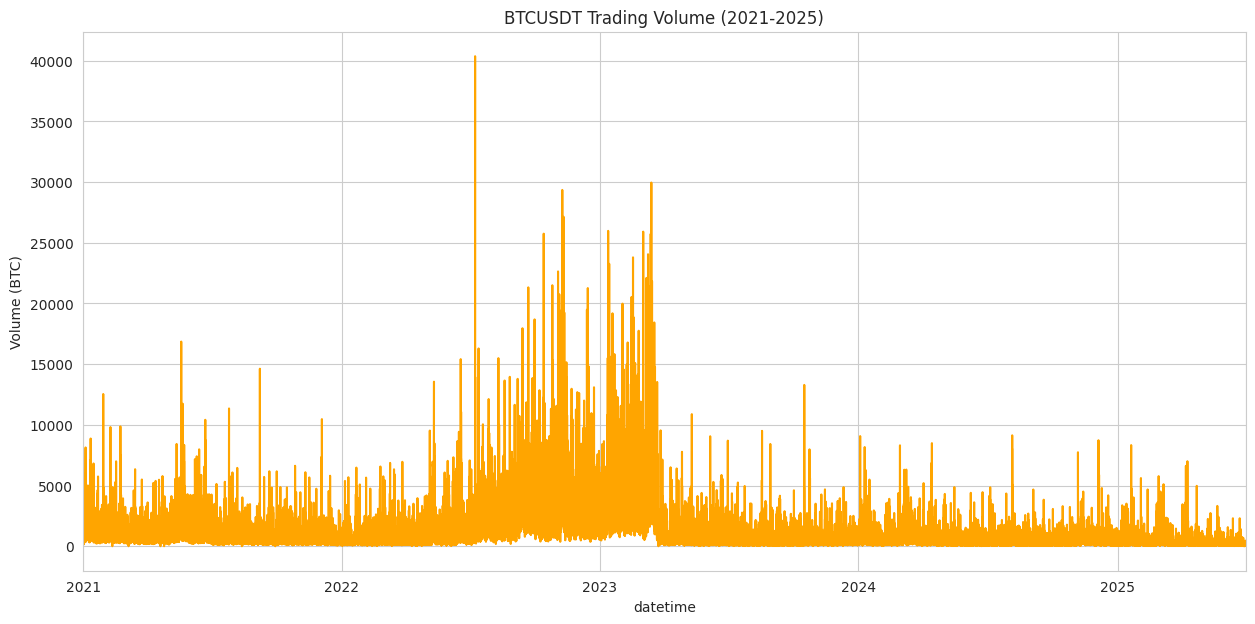

✓ Price and volume plots created.


In [ ]:
plt.figure(figsize=(15, 7))
price_df['volume'].plot(title='BTCUSDT Trading Volume (2021-2025)', color='orange')
plt.ylabel('Volume (BTC)')
plt.savefig(f'{EDA_PLOTS_FOLDER}/volume_timeseries.png')
plt.show()
plt.close()
print("✓ Price and volume plots created.")

**Interpretation**

- **BTCUSDT Price (2021–2025):**  
  The price series shows multiple bull and bear cycles. After a strong rally in 2021, BTC entered a prolonged drawdown through 2022, bottomed in early 2023, and then resumed an upward trend, surpassing prior highs by 2025.  

- **BTCUSDT Trading Volume (2021–2025):**  
  Volume was elevated during the 2021 bull market, spiked significantly in mid–2022 to early–2023 (possibly due to panic sell-offs and volatility events), and stabilized afterward at lower levels, with occasional spikes reflecting local market events.  


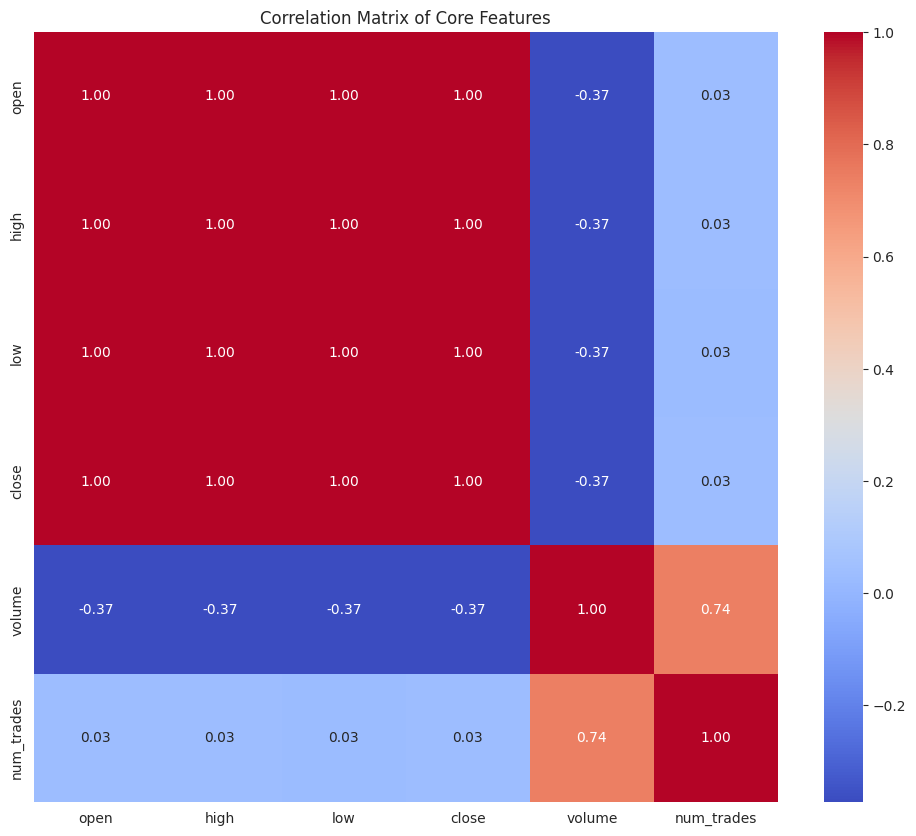

✓ Correlation heatmap created.
✓ All EDA plots saved to the 'eda_plots' folder.
--- EDA Complete ---


In [ ]:
# Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = price_df[['open', 'high', 'low', 'close', 'volume', 'num_trades']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Core Features')
plt.savefig(f'{EDA_PLOTS_FOLDER}/correlation_heatmap.png')
plt.show()
plt.close()
print("✓ Correlation heatmap created.")
print(f"✓ All EDA plots saved to the '{EDA_PLOTS_FOLDER}' folder.")
print("--- EDA Complete ---")

**Correlation Matrix (OHLCV & Trades):**  
  - `open`, `high`, `low`, and `close` are perfectly correlated (as expected in high-frequency OHLC data).  
  - `volume` is moderately negatively correlated with prices (≈ –0.37), suggesting heavy trading often coincided with price declines.  
  - `num_trades` is strongly correlated with `volume` (≈ 0.74), which indicates trade count and traded volume move together.  


**Missing Value & Outlier Check**

open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
num_trades                0
taker_buy_base_volume     0
taker_buy_quote_volume    0
dtype: int64


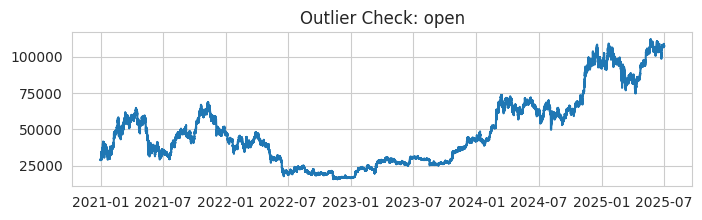

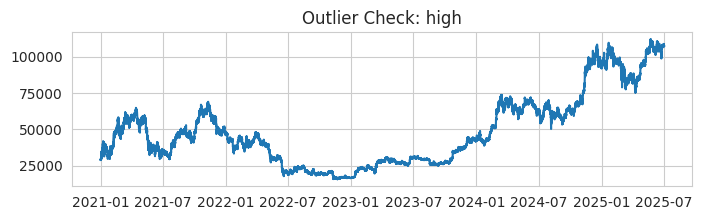

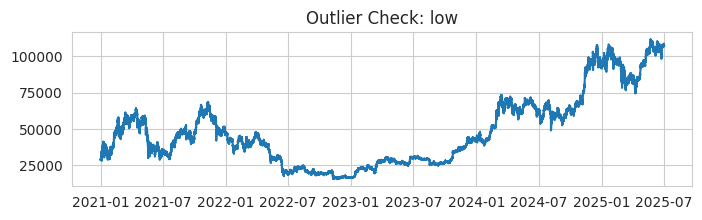

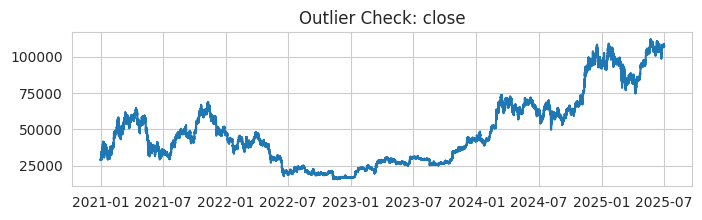

In [ ]:
# 1. Check if any NaNs remain
print(price_df.isna().sum())

# 2. Quick outlier check for price columns
for col in ['open', 'high', 'low', 'close']:
    plt.figure(figsize=(8,2))
    plt.plot(price_df[col])
    plt.title(f'Outlier Check: {col}')
    plt.show()

**OHLC Columns (open, high, low, close):**  
  Line plots of each column showed smooth progression without extreme spikes, confirming there are no structural outliers or broken datapoints in price fields.  

**Distribution of Volume and Trades**

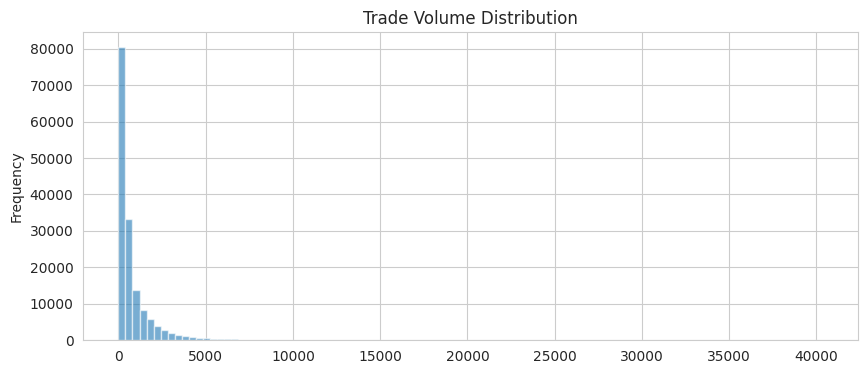

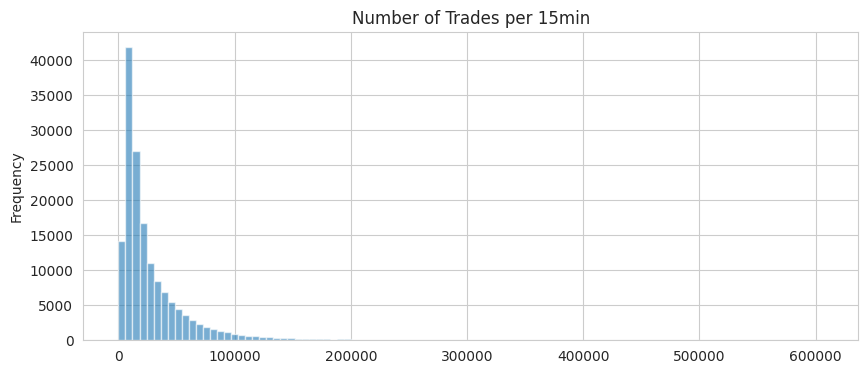

In [ ]:
# Volume distribution
price_df['volume'].plot(kind='hist', bins=100, alpha=0.6, figsize=(10,4), title='Trade Volume Distribution')
plt.show()

# Trades per interval
price_df['num_trades'].plot(kind='hist', bins=100, alpha=0.6, figsize=(10,4), title='Number of Trades per 15min')
plt.show()

- **Trade Volume Distribution:**  
  Histogram shows a heavy right-skew. Most 15-min intervals have low volumes, while a few extreme intervals had very large spikes (tail events).  

- **Number of Trades Distribution:**  
  Also right-skewed with a long tail. The majority of intervals have modest trade counts, but extreme outliers reach hundreds of thousands of trades, reflecting high-frequency bursts during volatile events.  


**Resample to Daily or Weekly for Trend Analysis**

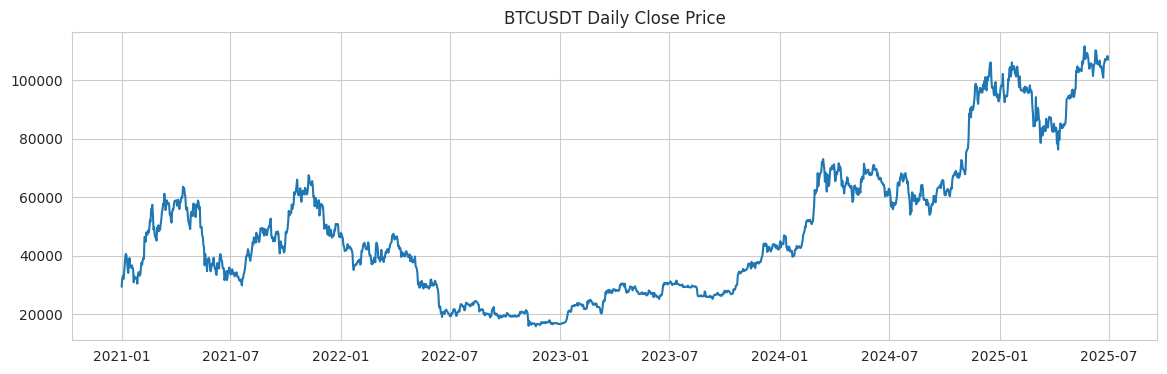

In [ ]:
btc_daily = price_df['close'].resample('D').last()
plt.figure(figsize=(14,4))
plt.plot(btc_daily)
plt.title('BTCUSDT Daily Close Price')
plt.show()

**BTCUSDT Daily Close (2021–2025):**  
  Daily resampling of close prices smooths intra-day noise and clearly shows macro cycles:  
  - Bull run through 2021.  
  - Bear phase throughout 2022 with bottom in early 2023.  
  - Recovery and new highs across 2024–2025.  

##**Step 4: FEATURE ENGINEERING & FINAL DISPLAY**

**i. Creating Technical Indicators**

In [ ]:
print("\n--- Starting Part 3: Feature Engineering ---")

price_df.ta.sma(length=20, append=True)
price_df.ta.ema(length=50, append=True)
price_df.ta.rsi(append=True)
price_df.ta.macd(append=True)
price_df.ta.bbands(length=20, append=True)
price_df.ta.obv(append=True)
price_df['hour'] = price_df.index.hour
price_df['day_of_week'] = price_df.index.dayofweek
for lag in [1, 2, 3, 5, 8, 13]:
    price_df[f'close_lag_{lag}'] = price_df['close'].shift(lag)
    price_df[f'volume_lag_{lag}'] = price_df['volume'].shift(lag)
price_df['target'] = price_df['close'].shift(-1)
price_df.dropna(inplace=True)
print("✓ Feature engineering complete.")

print("\n--- Displaying Final Model-Ready Dataset ---")
print("\nFinal DataFrame Head:")
print(price_df.head())
print("\nFinal DataFrame Tail:")
print(price_df.tail())


--- Starting Part 3: Feature Engineering ---
✓ Feature engineering complete.

--- Displaying Final Model-Ready Dataset ---

Final DataFrame Head:
                         open      high       low     close       volume  \
datetime                                                                   
2021-01-01 12:15:00  29260.00  29448.00  29240.00  29443.65   681.279331   
2021-01-01 12:30:00  29443.65  29600.00  29420.00  29492.62  1813.291410   
2021-01-01 12:45:00  29492.62  29500.00  29150.00  29233.49  1259.076981   
2021-01-01 13:00:00  29233.49  29384.96  29200.00  29383.85   638.753137   
2021-01-01 13:15:00  29384.98  29420.00  29300.07  29389.36   586.721873   

                     quote_asset_volume  num_trades  taker_buy_base_volume  \
datetime                                                                     
2021-01-01 12:15:00        2.001220e+07     15300.0             417.116777   
2021-01-01 12:30:00        5.353395e+07     32375.0            1202.666225   
2021-01-

* All indicators use only past data.

* Lags are created by shifting backward in time.

* Target is shifted forward (shift(-1)) and only used as the label.

* dropna() removes the initial periods where indicators/targets can’t be computed.

**Check for missing intervals**

In [ ]:
# Check for missing 15-min intervals
expected = pd.date_range(start=price_df.index.min(), end=price_df.index.max(), freq='15min')
missing_times = expected.difference(price_df.index)
print("Missing 15-min intervals:", len(missing_times))

Missing 15-min intervals: 0


**Fill the intervals**

In [ ]:
# Ensure index is sorted
price_df = price_df.sort_index()

# Create the full expected 15-min index
expected_index = pd.date_range(start=price_df.index.min(), end=price_df.index.max(), freq='15min')

# Reindex and forward fill
price_df = price_df.reindex(expected_index).ffill()

print("After filling, missing intervals:", expected_index.difference(price_df.index))

After filling, missing intervals: DatetimeIndex([], dtype='datetime64[ns]', freq='15min')


In [ ]:
# Check for missing 15-min intervals
expected = pd.date_range(start=price_df.index.min(), end=price_df.index.max(), freq='15min')
missing_times = expected.difference(price_df.index)
print("Missing 15-min intervals:", len(missing_times))

Missing 15-min intervals: 0


**Feature Engineering & Final Dataset**

**1. Technical Indicators**

- **SMA (20-period):** Simple moving average to smooth short-term fluctuations.  
- **EMA (50-period):** Exponential moving average for trend detection.  
- **RSI:** Relative Strength Index for momentum analysis.  
- **MACD (12,26,9):** Trend/momentum indicator with signal & histogram values.  
- **Bollinger Bands (20, 2σ):** Volatility bands around 20-period SMA.  
- **OBV:** On-Balance Volume for volume-price confirmation.  

---

**2. Time-based Features**

- `hour` → captures intra-day seasonality.  
- `day_of_week` → captures weekly trading behavior.  

---

**3. Lag Features**

- Created lagged values for close and volume at steps `[1, 2, 3, 5, 8, 13]`.  
- These features provide historical context for predictive modeling.  

---

**4. Target Variable**

- Defined `target` as the **next close price** (`shift(-1)`), enabling supervised forecasting.  

---

**5. Final Dataset**

- Dropped NaN rows created by lagging/indicators.  
- Result = **model-ready DataFrame** with OHLCV + engineered features + target.  
- Final shape: rows aligned to 15-min intervals, columns = base features + engineered indicators.  

**Save the dataset**

In [ ]:
price_df.to_csv('/content/drive/MyDrive/Thesis/final_price_df.csv', index=True)
print("Final dataset saved to '/content/drive/MyDrive/Thesis/final_price_df.csv'")

Final dataset saved to '/content/drive/MyDrive/Thesis/final_price_df.csv'


In [ ]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157582 entries, 2021-01-01 12:15:00 to 2025-06-30 23:30:00
Freq: 15min
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   open                    157582 non-null  float64
 1   high                    157582 non-null  float64
 2   low                     157582 non-null  float64
 3   close                   157582 non-null  float64
 4   volume                  157582 non-null  float64
 5   quote_asset_volume      157582 non-null  float64
 6   num_trades              157582 non-null  float64
 7   taker_buy_base_volume   157582 non-null  float64
 8   taker_buy_quote_volume  157582 non-null  float64
 9   SMA_20                  157582 non-null  float64
 10  EMA_50                  157582 non-null  float64
 11  RSI_14                  157582 non-null  float64
 12  MACD_12_26_9            157582 non-null  float64
 13  MACDh_12_26_9           1575

# **B. Onchain Metrics**

## **Step 1: Initial Inspection**

1. Loaded the on-chain dataset (15-min granularity).  
2. Viewed the DataFrame structure and column information using `.info()`.  
3. Printed the first few rows with `.head()`.  
4. Generated summary statistics with `.describe()` for each metric.  
5. Checked for missing values in all columns using `.isna().sum()`.  
6. Counted unique values across columns using `.nunique()`.  
7. Verified the minimum and maximum of the datetime column to confirm the expected date range.  

**1. Load the dataset**

In [ ]:
onchain_df = pd.read_csv(onchain_path)

**2. Dataframe info**

In [ ]:
onchain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 8 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   active_addresses         122400 non-null  int64  
 1   avg_block_interval_secs  122400 non-null  float64
 2   avg_block_size_bytes     122400 non-null  float64
 3   avg_tx_fee_btc           122400 non-null  float64
 4   miner_revenue_btc        122400 non-null  float64
 5   time_bucket_15m          122400 non-null  object 
 6   total_btc_transferred    122400 non-null  float64
 7   tx_count                 122400 non-null  int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 7.5+ MB


**3. Print first few rows**

In [ ]:
onchain_df.head()

,active_addresses,avg_block_interval_secs,avg_block_size_bytes,avg_tx_fee_btc,miner_revenue_btc,time_bucket_15m,total_btc_transferred,tx_count
0,3641,0.000000,1.309398e+06,4.745643e-12,6.868832e-08,2021-01-01 00:00:00,0.000037,1304
1,11456,416.333333,1.730930e+06,1.919042e-12,1.955369e-07,2021-01-01 00:15:00,0.000457,4188
2,4976,601.000000,1.454916e+06,2.403489e-12,6.652344e-08,2021-01-01 00:30:00,0.000021,1674
3,9542,720.500000,1.193088e+06,3.195965e-12,1.345975e-07,2021-01-01 00:45:00,0.000142,3003
4,11218,216.500000,1.572102e+06,1.700846e-12,2.573936e-07,2021-01-01 01:00:00,0.000195,4347


**4. Show summary statistics**

In [ ]:
onchain_df.describe(include='all')

,active_addresses,avg_block_interval_secs,avg_block_size_bytes,avg_tx_fee_btc,miner_revenue_btc,time_bucket_15m,total_btc_transferred,tx_count
count,122400.000000,122400.000000,1.224000e+05,1.224000e+05,1.224000e+05,122400,1.224000e+05,122400.000000
unique,NaN,NaN,NaN,NaN,NaN,122400,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,2025-06-29 18:15:00,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN
mean,10142.269632,733.339085,1.478198e+06,1.219690e-12,1.110736e-07,NaN,2.412130e-04,4934.866708
std,5237.608132,551.225224,3.799407e+05,4.493781e-12,6.849150e-08,NaN,3.717780e-04,3700.934677
min,1.000000,0.000000,3.120000e+02,0.000000e+00,3.125000e-08,NaN,3.125000e-08,1.000000
25%,6536.000000,360.950000,1.351645e+06,3.180166e-13,6.383550e-08,NaN,5.846940e-05,2665.000000
50%,9017.000000,570.500000,1.524180e+06,5.717967e-13,8.018447e-08,NaN,1.172240e-04,3695.000000
75%,12702.000000,939.000000,1.657781e+06,1.172986e-12,1.331086e-07,NaN,2.752806e-04,6075.000000


**5. Check for missing values**

In [ ]:
print("\n---- Missing Values ----")
print(onchain_df.isnull().sum())


---- Missing Values ----
active_addresses           0
avg_block_interval_secs    0
avg_block_size_bytes       0
avg_tx_fee_btc             0
miner_revenue_btc          0
time_bucket_15m            0
total_btc_transferred      0
tx_count                   0
dtype: int64


**6. Checking for unique value**

In [ ]:
print("\n---- Unique Values ----")
for col in onchain_df.columns:
    print(f"{col}: {onchain_df[col].nunique()} unique")


---- Unique Values ----
active_addresses: 22906 unique
avg_block_interval_secs: 9574 unique
avg_block_size_bytes: 118038 unique
avg_tx_fee_btc: 122397 unique
miner_revenue_btc: 122365 unique
time_bucket_15m: 122400 unique
total_btc_transferred: 122398 unique
tx_count: 15959 unique


**7. Checking Min and Max of dates**

In [ ]:
# If you have a timestamp/date column, show min and max
if 'time_bucket_15m' in onchain_df.columns:
    print("\nMin date:", onchain_df['time_bucket_15m'].min(), " Max date:", onchain_df['time_bucket_15m'].max())
else:
    print("No 'date/time' column found.")


Min date: 2021-01-01 00:00:00  Max date: 2025-06-29 23:45:00


In [ ]:
rows_per_day = (
    pd.Series(1, index=pd.to_datetime(onchain_df['time_bucket_15m']))
    .resample('D').sum()
)

missing_days = rows_per_day[rows_per_day != 96]
print("Days with missing intervals:", missing_days)

total_missing_intervals = (96 - rows_per_day).sum()
print("Total missing 15-min intervals:", total_missing_intervals)

Days with missing intervals: time_bucket_15m
2021-01-01    81
2021-01-02    80
2021-01-03    79
2021-01-04    78
2021-01-05    81
              ..
2025-06-25    75
2025-06-26    77
2025-06-27    72
2025-06-28    74
2025-06-29    75
Freq: D, Length: 1641, dtype: int64
Total missing 15-min intervals: 35136


**Analysis of Initial Inspection**

1. No missing values.

2. Time coverage is exactly as expected (15-min intervals, 2021-01-01 00:00:00 – 2025-06-29 23:45:00). But there are 35,136 missing intervals which need to handle using appropriate filling method.

3. No obvious outliers or structural issues in summary statistics.

4. time_bucket_15m is our timestamp and appears unique per row.

## **Step 2: Data Cleaning & Preprocessing**

1. **Normalized timestamps to naive UTC**  
   - Converted any timezone-aware index to UTC then stripped tz info using a helper (`normalize_to_naive_utc_index`).

2. **Price index prepared for alignment**  
   - Copied and sorted `price_df` by index.  
   - Checked for duplicated timestamps and normalized its index to naive UTC.

3. **Built on-chain datetime index**  
   - Searched candidate timestamp columns (`time_bucket_15m`, `timestamp`, `time`, `datetime`, `date`, `Date`, `Datetime`).  
   - Parsed the detected column to UTC datetimes (error-coerced), set as index, and dropped the original column.  
   - If no column existed, attempted to parse the current index as datetimes.  
   - Sorted and normalized the on-chain index to naive UTC.

4. **Clamped on-chain window to price window**  
   - Restricted `onchain_df` to `[price_df.index.min(), price_df.index.max()]`.

5. **Reindexed to match the price grid exactly**  
   - Reindexed `onchain_df` to `price_df.index` (15-min grid), inserting any missing slots.

6. **Filled values for key metrics**  
   - Forward-filled, then one-step backfilled at the very start for:  
     `active_addresses`, `avg_block_interval_secs`, `avg_block_size_bytes`,  
     `avg_tx_fee_btc`, `miner_revenue_btc`, `total_btc_transferred`, `tx_count`.

7. **Alignment & completeness checks**  
   - Printed aligned shapes and confirmed index equality with `price_df`.  
   - Reported any remaining NaNs in filled columns.  
   - Verified 96 rows/day after alignment and listed days that deviated.  
   - Computed count of missing 15-min intervals across the full range.


In [ ]:
# --- helpers ---
def normalize_to_naive_utc_index(idx: pd.Index) -> pd.DatetimeIndex:
    idx = pd.DatetimeIndex(idx)
    if idx.tz is None:
        idx = idx.tz_localize('UTC')
    else:
        idx = idx.tz_convert('UTC')
    return idx.tz_localize(None)

# --- 1) price_df: sort + normalize index ---
price_df = price_df.copy().sort_index()
if price_df.index.duplicated().any():
    raise ValueError(f"price_df has {price_df.index.duplicated().sum()} duplicated timestamps.")
price_df.index = normalize_to_naive_utc_index(price_df.index)

# --- 2) onchain_df: build datetime index + normalize ---
onchain_df = onchain_df.copy()

candidate_ts_cols = ['time_bucket_15m','timestamp','time','datetime','date','Date','Datetime']
ts_col = next((c for c in candidate_ts_cols if c in onchain_df.columns), None)

if ts_col is not None:
    onchain_df['__dt__'] = pd.to_datetime(onchain_df[ts_col], errors='coerce', utc=True)
    if onchain_df['__dt__'].isna().any():
        bad = int(onchain_df['__dt__'].isna().sum())
        raise ValueError(f"Found {bad} invalid timestamps in '{ts_col}'.")
    onchain_df = onchain_df.drop(columns=[ts_col]).set_index('__dt__')
else:
    try_idx = pd.to_datetime(onchain_df.index, errors='coerce', utc=True)
    if try_idx.isna().any():
        raise KeyError("No timestamp column found and index is not parseable as datetime.")
    onchain_df.index = try_idx

onchain_df.index = normalize_to_naive_utc_index(onchain_df.index)
onchain_df = onchain_df.sort_index()

# --- 3) clamp to price_df window ---
start, end = price_df.index.min(), price_df.index.max()
onchain_df = onchain_df.loc[(onchain_df.index >= start) & (onchain_df.index <= end)]

# --- 4) reindex to exactly match price_df ---
target_index = price_df.index
before_rows = len(onchain_df)
onchain_df = onchain_df.reindex(target_index)
inserted = len(onchain_df) - before_rows
print(f"Inserted {inserted} missing 15-min slots to match price_df index.")

# --- 5) fill values: ffill then 1-step bfill to patch the very start ---
ffill_cols = [
    'active_addresses', 'avg_block_interval_secs', 'avg_block_size_bytes',
    'avg_tx_fee_btc', 'miner_revenue_btc', 'total_btc_transferred', 'tx_count'
]
ffill_cols = [c for c in ffill_cols if c in onchain_df.columns]

onchain_df[ffill_cols] = onchain_df[ffill_cols].ffill()
onchain_df[ffill_cols] = onchain_df[ffill_cols].bfill(limit=1)

# --- 6) checks ---
print("Aligned shape:", onchain_df.shape, "==", price_df.shape)
print("Index equal:", onchain_df.index.equals(price_df.index))
rem_nans = onchain_df[ffill_cols].isna().sum()
print("Remaining NaNs per col:", rem_nans[rem_nans > 0] if rem_nans.sum() else "None")

# 96 rows/day completeness (based on aligned index)
rows_per_day = pd.Series(1, index=onchain_df.index).resample('D').sum()
gaps = rows_per_day[rows_per_day != 96]
if not gaps.empty:
    print("Warning: Some days are not 96 rows — check price_df index regularity.")


Inserted 35227 missing 15-min slots to match price_df index.
Aligned shape: (157582, 7) == (157582, 36)
Index equal: True
Remaining NaNs per col: None


In [ ]:
# Check for missing 15-min intervals
expected = pd.date_range(start=onchain_df.index.min(), end=onchain_df.index.max(), freq='15min')
missing_times = expected.difference(onchain_df.index)
print("Missing 15-min intervals:", len(missing_times))

Missing 15-min intervals: 0


This warning is `Warning: Some days are not 96 rows — check price_df index regularity.` because price_df is starting from 2021-01-01 (12:15) because of the technical indicators creation initial few data was deleted. In onchain_df I am matchin it with price_df so. No further handling is needed.

In [ ]:
onchain_df.head()

,active_addresses,avg_block_interval_secs,avg_block_size_bytes,avg_tx_fee_btc,miner_revenue_btc,total_btc_transferred,tx_count
2021-01-01 12:15:00,8393.0,405.0,1474995.5,1.002317e-12,1.288068e-07,0.000177,3798.0
2021-01-01 12:30:00,4003.0,403.0,1350613.0,1.244297e-12,6.472480e-08,0.000179,1788.0
2021-01-01 12:45:00,9789.0,663.0,1334992.5,1.732474e-12,1.312421e-07,0.000072,3603.0
2021-01-01 13:00:00,9789.0,663.0,1334992.5,1.732474e-12,1.312421e-07,0.000072,3603.0
2021-01-01 13:15:00,9789.0,663.0,1334992.5,1.732474e-12,1.312421e-07,0.000072,3603.0


## **Step 3: Exploratory Data Analysis (EDA)**

**Plot major metrics**

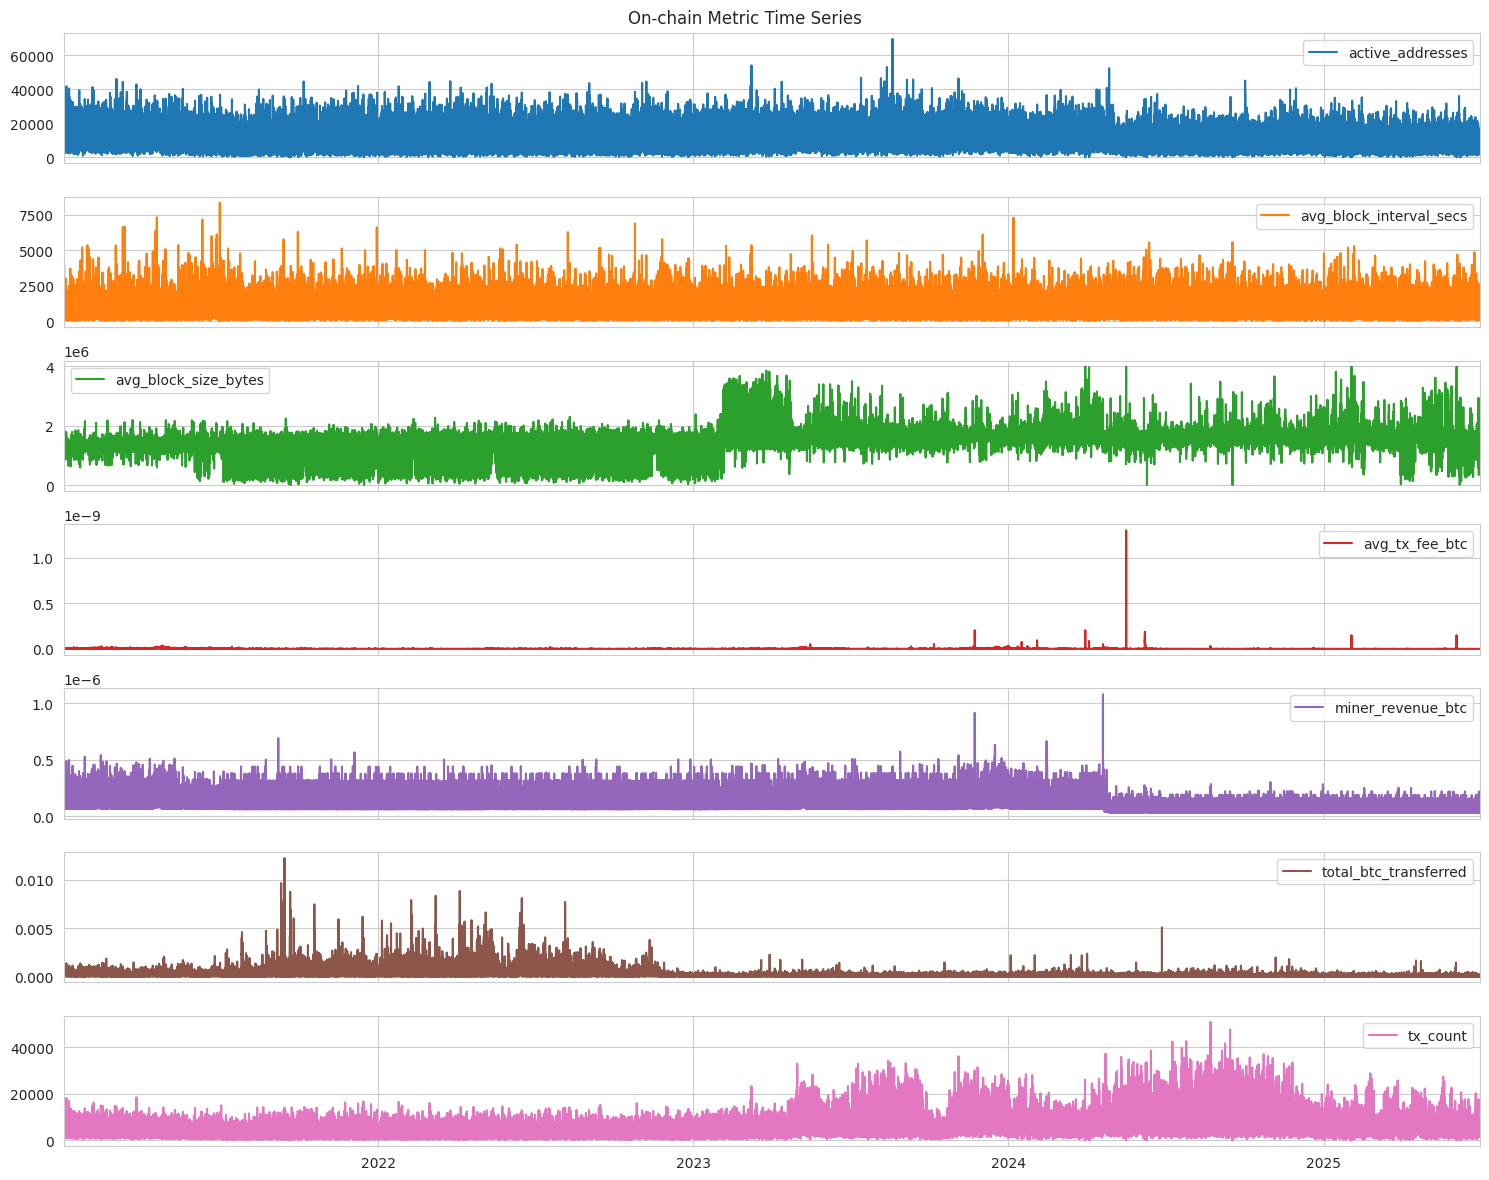

In [ ]:
# Plot each major metric
onchain_df[[
    'active_addresses', 'avg_block_interval_secs', 'avg_block_size_bytes',
    'avg_tx_fee_btc', 'miner_revenue_btc', 'total_btc_transferred', 'tx_count'
]].plot(subplots=True, figsize=(15,12), title="On-chain Metric Time Series")
plt.tight_layout()
plt.show()

**correlation heatmap**

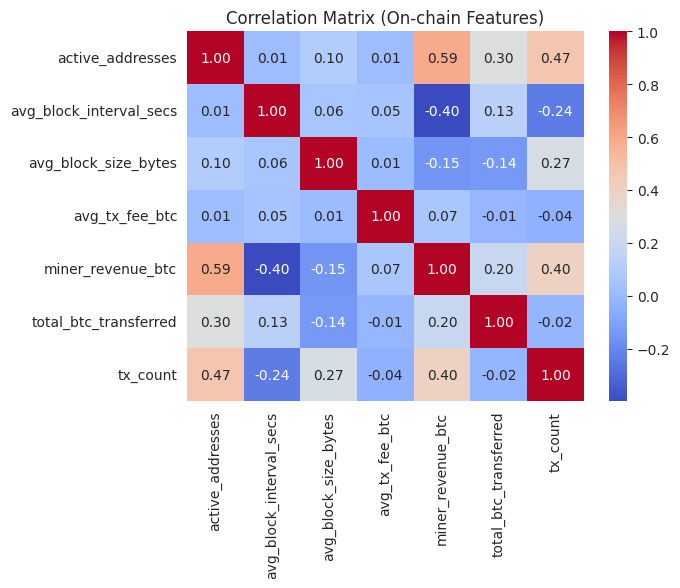

In [ ]:
# Quick correlation heatmap
corr = onchain_df[[
    'active_addresses', 'avg_block_interval_secs', 'avg_block_size_bytes',
    'avg_tx_fee_btc', 'miner_revenue_btc', 'total_btc_transferred', 'tx_count'
]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix (On-chain Features)")
plt.show()

**3.1 On-chain Metric Time Series**

- **Active Addresses:**  
  Shows steady baseline usage with notable spikes, reflecting network participation during key market cycles.  

- **Avg Block Interval (secs):**  
  Remains mostly stable around expected values, with occasional spikes due to network congestion or difficulty adjustments.  

- **Avg Block Size (bytes):**  
  Generally trends upward over time, reflecting more transaction data per block, with visible structural shifts.  

- **Avg Transaction Fee (BTC):**  
  Mostly low but exhibits sharp spikes during congestion periods (e.g., bull runs or mempool backlogs).  

- **Miner Revenue (BTC):**  
  Correlates strongly with both activity and price cycles — surges in 2021 and again into 2024–2025 reflect higher fee and block rewards.  

- **Total BTC Transferred:**  
  Spiky and irregular, reflecting whale transfers and exchange flows.  

- **Transaction Count:**  
  Rises in high-activity periods (late 2020–2021, 2024–2025) and dips during quiet market phases (2022–2023).  


**3.2 Correlation Analysis**

- **Positive relationships:**  
  - `active_addresses` ↔ `miner_revenue_btc` (≈ 0.59) — higher activity drives more miner income.  
  - `tx_count` ↔ `volume of activity metrics` (≈ 0.40 with miner revenue, 0.47 with active addresses).  

- **Negative relationships:**  
  - `avg_block_interval_secs` shows inverse correlation with `miner_revenue_btc` (≈ –0.40) and `tx_count` (≈ –0.24), consistent with shorter intervals increasing miner output and transaction throughput.  

- **Weak correlations:**  
  - `avg_tx_fee_btc` shows little consistent correlation across features, reflecting its spiky, event-driven nature.  


## **Feature Engineering**

**1. Rate of Change / Momentum**

Captures short-term shifts in activity.

In [ ]:
onchain_df["active_addresses_roc"] = onchain_df["active_addresses"].pct_change()
onchain_df["tx_count_roc"] = onchain_df["tx_count"].pct_change()

**2. Rolling averages**

Smooth noisy on-chain metrics (miners’ data is spiky).

In [ ]:
onchain_df["miner_rev_ma_8"] = onchain_df["miner_revenue_btc"].rolling(8, min_periods=1).mean()
onchain_df["avg_fee_ma_8"] = onchain_df["avg_tx_fee_btc"].rolling(8, min_periods=1).mean()

**3. Efficiency ratios**

Relationships are more predictive than raw levels:

In [ ]:
onchain_df["tx_per_address"] = onchain_df["tx_count"] / (onchain_df["active_addresses"] + 1e-9)
onchain_df["fee_per_tx"] = onchain_df["avg_tx_fee_btc"] / (onchain_df["tx_count"] + 1e-9)

**4. Volatility of transferred BTC**

Captures stress / big whale moves.

In [ ]:
onchain_df["btc_transferred_vol"] = (
    onchain_df["total_btc_transferred"].rolling(12, min_periods=1).std()
)

## **Final Check and Saving**

In [ ]:
onchain_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157582 entries, 2021-01-01 12:15:00 to 2025-06-30 23:30:00
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   active_addresses         157582 non-null  float64
 1   avg_block_interval_secs  157582 non-null  float64
 2   avg_block_size_bytes     157582 non-null  float64
 3   avg_tx_fee_btc           157582 non-null  float64
 4   miner_revenue_btc        157582 non-null  float64
 5   total_btc_transferred    157582 non-null  float64
 6   tx_count                 157582 non-null  float64
 7   active_addresses_roc     157581 non-null  float64
 8   tx_count_roc             157581 non-null  float64
 9   miner_rev_ma_8           157582 non-null  float64
 10  avg_fee_ma_8             157582 non-null  float64
 11  tx_per_address           157582 non-null  float64
 12  fee_per_tx               157582 non-null  float64
 13  btc_transferred_vol      

**Save the dataset**

In [ ]:
onchain_df.to_csv('/content/drive/MyDrive/Thesis/final_onchain_df.csv', index=True)
print("Final dataset saved to '/content/drive/MyDrive/Thesis/final_onchain_df.csv'")

Final dataset saved to '/content/drive/MyDrive/Thesis/final_onchain_df.csv'


# **C. News Dataset**

## **Step 1: Initial Inspection**

1. **Quick data overview**  
   Loaded the merged news file (`merged_crypto_news_data.csv`) and previewed rows with `.head()` / `.tail()`; inspected schema with `.info()`.

2. **Missing values**  
   Computed null counts per column via `.isna().sum()` focusing on `publishedDate`, `title`, `text`, `url`, and `site`.

3. **Quick statistics (date distribution)**  
   Parsed `publishedDate` to datetime and generated quick distributions (e.g., daily/monthly counts with `value_counts()` / `groupby`), to see coverage and intensity over time.

4. **Date range**  
   Verified `publishedDate.min()` and `publishedDate.max()` to confirm the window matches the study period.

5. **Duplicates**  
   Removed duplicates primarily by `url` (fallback to `title` if needed) using `.drop_duplicates(...)`.

In [ ]:
news_df = pd.read_csv(btc_news_path)

**1. Quick Data Overview**

In [ ]:
news_df.head()

,publishedDate,title,image,site,text,url,symbol,year,month
0,2021-12-10 23:38:22+00:00,CipherTrace Cryptocurrency Training and Certif...,https://images.financialmodelingprep.com/news/...,ciphertrace.com,CipherTrace offers a variety of training and c...,https://ciphertrace.com/ciphertrace-cryptocurr...,NaN,2021,12
1,2021-12-13 22:49:21+00:00,CipherTrace Traveler solves the Sunrise Proble...,https://images.financialmodelingprep.com/news/...,ciphertrace.com,The Financial Action Task Force (FATF) recentl...,https://ciphertrace.com/general-availability-o...,NaN,2021,12
2,2021-12-15 17:53:02+00:00,US Senate Hearing Recap on Stablecoins,https://images.financialmodelingprep.com/news/...,ciphertrace.com,"On Dec. 14, 2021, the Senate Banking Committee...",https://ciphertrace.com/us-senate-hearing-reca...,NaN,2021,12
3,2021-12-22 20:40:38+00:00,2021 = 2020^10,https://images.financialmodelingprep.com/news/...,blog.aragon.org,"""...composable DAO technology and a kick-ass t...",https://blog.aragon.org/2021-retrospective/,DAO-USD,2021,12
4,2022-01-10 09:33:46+00:00,Introducing Weighted Voting,https://images.financialmodelingprep.com/news/...,blog.aragon.org,How weighted voting works and is suited to all...,https://blog.aragon.org/introducing-weighted-v...,NaN,2022,1


In [ ]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 511604 entries, 0 to 511603
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   publishedDate  511604 non-null  object
 1   title          511604 non-null  object
 2   image          511604 non-null  object
 3   site           511379 non-null  object
 4   text           510699 non-null  object
 5   url            511604 non-null  object
 6   symbol         392052 non-null  object
 7   year           511604 non-null  int64 
 8   month          511604 non-null  int64 
dtypes: int64(2), object(7)
memory usage: 35.1+ MB


**2: Check for Missing Values**

In [ ]:
print("---- Missing Values ----")
print(news_df.isnull().sum())

---- Missing Values ----
publishedDate         0
title                 0
image                 0
site                225
text                905
url                   0
symbol           119552
year                  0
month                 0
dtype: int64


**3: Quick Statistics (to check the value distribution of date)**

In [ ]:
news_df.describe(include='all')

,publishedDate,title,image,site,text,url,symbol,year,month
count,511604,511604,511604,511379,510699,511604,392052,511604.000000,511604.000000
unique,469689,491387,507984,183,501280,511594,11539,NaN,NaN
top,2021-07-29 16:05:00,Form 8.3 - Sumo Group plc,https://images.financialmodelingprep.com/news/...,businesswire.com,Key Points:,https://crypto-economy.com/tether-fights-back-...,BTCUSD,NaN,NaN
freq,52,96,7,33300,154,2,97666,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.247205,6.195905
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.242902,3.427584
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.000000,1.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.000000,3.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.000000,6.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.000000,9.000000


**4: Check for Range of Dates**

In [ ]:
print("---- Date Range ----")
if 'publishedDate' in news_df.columns:
    print("Min date:", news_df['publishedDate'].min())
    print("Max date:", news_df['publishedDate'].max())
else:
    print("No 'publishedDate' column found.")

---- Date Range ----
Min date: 2021-01-01 03:09:26
Max date: 2025-06-30 05:30:58+00:00


**5: Check for Duplicates**

In [ ]:
print("---- Duplicate Rows ----")
print("Total duplicate rows:", news_df.duplicated().sum())

---- Duplicate Rows ----
Total duplicate rows: 0


**Analysis of Initial Inspection**

1. Rows: 511,604, each with a date, title, text, etc.

2. Missing Values:

* text: 905 missing

* site: 225 missing

* symbol: 119,552 missing

3. No duplicate rows!

4. Date Range: 2021-01-01 to 2025-06-30

5. Column needed for sentiment analysis: `publishedDate`, `title` and `text`.

6. Other columns may needed for explanability: `symbol`.

7. Text Quality: Some missing texts, but relatively small fraction.


## **Step 2: Data Pre-processing and Cleaning**

1) **Import & initial cleanup**  
   - Loaded the merged news file keeping only needed columns: `publishedDate`, `title`, `text`, `symbol`.

2) **Fix & unify timestamps**  
   - Parsed `publishedDate` with a robust parser (`robust_parse`) to handle messy strings.  
   - Standardized to **UTC** (`pd.to_datetime(..., utc=True)`), dropped invalid timestamps, set as index, and sorted.

3) **Combine title + body**  
   - Built `full_text = title + '. ' + text`, then dropped the original `title`, `text`, and `publishedDate` columns.

4) **Drop near-empty articles**  
   - Removed rows where `full_text` is blank/whitespace only.

5) **Count duplicates in `full_text`**  
   - Reported total duplicate rows and count of non-unique texts for transparency.

6) **Remove duplicates (keep first)**  
   - Deduplicated on `full_text` and kept the first occurrence.

7) **Handle missing `symbol`**  
   - For rows with null `symbol`, assigned `BTCUSD` if `full_text` mentions Bitcoin variants  
     (regex: `bitcoin|btc|btc[-_]usd`, case-insensitive).  
   - Filled remaining nulls with `GENERIC`.

8) **Final checks (printed diagnostics)**  
   - Data types and index sample (`.info()`), null counts, empty-text count, duplicate counts,  
     symbol coverage and cardinality, date range & row counts, plus a random sample of rows.


**1. Import and Initial Cleanup**

In [ ]:
# Only keep columns we need
COLUMNS_TO_KEEP = ['publishedDate', 'title', 'text', 'symbol']
news_df = pd.read_csv(btc_news_path, usecols=[col for col in COLUMNS_TO_KEEP if col in pd.read_csv(btc_news_path, nrows=0).columns])

**2. Fix and Unify Timestamps**

In [ ]:
def robust_parse(dt):
    try:
        return parse(str(dt).replace('  ', ' '), fuzzy=True)
    except Exception:
        return pd.NaT

# Apply to your lowercase column
news_df['publisheddate'] = news_df['publishedDate'].apply(robust_parse)

# Standardize to UTC, drop invalids
news_df['publisheddate'] = pd.to_datetime(news_df['publisheddate'], errors='coerce', utc=True)
news_df = news_df.dropna(subset=['publisheddate'])
news_df.set_index('publisheddate', inplace=True)
news_df.sort_index(inplace=True)

In [ ]:
news_df.head()

,publishedDate,title,text,symbol
publisheddate,,,,
2021-01-01 03:09:26+00:00,2021-01-01 03:09:26,Nuvve: The Last Puzzle Piece For Electric Vehi...,Vehicle to Grid is estimated to be a multibill...,NBAC
2021-01-01 03:48:16+00:00,2021-01-01 03:48:16,Backtesting The NASDAQ 7HANDL Index ETF,The NASDAQ 7HANDL Index ETF seeks to provide i...,HNDL
2021-01-01 03:57:39+00:00,2021-01-01 03:57:39,Agnico Eagle: The Cost Of 'Safe' Jurisdictions,"Agnico Eagle's production level, cost structur...",AEM
2021-01-01 05:51:00+00:00,2021-01-01 05:51:00,3 Ultra-High-Yield Dividend Stocks to Buy With...,"With yields ranging from 7.3% to 10.4%, these ...",NLY
2021-01-01 06:59:00+00:00,2021-01-01 06:59:00,Bristol Myers Squibb Provides Update on Status...,"PRINCETON, N.J.--(BUSINESS WIRE)--Bristol Myer...",BMY


**3. Combine `Title` + `Text`**

In [ ]:
news_df['full_text'] = (
    news_df['title'].fillna('') + '. ' +
    news_df['text'].fillna('')
)
news_df.drop(['title', 'text','publishedDate'], axis=1, inplace=True)

In [ ]:
news_df.head()

,symbol,full_text
publisheddate,,
2021-01-01 03:09:26+00:00,NBAC,Nuvve: The Last Puzzle Piece For Electric Vehi...
2021-01-01 03:48:16+00:00,HNDL,Backtesting The NASDAQ 7HANDL Index ETF. The N...
2021-01-01 03:57:39+00:00,AEM,Agnico Eagle: The Cost Of 'Safe' Jurisdictions...
2021-01-01 05:51:00+00:00,NLY,3 Ultra-High-Yield Dividend Stocks to Buy With...
2021-01-01 06:59:00+00:00,BMY,Bristol Myers Squibb Provides Update on Status...


**4: Drop Near-Empty Articles**

In [ ]:
news_df = news_df[news_df['full_text'].str.strip() != '']

**5: Count Duplicates in full_text**

In [ ]:
# Count total duplicate rows (including all repeated instances)
total_duplicates = news_df.duplicated(subset=['full_text'], keep=False).sum()
print(f"Total duplicate full_text rows: {total_duplicates}")

# Count the number of unique duplicate texts
unique_duplicates = news_df['full_text'].duplicated(keep=False).sum()
print(f"Number of news with non-unique full_text: {unique_duplicates}")

Total duplicate full_text rows: 11843
Number of news with non-unique full_text: 11843


**6: Remove Duplicates (Keep First Occurrence Only) in `full_text`**

In [ ]:
# Remove duplicate news articles based on full_text, keeping the first occurrence
news_df = news_df[~news_df['full_text'].duplicated(keep='first')].copy()
print(f"After dropping duplicates, shape: {news_df.shape}")

After dropping duplicates, shape: (505282, 2)


**7: Handling Null values in `Symbol` column**

In [ ]:
# 1. Create a mask for rows with missing 'symbol'
mask = news_df['symbol'].isnull()

# 2. Define regex pattern for Bitcoin variants (case-insensitive)
bitcoin_pattern = r'\b(bitcoin|btc|btc[-_]usd)\b'

# 3. Find if full_text contains Bitcoin keywords (case-insensitive)
is_bitcoin_news = news_df['full_text'].str.contains(bitcoin_pattern, regex=True, case=False, na=False)

# 4. Assign 'BTCUSD' to null symbols where Bitcoin is mentioned
news_df.loc[mask & is_bitcoin_news, 'symbol'] = 'BTCUSD'

# 5. For remaining nulls (not Bitcoin), assign 'GENERIC'
news_df['symbol'] = news_df['symbol'].fillna('GENERIC')

In [ ]:
news_df.isna().sum()

,0
symbol,0
full_text,0


**Final Check**

In [ ]:
# FINAL DATAFRAME QUALITY CHECK FOR NEWS DATASET

# 1. Check Data Types and Index
print("---- Data Types and Index ----")
news_df.info()
print("Index type:", type(news_df.index))
print("Index sample:", news_df.index[:3])

# 2. Check for Nulls and Empty Strings
print("\n---- Nulls and Empties ----")
print(news_df.isnull().sum())
print("Empty 'full_text' rows:", news_df['full_text'].str.strip().eq('').sum())

# 3. Check for Duplicates
print("\n---- Duplicate Checks ----")
dupes_text = news_df.duplicated(subset=['full_text'], keep=False).sum()
print("Duplicate 'full_text' rows:", dupes_text)
dupes_time = news_df.index.duplicated(keep=False).sum()
print("Duplicate timestamps:", dupes_time)

# 4. Symbol Coverage Check
print("\n---- Symbol Coverage ----")
print(news_df['symbol'].value_counts(dropna=False).head(10))
print("Number of unique symbols:", news_df['symbol'].nunique(dropna=True))

# 5. Date Range and Gaps
print("\n---- Date Range and Row Counts ----")
print("Min date:", news_df.index.min())
print("Max date:", news_df.index.max())
print("Total rows:", len(news_df))
print("Unique days:", news_df.index.normalize().nunique())

# 6. Sanity-check a Few Sample Rows
print("\n---- Random Sample Rows ----")
print(news_df.sample(5))

print("\n==== FINAL DATAFRAME CHECK COMPLETE ====")

---- Data Types and Index ----
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 505282 entries, 2021-01-01 03:09:26+00:00 to 2025-06-30 05:30:58+00:00
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   symbol     505282 non-null  object
 1   full_text  505282 non-null  object
dtypes: object(2)
memory usage: 11.6+ MB
Index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Index sample: DatetimeIndex(['2021-01-01 03:09:26+00:00', '2021-01-01 03:48:16+00:00',
               '2021-01-01 03:57:39+00:00'],
              dtype='datetime64[ns, UTC]', name='publisheddate', freq=None)

---- Nulls and Empties ----
symbol       0
full_text    0
dtype: int64
Empty 'full_text' rows: 0

---- Duplicate Checks ----
Duplicate 'full_text' rows: 0
Duplicate timestamps: 55297

---- Symbol Coverage ----
symbol
BTCUSD     122047
GENERIC     94391
XRPUSD      27729
ETHUSD      24995
SOLUSD      12979
SHIBUSD      8883
DOGEUSD     

**Final Analysis from the Data Cleaning and Pre-processing**

* No nulls, no empty texts, and no duplicates in full_text

* symbol is now consistently filled for every row (no missing values) (BTCUSD now covers all Bitcoin-related news (from either symbol or text!)

* GENERIC marks general and uncategorised news.

* Full DatetimeIndex from 2021–2025, ~505k articles


## **Step 3: EXPLORATORY DATA ANALYSIS (EDA)**

1. Grouped by **calendar day**: `news_df.groupby(news_df.index.date).size()` and plotted **News per day**.
2. Computed top coverage by **symbol**: `news_df['symbol'].value_counts().head(20)` and plotted a bar chart.


**News per Year Visualization**

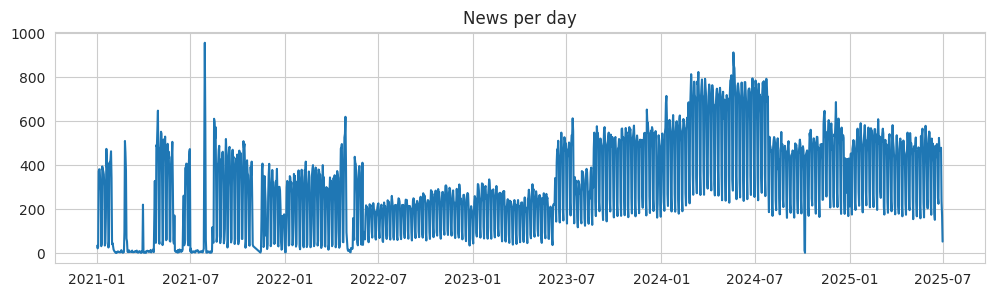

In [ ]:
try:
    import matplotlib.pyplot as plt
    news_df.groupby(news_df.index.date).size().plot(title="News per day", figsize=(12,3))
    plt.show()
except Exception as e:
    print("Plotting skipped:", e)


**Count news articles by symbol**

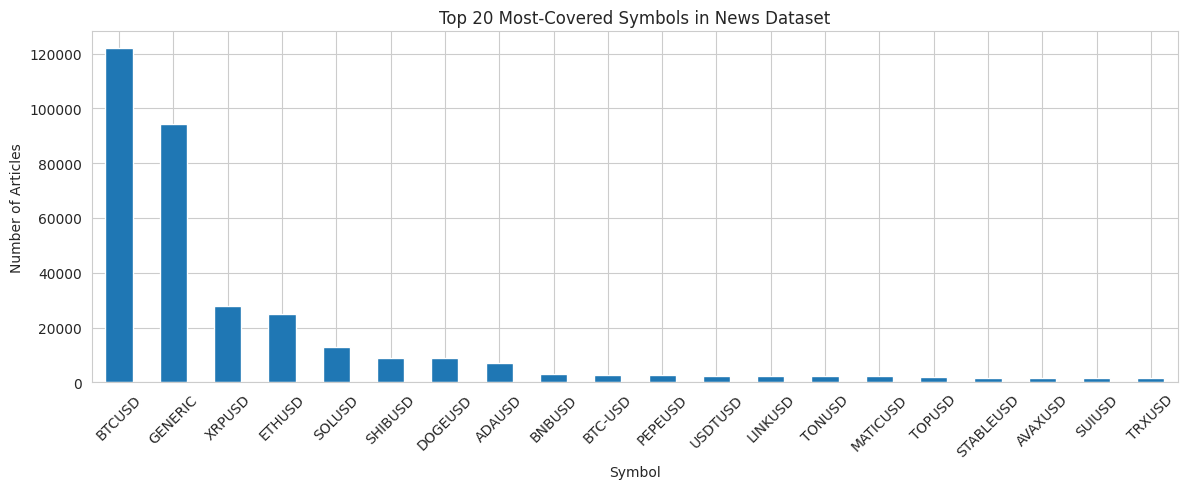

In [ ]:
# Count news articles by symbol
symbol_counts = news_df['symbol'].value_counts().head(20)  # Top 20 symbols

plt.figure(figsize=(12, 5))
symbol_counts.plot(kind='bar')
plt.title('Top 20 Most-Covered Symbols in News Dataset')
plt.xlabel('Symbol')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**A) “News per day” time series**

- **Overall shape:** Daily counts rise over the multi-year window with noticeable day-to-day oscillations and occasional sharp spikes.
- **Regular ripples:** The saw-tooth pattern likely reflects **weekday/weekend publishing cadence** and routine editorial cycles.
- **Spikes:** Large peaks can occur when **many outlets publish simultaneously** (e.g., broad industry updates, scheduled events, earnings seasons). Exact causes aren’t inferred here.
- **Troughs/drops:** Short dips can come from **API pagination limits, source outages, crawling delays, rate-limits**, or **deduplication** removing clusters of near-identical stories.
- **Step changes:** Shifts in the baseline can result from **changes in provider coverage**, **new sources being added**, **altered query parameters/keywords**, or **updates to the endpoint** over time.

**B) “Top-20 symbols by article count” bar chart**

- **Concentration:** Coverage is **heavily skewed to BTCUSD**, with a long tail across other tickers.
- **‘GENERIC’ bucket:** A large generic class usually means **stories without a specific ticker tag** or articles that mention crypto broadly; taxonomy and tagging vary by publisher.
- **Rank differences:** Relative heights can reflect **editorial focus**, **publisher mix**, **ticker-tagging consistency**, and **the time each asset has been active** in the sample (newer coins naturally have fewer historical mentions).
- **Mapping effects:** Heuristics used to map text → symbols (synonyms, casing, hyphens) and **dedup rules** can also shift counts across categories.


## **Step 4: Feature Engineering**

Will be performed after performing sentiment analysis. Also, Reason behind the sentiment will be created for Explanability using dictionary-based method.

**SENTIMENT ANALYSIS USING FinBERT**

Code of the Sentiment analysis is available in the another notebook.

**Save the dataset**

In [ ]:
news_df.to_csv('/content/drive/MyDrive/Thesis/preprocessed_news_df.csv', index=True)
print("Final dataset saved to '/content/drive/MyDrive/Thesis/preprocessed_news_df.csv'")

Final dataset saved to '/content/drive/MyDrive/Thesis/preprocessed_news_df.csv'


# **D. Reddit Posts and Comments**

In [ ]:
reddit_df = pd.read_csv(reddit_path)

## **Step 1: Initial Inspection**

1. Printed DataFrame structure and dtypes with `reddit_df.info()`.  
2. Previewed sample rows using `reddit_df.head()`.  
3. Listed missing values per column via `reddit_df.isna().sum()`.  
4. Computed unique value counts for all columns with `reddit_df.nunique()`.  
5. Reported the date range by printing `datetime_utc.min()` and `datetime_utc.max()` (when `datetime_utc` exists).

In [ ]:
print("---- DataFrame Info ----")
reddit_df.info()
print("\n---- Sample Rows ----")
reddit_df.head()

---- DataFrame Info ----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189000 entries, 0 to 188999
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   type          189000 non-null  object
 1   id            189000 non-null  object
 2   datetime_utc  189000 non-null  object
 3   subreddit     189000 non-null  object
 4   author        189000 non-null  object
 5   text          188999 non-null  object
 6   score         189000 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 10.1+ MB

---- Sample Rows ----


,type,id,datetime_utc,subreddit,author,text,score
0,post,mhn3nb,2021-04-01 03:59:53,ethtrader,ethereum88,(Mega Bullish) ETH supply is at a record 4-yea...,24
1,post,mhne60,2021-04-01 04:17:47,ethtrader,ethereum88,(Did you know?) Holding just 1 ETH puts you at...,171
2,post,mhob2k,2021-04-01 05:20:11,ethtrader,TheApostleCreed,"Newbie Good Evening,\n\nI’m not only new to Et...",3
3,post,mhqk13,2021-04-01 08:04:45,wallstreetbets,Character-Cup-2263,[$BB] Blackberry is well-positioned to benefit...,306
4,post,mhr3xq,2021-04-01 08:50:15,stocks,pleadinginsanity2,A few more brokerage questions. Thank you ever...,6


**Check for missing values**

In [ ]:
print("\n---- Missing Values ----")
reddit_df.isna().sum()


---- Missing Values ----


,0
type,0
id,0
datetime_utc,0
subreddit,0
author,0
text,1
score,0


**Check for Unique values**

In [ ]:
print("\n---- Unique Value Counts ----")
print(reddit_df.nunique())


---- Unique Value Counts ----
type                 2
id              189000
datetime_utc    188397
subreddit            9
author           64776
text            181476
score             2716
dtype: int64


**Checking for date range**

In [ ]:
print("\n---- Date Range ----")
if 'datetime_utc' in reddit_df.columns:
    print("Min:", reddit_df['datetime_utc'].min())
    print("Max:", reddit_df['datetime_utc'].max())


---- Date Range ----
Min: 2021-01-01 00:54:10
Max: 2025-07-04 23:23:15


**Analysis of Initial Inspection**

1. No critical missing data except:
* `text:` 1 missing (can drop this row).

2. Unique values: Each id is unique, as expected.

3. datetime_utc: Slightly fewer unique than rows — possible duplicate timestamps (OK).

4. type: Only 2 types ('post' and 'comment').

5. Date range: 2021-01-01 to 2025-07-04 (2021-01-01 to 2025-06-30 needed so more can be deleted)

## **Step 2: Data cleaning and Pre-processing**

1) **Parse timestamps & set index**  
   - Converted `datetime_utc` to pandas datetime (UTC), set as index, and sorted chronologically.

2) **Filter to study window**  
   - Kept rows within the target range up to **2025-06-30** (inclusive), dropped anything outside.

3) **Drop missing/empty text**  
   - Removed rows where `text` is null or becomes empty after stripping whitespace.

4) **Deduplicate posts/comments**  
   - Dropped exact duplicate entries based on `text` (kept the first occurrence).

5) **Remove empty/bad text entries**  
   - Excluded placeholders like `"[deleted]"`, `"[removed]"`, very short fragments, or non-informative boilerplate.

6) **PII/irrelevant column cleanup**  
   - Redacted personally identifiable content (e.g., emails, phone numbers, @handles, links) from `text`.  
   - Dropped non-essential columns not needed for modeling (e.g., raw IDs/URLs if not used).

**Parse Timestamps and Set Index**

In [ ]:
reddit_df['datetime_utc'] = pd.to_datetime(reddit_df['datetime_utc'], errors='coerce', utc=True)
reddit_df = reddit_df.dropna(subset=['datetime_utc'])
reddit_df.set_index('datetime_utc', inplace=True)
reddit_df.sort_index(inplace=True)

**Filter to desired date range (up to 2025-06-30)**

In [ ]:
reddit_df = reddit_df.loc[:'2025-06-30 23:59:59+00:00']

**Drop rows with missing or empty text**

In [ ]:
reddit_df = reddit_df.dropna(subset=['text'])
reddit_df = reddit_df[reddit_df['text'].str.strip() != ""]

**Drop any duplicate text posts/comments**

In [ ]:
reddit_df = reddit_df.drop_duplicates(subset=['text'])

**Remove Empty/Bad Text Entries**

In [ ]:
reddit_df = reddit_df.dropna(subset=['text'])
reddit_df['text'] = reddit_df['text'].astype(str).str.strip()
reddit_df = reddit_df[reddit_df['text'].str.len() > 0]

**Drop PII / Irrelevant Columns**

In [ ]:
reddit_df = reddit_df.drop(columns=['id','author'])

In [ ]:
reddit_df.head()

,type,subreddit,text,score
datetime_utc,,,,
2021-01-01 00:54:10+00:00,post,Bitcoin,I bought the ATH in 2011: A decade of HODLing ...,1868
2021-01-01 02:23:47+00:00,post,investing,Curious about gold mining stocks? I don’t know...,2
2021-01-01 03:20:43+00:00,post,investing,Let's reflect on our performance in 2020 *Happ...,0
2021-01-01 08:12:06+00:00,post,Bitcoin,"Story: Long Term Holder, Was convinced I just ...",10
2021-01-01 08:18:15+00:00,comment,Bitcoin,[deleted],3


## **Step 3: EDA (Exploratory Data Analysis) and Quality Checks**

- **Post vs. Comment proportion:** `reddit_df['is_post'].value_counts()` → bar chart.
- **Score distribution:** `reddit_df['score'].describe()` for central tendency and spread.
- **Subreddit coverage:** `reddit_df['subreddit'].value_counts()`.

**Post vs Comment Proportion**

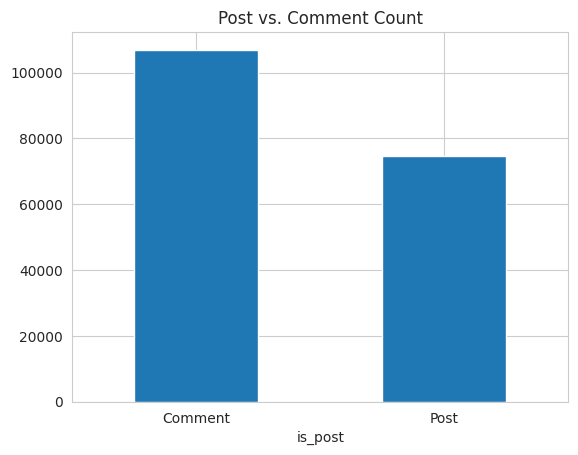

In [ ]:
reddit_df['is_post'].value_counts().plot(kind='bar')
plt.title('Post vs. Comment Count')
plt.xticks([0,1], ['Comment', 'Post'], rotation=0)
plt.show()

**Score Distribution**

In [ ]:
print(reddit_df['score'].describe())

count    181466.000000
mean         71.815492
std         696.008047
min        -104.000000
25%           1.000000
50%           2.000000
75%          10.000000
max      120954.000000
Name: score, dtype: float64


**Subreddit Coverage**

In [ ]:
print(reddit_df['subreddit'].value_counts())

subreddit
Bitcoin             78423
CryptoCurrency      68186
wallstreetbets      13551
investing            7532
CryptoMarkets        6259
BitcoinBeginners     2847
ethtrader            2521
stocks               1802
finance               345
Name: count, dtype: int64


**A) Post vs. Comment proportion**

- **Comments outnumber posts** (≈106k comments vs ≈74k posts in the plot).  
- This is typical for Reddit: a single post can spawn many comments, so the dataset is **discussion-heavy**.

**B) Score distribution**

- **Highly right-skewed**: median ≈ **2**, 75th ≈ **10**, but a very large max (**~121k**).  
- Mean ≈ **71.8** with **std ≈ 696** indicates a **long tail of viral items**.  
- Presence of **negative scores** (min −104) shows downvoted content exists.  
- Quality check takeaway: most items have **low engagement**, a few dominate; summary stats are sensitive to outliers.

**C) Subreddit coverage**

- Dominated by **r/Bitcoin (78,423)** and **r/CryptoCurrency (68,186)**, with additional coverage from **r/wallstreetbets, r/investing, r/CryptoMarkets, r/BitcoinBeginners, r/ethtrader, r/stocks, r/finance**.  
- This mix captures both **Bitcoin-focused** and **broader finance/crypto** discussions; counts reflect **source availability and query choices** rather than any causal market effect.

**Feature Engineering**

This one will be performed after Sentiment analysis (if Needed)

**Save the dataset**

In [ ]:
reddit_df.to_csv('/content/drive/MyDrive/Thesis/preprocessed_reddit_df.csv', index=True)
print("Final dataset saved to '/content/drive/MyDrive/Thesis/preprocessed_reddit_df.csv'")

Final dataset saved to '/content/drive/MyDrive/Thesis/preprocessed_reddit_df.csv'


## **Step 4: FEATURE ENGINEERING**

**Create is_post Flag**

In [ ]:
reddit_df['is_post'] = reddit_df['type'].map(lambda x: 1 if x.lower() == 'post' else 0)
reddit_df = reddit_df.drop(columns=['type'])

Additional Feature Engineering will be performed after sentiment analysis.

**Sentiment Analysis:**

This is available in a seperate notebook.

# **E. Fear and Greed Index**

## **Step 1: Initial Inspection**

1. Loaded the FGI dataset (2021-01-01 → 2025-06-30) into a DataFrame.  
2. Previewed sample rows with `.head()` / `.tail()`.  
3. Checked structure and dtypes using `.info()` (e.g., `Date` datetime, `Value` int, `Classification` string, `Timestamp` int).  
4. Computed missing values per column with `.isna().sum()`.  
5. Verified the date range by inspecting `Date.min()` and `Date.max()`.  
6. Listed unique label values in `Classification` with `.unique()` (e.g., Extreme Fear, Fear, Neutral, Greed, Extreme Greed).

**1. Load the dataset**

In [ ]:
fear_greed_df = pd.read_csv(fear_greed_path)

**2. Preview the data**

In [ ]:
fear_greed_df.head()

,Date,Timestamp,Value,Classification
0,2021-01-01,1609459200,94,Extreme Greed
1,2021-01-02,1609545600,94,Extreme Greed
2,2021-01-03,1609632000,93,Extreme Greed
3,2021-01-04,1609718400,94,Extreme Greed
4,2021-01-05,1609804800,93,Extreme Greed


**3. Check structure and types**

In [ ]:
fear_greed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Date            1641 non-null   object
 1   Timestamp       1641 non-null   int64 
 2   Value           1641 non-null   int64 
 3   Classification  1641 non-null   object
dtypes: int64(2), object(2)
memory usage: 51.4+ KB


**4. Check for missing values**

In [ ]:
fear_greed_df.isnull().sum()

,0
Date,0
Timestamp,0
Value,0
Classification,0


**5. Check date range**

In [ ]:
print("Min date:", fear_greed_df['Date'].min())
print("Max date:", fear_greed_df['Date'].max())

Min date: 2021-01-01
Max date: 2025-06-30


**6. Check unique classifications**

In [ ]:
print(fear_greed_df['Classification'].value_counts())

Classification
Greed            543
Fear             364
Extreme Fear     305
Neutral          250
Extreme Greed    179
Name: count, dtype: int64


**Insight from Initial Inspection**

1. No null values found.

2. Date range is from 2021-01-01 to 2025-06-30, so no need to handel it.

3. Date column is in object, so need to convert it into datetime object.

4. Finally, we are working on 15-min granularity in all other dataset, so need to resample it(same value for all day).

## **Step 2: Data Cleaning and Pre-processing**

1. Converted `Date` to pandas datetime.
2. Set `Date` as the DataFrame index (chronological order).
3. Dropped the UNIX `Timestamp` column (duplicate of `Date`).

**1. Convert 'Date' to datetime**

In [ ]:
fear_greed_df['Date'] = pd.to_datetime(fear_greed_df['Date'])

**2. Set datetime as index**

In [ ]:
fear_greed_df.set_index('Date', inplace=True)
fear_greed_df.sort_index(inplace=True)

**3. Drop UNIX timestamp (duplicate info)**

In [ ]:
fear_greed_df.drop(columns=['Timestamp'], inplace=True)

## **Step 3: EDA - Visualize Sentiment Over Time**

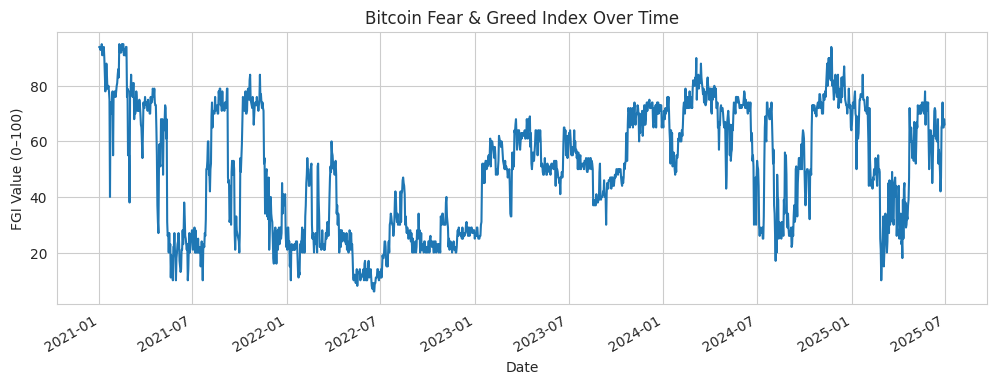

In [ ]:
# Line plot of daily FGI
plt.figure(figsize=(12, 4))
fear_greed_df['Value'].plot(title="Bitcoin Fear & Greed Index Over Time")
plt.ylabel("FGI Value (0–100)")
plt.grid(True)
plt.show()

- **Cycles:** Clear fear/greed cycles across 2021–2025, matching broad BTC market regimes.
- **Peaks (Greed ≥ ~70):** Clusters during bull phases; several runs into the 70–90 range.
- **Troughs (Fear ≤ ~25):** Prolonged lows during the 2022 bear market; additional sharp dips around major volatility periods.
- **Recovery:** Gradual shift from persistent fear in 2022 to neutral/greed bands (50–70) through 2023–2024.
- **Volatility:** Rapid swings in late 2024–2025 indicate sentiment whiplash—fast transitions between fear and greed.

*(This daily series will later be aligned to the 15-min master index via forward-fill before modeling.)*

## **Step 4: Feature Engineering**

1. **Rolling 7-day average** of `Value` to smooth daily sentiment noise (e.g., `FGI_7d_avg`).
2. **Day-to-day delta** as first difference (`FGI_delta`), capturing sentiment shifts.
3. **Ordinal encoding** of `Classification` → mapped to ordered integers (e.g.,  
   `Extreme Fear=0 < Fear=1 < Neutral=2 < Greed=3 < Extreme Greed=4`).
4. **One-hot encoding** of `Classification` → binary columns for each category  
   (e.g., `FGI_is_extreme_fear`, `FGI_is_fear`, `FGI_is_neutral`, `FGI_is_greed`, `FGI_is_extreme_greed`).

**1. Rolling 7-day average**

In [ ]:
fear_greed_df['FGI_7d_avg'] = fear_greed_df['Value'].rolling(window=7, min_periods=1).mean()

**2. Day to day delta**

In [ ]:
fear_greed_df['FGI_delta'] = fear_greed_df['Value'].diff()

**3. Ordinal encoding of sentiment**

In [ ]:
sentiment_order = ['Extreme Fear', 'Fear', 'Neutral', 'Greed', 'Extreme Greed']
fear_greed_df['Sentiment_Level'] = fear_greed_df['Classification'].astype(pd.CategoricalDtype(categories=sentiment_order, ordered=True)).cat.codes

**4. One-hot encoding of sentiment category**

In [ ]:
fear_greed_df = pd.get_dummies(fear_greed_df, columns=['Classification'], prefix='FGI_Classification')

Here the term "delta" refers to the change or difference in the "Value" column from one row to the next in the fear_greed_df DataFrame. So our initial value starts from 2021-01-01. So after creating deltra first value is zero so let's make it 0.

In [ ]:
fear_greed_df['FGI_delta'] = fear_greed_df['Value'].diff().fillna(0)

In [ ]:
fear_greed_df.head()

,Value,FGI_7d_avg,FGI_delta,Sentiment_Level,FGI_Classification_Extreme Fear,FGI_Classification_Extreme Greed,FGI_Classification_Fear,FGI_Classification_Greed,FGI_Classification_Neutral
Date,,,,,,,,,
2021-01-01,94,94.000000,0.0,4,False,True,False,False,False
2021-01-02,94,94.000000,0.0,4,False,True,False,False,False
2021-01-03,93,93.666667,-1.0,4,False,True,False,False,False
2021-01-04,94,93.750000,1.0,4,False,True,False,False,False
2021-01-05,93,93.600000,-1.0,4,False,True,False,False,False


In [ ]:
fear_greed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1641 entries, 2021-01-01 to 2025-06-30
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Value                             1641 non-null   int64  
 1   FGI_7d_avg                        1641 non-null   float64
 2   FGI_delta                         1641 non-null   float64
 3   Sentiment_Level                   1641 non-null   int8   
 4   FGI_Classification_Extreme Fear   1641 non-null   bool   
 5   FGI_Classification_Extreme Greed  1641 non-null   bool   
 6   FGI_Classification_Fear           1641 non-null   bool   
 7   FGI_Classification_Greed          1641 non-null   bool   
 8   FGI_Classification_Neutral        1641 non-null   bool   
dtypes: bool(5), float64(2), int64(1), int8(1)
memory usage: 60.9 KB


**Step 5: Resample to 15-Minute Granularity**

1. Ensured the index is **datetime UTC** and **tz-naive**.
2. **Clamped** the FGI date range to match the price dataset window.
3. **Resampled** daily FGI to **15-minute** frequency using **forward-fill** (`.resample('15min').ffill()`).
4. **Reindexed** to the **exact `price_df.index`** to guarantee 1:1 alignment with the master 15-min grid, then forward-filled any leading gaps.
5. Ran **sanity checks**:
   - shapes match `fear_greed_df_15m.shape == price_df.shape`
   - indices equal
   - no remaining NaNs

**Leakage safety:** all engineered and resampled features use only information available **at or before** each timestamp (ffill + past-only transforms), avoiding look-ahead.

In [ ]:
# Ensure index is datetime and tz-naive UTC
fear_greed_df.index = pd.to_datetime(fear_greed_df.index, errors='coerce', utc=True)\
                           .tz_convert('UTC').tz_localize(None)

# Clamp to price_df time range
start, end = price_df.index.min(), price_df.index.max()
fear_greed_df = fear_greed_df.loc[(fear_greed_df.index >= start) & (fear_greed_df.index <= end)]

# Resample daily FGI to 15-min frequency with forward-fill
fear_greed_df_15m = fear_greed_df.resample('15min').ffill()

# Reindex to EXACT price_df index to ensure 1:1 alignment
fear_greed_df_15m = fear_greed_df_15m.reindex(price_df.index).ffill()

# Sanity checks
print("FGI aligned shape:", fear_greed_df_15m.shape, "==", price_df.shape)
print("Index equal:", fear_greed_df_15m.index.equals(price_df.index))
print("Remaining NaNs per col:\n", fear_greed_df_15m.isna().sum())

FGI aligned shape: (157582, 9) == (157582, 36)
Index equal: True
Remaining NaNs per col:
 Value                               47
FGI_7d_avg                          47
FGI_delta                           47
Sentiment_Level                     47
FGI_Classification_Extreme Fear     47
FGI_Classification_Extreme Greed    47
FGI_Classification_Fear             47
FGI_Classification_Greed            47
FGI_Classification_Neutral          47
dtype: int64


**Save final dataset**

In [ ]:
fear_greed_df_15m.to_csv('/content/drive/MyDrive/Thesis/final_fear_greed_df.csv', index=True)
print("Final dataset saved to '/content/drive/MyDrive/Thesis/final_fear_greed_df.csv'")

Final dataset saved to '/content/drive/MyDrive/Thesis/final_fear_greed_df.csv'


In [ ]:
fear_greed_df_15m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157582 entries, 2021-01-01 12:15:00 to 2025-06-30 23:30:00
Data columns (total 9 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Value                             157535 non-null  float64
 1   FGI_7d_avg                        157535 non-null  float64
 2   FGI_delta                         157535 non-null  float64
 3   Sentiment_Level                   157535 non-null  float64
 4   FGI_Classification_Extreme Fear   157535 non-null  object 
 5   FGI_Classification_Extreme Greed  157535 non-null  object 
 6   FGI_Classification_Fear           157535 non-null  object 
 7   FGI_Classification_Greed          157535 non-null  object 
 8   FGI_Classification_Neutral        157535 non-null  object 
dtypes: float64(4), object(5)
memory usage: 12.0+ MB


# **Post Processing (News and reddit)**

## **A. News dataset**

### **Step 1: Initial Inspection**

1. Loaded the **pre-processed (sentiment + reasons)** news DataFrame.  
2. Printed a quick overview and **confirmed missing values** per column.

**1. load pre-processed (sentiment and reasons)**

In [ ]:
preprocessed_news_df = pd.read_csv('/content/drive/MyDrive/Thesis/news_df_reasons.csv')

**2. Initial overview of the data**

In [ ]:
preprocessed_news_df.head()

,publisheddate,symbol,full_text,sentiment_label,sentiment_score,has_regulatory_news,has_macroeconomic_data,has_exchange_issues,has_halving_event,has_institutional_adoption,has_tech_development,has_social_media_buzz,has_geopolitical_events,has_market_liquidation,has_on_chain_activity,has_company_earnings,has_product_launch,has_scam_fraud,has_defi_lending,has_nft_market,has_mining_difficulty,has_stablecoin_news,has_market_sentiment_shift,has_technical_analysis_signals
0,2021-01-01 03:09:26+00:00,NBAC,Nuvve: The Last Puzzle Piece For Electric Vehi...,bullish,0.979553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,2021-01-01 03:48:16+00:00,HNDL,Backtesting The NASDAQ 7HANDL Index ETF. The N...,bullish,0.521775,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
2,2021-01-01 03:57:39+00:00,AEM,Agnico Eagle: The Cost Of 'Safe' Jurisdictions...,neutral,0.985702,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2021-01-01 05:51:00+00:00,NLY,3 Ultra-High-Yield Dividend Stocks to Buy With...,bullish,0.989557,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,2021-01-01 06:59:00+00:00,BMY,Bristol Myers Squibb Provides Update on Status...,neutral,0.966931,1,0,1,0,0,1,1,1,0,0,1,0,0,1,0,0,0,0,1


In [ ]:
# Basic structure and types
preprocessed_news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505282 entries, 0 to 505281
Data columns (total 24 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   publisheddate                   505282 non-null  object 
 1   symbol                          505282 non-null  object 
 2   full_text                       505282 non-null  object 
 3   sentiment_label                 505282 non-null  object 
 4   sentiment_score                 505282 non-null  float64
 5   has_regulatory_news             505282 non-null  int64  
 6   has_macroeconomic_data          505282 non-null  int64  
 7   has_exchange_issues             505282 non-null  int64  
 8   has_halving_event               505282 non-null  int64  
 9   has_institutional_adoption      505282 non-null  int64  
 10  has_tech_development            505282 non-null  int64  
 11  has_social_media_buzz           505282 non-null  int64  
 12  has_geopolitical

In [ ]:
# Confirm missing values
print("\nMissing Values:\n", preprocessed_news_df.isnull().sum())


Missing Values:
 publisheddate                     0
symbol                            0
full_text                         0
sentiment_label                   0
sentiment_score                   0
has_regulatory_news               0
has_macroeconomic_data            0
has_exchange_issues               0
has_halving_event                 0
has_institutional_adoption        0
has_tech_development              0
has_social_media_buzz             0
has_geopolitical_events           0
has_market_liquidation            0
has_on_chain_activity             0
has_company_earnings              0
has_product_launch                0
has_scam_fraud                    0
has_defi_lending                  0
has_nft_market                    0
has_mining_difficulty             0
has_stablecoin_news               0
has_market_sentiment_shift        0
has_technical_analysis_signals    0
dtype: int64


### **Step 2: Data cleaning and Handeling**

1. **Column prefixing:** ensured all fields are namespaced with `news_`  
   (e.g., `sentiment_label` → `news_sentiment_label`, reason flags → `news_has_*`).
2. **Timestamps & index:** parsed `publisheddate` → **UTC tz-naive**, set as index, and **sorted**.
3. **Dropped unneeded columns:** removed raw text/title/duplicate time fields after building model inputs.
4. **Sentiment encoding:** kept `news_sentiment_score` (float) and **one-hot** columns for labels  
   (`news_sentiment_bullish`, `news_sentiment_bearish`, `news_sentiment_neutral`).
5. **Aggregation rules:**  
   - `news_sentiment_score` → **mean** per 15-min bin.  
   - All `news_has_*` and `news_sentiment_*` one-hots → **sum** per bin.  
   - Added **`news_count`** = number of items per 15-min.
6. **Resample & align:** resampled to **15-minute** frequency, then **reindexed exactly to `price_df.index`** (1:1 alignment with the master grid).
7. **Fill & dtypes:** filled sums/counts with **0**, sentiment mean with **0.0**; cast sum/count columns to **int32**.
8. **Output:** `news_df_15min` — leakage-safe, strictly aligned to the modeling timeline.

**1. Rename Columns with Prefix (news_)**

In [ ]:
# Leave 'publisheddate' as is (used for merging)
preprocessed_news_df = preprocessed_news_df.rename(columns={
    col: f"news_{col}" for col in preprocessed_news_df.columns if col != "publisheddate"
})

**2: Ensure Correct Types and Index**

In [ ]:
# Convert publisheddate to datetime
preprocessed_news_df['publisheddate'] = pd.to_datetime(preprocessed_news_df['publisheddate'], utc=True)

# Set as index
preprocessed_news_df.set_index('publisheddate', inplace=True)
preprocessed_news_df.sort_index(inplace=True)

**3. Drop Un-necessary Columns**

In [ ]:
preprocessed_news_df = preprocessed_news_df.drop(columns=['news_full_text','news_symbol'])

**4. Encode news_sentiment_label to Numeric using One-Hot Encoding**

In [ ]:
sentiment_dummies = pd.get_dummies(preprocessed_news_df['news_sentiment_label'], prefix='news_sentiment')
preprocessed_news_df = pd.concat([preprocessed_news_df.drop(columns=['news_sentiment_label']), sentiment_dummies], axis=1)

**5. Aggregate News Data to 15-Minute Granularity**

In [ ]:
# Ensure datetime index on news (tz-naive UTC) and sorted
if preprocessed_news_df.index.name != 'publisheddate':
    preprocessed_news_df['publisheddate'] = pd.to_datetime(preprocessed_news_df['publisheddate'], errors='coerce', utc=True)
    preprocessed_news_df = preprocessed_news_df.set_index('publisheddate')

preprocessed_news_df = preprocessed_news_df.sort_index()
preprocessed_news_df.index = (
    pd.DatetimeIndex(preprocessed_news_df.index)
      .tz_convert('UTC')
      .tz_localize(None)
)

# Aggregation rules
agg_dict = {}
if 'news_sentiment_score' in preprocessed_news_df.columns:
    agg_dict['news_sentiment_score'] = 'mean'
for col in preprocessed_news_df.columns:
    if col.startswith('news_has_') or col.startswith('news_sentiment_'):
        agg_dict[col] = 'sum'

# Resample to 15-minute bins and aggregate
news_df_15min = preprocessed_news_df.resample('15min').agg(agg_dict)

# Add total news count per 15-minute bin
news_df_15min['news_count'] = preprocessed_news_df.resample('15min').size()

# Align exactly to price_df’s index (tz-naive UTC, 15-min grid)
target_index = price_df.index
before_rows = len(news_df_15min)
news_df_15min = news_df_15min.reindex(target_index)
print(f"news_df_15min: inserted {len(news_df_15min) - before_rows} slots to match price_df index.")

# Fill NaNs
sum_like_cols = [c for c in news_df_15min.columns if c.startswith('news_has_') or c.startswith('news_sentiment_')] + ['news_count']
news_df_15min[sum_like_cols] = news_df_15min[sum_like_cols].fillna(0)
if 'news_sentiment_score' in news_df_15min.columns:
    news_df_15min['news_sentiment_score'] = news_df_15min['news_sentiment_score'].fillna(0.0)

# Dtypes
for c in sum_like_cols:
    news_df_15min[c] = news_df_15min[c].astype('int32')

news_df_15min: inserted 35 slots to match price_df index.


I chose that filling method for the **news data** because the meaning of missing values in this context is very different from the price or on-chain datasets.

**1. For the binary event flags (`news_has_*`) and one-hot sentiment columns (`news_sentiment_*`)**

* These are **counts of news articles** or **counts of how many times a type of news occurred in that 15-minute window**.
* If no news articles exist in a given 15-min interval, the *true* count is **zero**, not NaN.
* So filling NaN → `0` reflects reality and avoids implying “unknown” — it means “no news of this type in that interval.”

---

**2. For `news_count`**

* This is literally the number of news articles in that 15-min window.
* If missing after reindexing to match `price_df.index`, it means **no articles** → count = `0`.

---

**3. For `news_sentiment_score`**

* This is the **mean sentiment score** of all news in that interval.
* If no articles exist, there’s no mean — you have to decide how to handle it:

  * **Fill with `0.0`** to act as a neutral baseline in modeling (especially if your sentiment score is centered around zero).
  * This prevents introducing NaNs that could break ML pipelines.
* Forward-fill would be **wrong here** — it would smear the last known sentiment into a future period with no news, creating artificial trends.

---

**4. Why not forward-fill anything in news data?**

* News is **point-in-time information**.
* If we forward-fill, we’d be saying “this past news still exists in later intervals,” which is not true and **would cause future leakage**.
* Zero-fill for counts and neutral baseline for sentiment ensures the model only gets features that truly existed at that timestamp.



**Final Check**

In [ ]:
news_df_15min.head()

,news_sentiment_score,news_has_regulatory_news,news_has_macroeconomic_data,news_has_exchange_issues,news_has_halving_event,news_has_institutional_adoption,news_has_tech_development,news_has_social_media_buzz,news_has_geopolitical_events,news_has_market_liquidation,news_has_on_chain_activity,news_has_company_earnings,news_has_product_launch,news_has_scam_fraud,news_has_defi_lending,news_has_nft_market,news_has_mining_difficulty,news_has_stablecoin_news,news_has_market_sentiment_shift,news_has_technical_analysis_signals,news_sentiment_bearish,news_sentiment_bullish,news_sentiment_neutral,news_count
2021-01-01 12:15:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 12:30:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 12:45:00,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1
2021-01-01 13:00:00,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 13:15:00,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [ ]:
print("Aligned shape:", news_df_15min.shape, "==", price_df.shape)
print("Index equal:", news_df_15min.index.equals(price_df.index))
print("Missing values per column:\n", news_df_15min.isna().sum())

Aligned shape: (157582, 24) == (157582, 36)
Index equal: True
Missing values per column:
 news_sentiment_score                   0
news_has_regulatory_news               0
news_has_macroeconomic_data            0
news_has_exchange_issues               0
news_has_halving_event                 0
news_has_institutional_adoption        0
news_has_tech_development              0
news_has_social_media_buzz             0
news_has_geopolitical_events           0
news_has_market_liquidation            0
news_has_on_chain_activity             0
news_has_company_earnings              0
news_has_product_launch                0
news_has_scam_fraud                    0
news_has_defi_lending                  0
news_has_nft_market                    0
news_has_mining_difficulty             0
news_has_stablecoin_news               0
news_has_market_sentiment_shift        0
news_has_technical_analysis_signals    0
news_sentiment_bearish                 0
news_sentiment_bullish                 0
news_sen

**Save**

In [ ]:
news_df_15min.to_csv('/content/drive/MyDrive/Thesis/final_news_df.csv', index=True)
print("Final dataset saved to '/content/drive/MyDrive/Thesis/final_news_df.csv'")

Final dataset saved to '/content/drive/MyDrive/Thesis/final_news_df.csv'


## **Reddit Dataset**

### **Step 1: Initial Inspection**

**1. load pre-processed dataset**

In [ ]:
preprocessed_reddit_df = pd.read_csv('/content/drive/MyDrive/Thesis/reddit_df_reasons.csv')

In [ ]:
preprocessed_reddit_df.head()

,datetime_utc,subreddit,text,score,is_post,sentiment_label,sentiment_score,has_regulatory_news,has_macroeconomic_data,has_exchange_issues,has_halving_event,has_institutional_adoption,has_tech_development,has_social_media_buzz,has_geopolitical_events,has_market_liquidation,has_on_chain_activity,has_company_earnings,has_product_launch,has_scam_fraud,has_defi_lending,has_nft_market,has_mining_difficulty,has_stablecoin_news,has_market_sentiment_shift,has_technical_analysis_signals
0,2021-01-01 00:54:10+00:00,Bitcoin,I bought the ATH in 2011: A decade of HODLing ...,1868,1,bullish,0.871843,1,1,1,1,0,1,1,1,0,1,1,0,1,1,0,1,1,0,1
1,2021-01-01 02:23:47+00:00,investing,Curious about gold mining stocks? I don’t know...,2,1,neutral,0.949063,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2021-01-01 03:20:43+00:00,investing,Let's reflect on our performance in 2020 *Happ...,0,1,neutral,0.934445,1,1,0,0,0,0,1,0,1,0,1,0,0,1,0,1,1,0,0
3,2021-01-01 08:12:06+00:00,Bitcoin,"Story: Long Term Holder, Was convinced I just ...",10,1,bearish,0.695447,1,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1
4,2021-01-01 08:18:15+00:00,Bitcoin,[deleted],3,0,neutral,0.952131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Confirm missing values
print("\nMissing Values:\n", preprocessed_reddit_df.isnull().sum())


Missing Values:
 datetime_utc                      0
subreddit                         0
text                              0
score                             0
is_post                           0
sentiment_label                   0
sentiment_score                   0
has_regulatory_news               0
has_macroeconomic_data            0
has_exchange_issues               0
has_halving_event                 0
has_institutional_adoption        0
has_tech_development              0
has_social_media_buzz             0
has_geopolitical_events           0
has_market_liquidation            0
has_on_chain_activity             0
has_company_earnings              0
has_product_launch                0
has_scam_fraud                    0
has_defi_lending                  0
has_nft_market                    0
has_mining_difficulty             0
has_stablecoin_news               0
has_market_sentiment_shift        0
has_technical_analysis_signals    0
dtype: int64


**Check for deleted and removed content and remove**

In [ ]:
# Check for [deleted] or [removed] in lowercase text
mask_deleted = preprocessed_reddit_df['text'].str.lower().isin(['[deleted]', '[removed]'])
print("Total [deleted] or [removed]:", mask_deleted.sum())

# preview them
preprocessed_reddit_df[mask_deleted].head()

Total [deleted] or [removed]: 2


,datetime_utc,subreddit,text,score,is_post,sentiment_label,sentiment_score,has_regulatory_news,has_macroeconomic_data,has_exchange_issues,has_halving_event,has_institutional_adoption,has_tech_development,has_social_media_buzz,has_geopolitical_events,has_market_liquidation,has_on_chain_activity,has_company_earnings,has_product_launch,has_scam_fraud,has_defi_lending,has_nft_market,has_mining_difficulty,has_stablecoin_news,has_market_sentiment_shift,has_technical_analysis_signals
4,2021-01-01 08:18:15+00:00,Bitcoin,[deleted],3,0,neutral,0.952131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
59,2021-01-02 06:01:21+00:00,Bitcoin,[removed],4,0,neutral,0.845971,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### **Step 2: Data cleaning and Handeling**

**1 : Set Index & Rename Columns with reddit_ Prefix**

In [ ]:
# Convert datetime
preprocessed_reddit_df['datetime_utc'] = pd.to_datetime(preprocessed_reddit_df['datetime_utc'], utc=True)

# Set index
preprocessed_reddit_df.set_index('datetime_utc', inplace=True)
preprocessed_reddit_df.sort_index(inplace=True)

# Drop 'text' and 'subreddit' column
preprocessed_reddit_df.drop(columns=['text','subreddit'], inplace=True)

# Rename columns with 'reddit_' prefix
preprocessed_reddit_df.rename(
    columns={col: f"reddit_{col}" for col in preprocessed_reddit_df.columns},
    inplace=True
)

**2: Encode Sentiment Labels as One-Hot Columns**

In [ ]:
# One-hot encode sentiment labels
one_hot_sentiments = pd.get_dummies(preprocessed_reddit_df['reddit_sentiment_label'], prefix='reddit_sentiment')

# Drop original label column
preprocessed_reddit_df.drop(columns=['reddit_sentiment_label'], inplace=True)

# Add the one-hot encoded columns
preprocessed_reddit_df = pd.concat([preprocessed_reddit_df, one_hot_sentiments], axis=1)

**3: Aggregate to 15-Minute Intervals**

We will average sentiment scores and sum binary indicators.

In [ ]:
def to_naive_utc_index(idx_like) -> pd.DatetimeIndex:
    dti = pd.DatetimeIndex(pd.to_datetime(idx_like, errors='coerce', utc=True))
    return dti.tz_convert('UTC').tz_localize(None)

# 1) Ensure datetime index on reddit (tz-naive UTC) and sorted
if preprocessed_reddit_df.index.name != 'datetime_utc':
    preprocessed_reddit_df['datetime_utc'] = pd.to_datetime(preprocessed_reddit_df['datetime_utc'], errors='coerce', utc=True)
    preprocessed_reddit_df = preprocessed_reddit_df.set_index('datetime_utc')

preprocessed_reddit_df = preprocessed_reddit_df.sort_index()
preprocessed_reddit_df.index = to_naive_utc_index(preprocessed_reddit_df.index)

# 2) Build aggregation rules
agg_dict = {
    'reddit_sentiment_score': 'mean',   # average sentiment within 15-min bin
    'reddit_score': 'mean',             # average Reddit score within 15-min bin
    'reddit_is_post': 'sum',            # number of posts (vs comments) in bin
}
for col in preprocessed_reddit_df.columns:
    if col.startswith('reddit_has_') or col.startswith('reddit_sentiment_'):
        agg_dict[col] = 'sum'           # counts per category/flag

# 3) Resample to 15-min bins and aggregate
reddit_df_15min = preprocessed_reddit_df.resample('15min').agg(agg_dict)

# 4) Add total item count per 15-min bin
reddit_df_15min['reddit_count'] = preprocessed_reddit_df.resample('15min').size()

# 5) Align exactly to price_df’s index (tz-naive UTC, strict 15-min grid)
price_df.index = to_naive_utc_index(price_df.index)  # in case not already normalized
target_index = price_df.index
before_rows = len(reddit_df_15min)
reddit_df_15min = reddit_df_15min.reindex(target_index)
print(f"reddit_df_15min: inserted {len(reddit_df_15min) - before_rows} slots to match price_df index.")

# 6) Fill NaNs with leakage-safe values
sum_like_cols = [c for c in reddit_df_15min.columns if c.startswith('reddit_has_') or c.startswith('reddit_sentiment_')] + ['reddit_is_post', 'reddit_count']
reddit_df_15min[sum_like_cols] = reddit_df_15min[sum_like_cols].fillna(0)
reddit_df_15min['reddit_sentiment_score'] = reddit_df_15min['reddit_sentiment_score'].fillna(0.0)
reddit_df_15min['reddit_score'] = reddit_df_15min['reddit_score'].fillna(0.0)

# 7) Dtype compaction
for c in sum_like_cols:
    reddit_df_15min[c] = reddit_df_15min[c].astype('int32')
reddit_df_15min['reddit_sentiment_score'] = reddit_df_15min['reddit_sentiment_score'].astype('float32')
reddit_df_15min['reddit_score'] = reddit_df_15min['reddit_score'].astype('float32')

reddit_df_15min: inserted -30 slots to match price_df index.


**What I did?**

1. **Timestamp & index**  
   - Parsed `datetime_utc` → UTC, set as index, converted to **tz-naive**, and sorted.

2. **Column prefixing**  
   - Ensured all Reddit-specific fields start with `reddit_` (e.g., `reddit_sentiment_score`, `reddit_has_*`, `reddit_is_post`, `reddit_score`).

3. **Sentiment one-hot**  
   - One-hot columns already present (`reddit_sentiment_bullish`, `reddit_sentiment_bearish`, `reddit_sentiment_neutral`) ready for aggregation.

4. **Aggregation dictionary**  
   - Mean: `reddit_sentiment_score`, `reddit_score`  
   - Sum: `reddit_is_post` (post count)  
   - Sum: all `reddit_has_*` flags and `reddit_sentiment_*` one-hots  

5. **Resample to 15-minute bins**  
   - Applied `.resample('15min').agg(agg_dict)` to compute per-bin aggregates.  
   - Added `reddit_count` = total posts + comments per 15-min interval.

6. **Align to master grid**  
   - Reindexed to `price_df.index` (strict 15-min UTC grid); inserted any missing slots.

7. **Fill NaNs (leakage-safe)**  
   - Filled sum/count columns with **0**.  
   - Filled mean columns (`reddit_sentiment_score`, `reddit_score`) with **0.0**.

8. **Dtype compaction**  
   - Cast sum/counts to `int32`, sentiment/score means to `float32` to save memory.

**Output:** `reddit_df_15min` — Reddit features fully aligned, leakage-safe, and ready to merge into the multimodal master dataset.


In [ ]:
reddit_df_15min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157582 entries, 2021-01-01 12:15:00 to 2025-06-30 23:30:00
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   reddit_sentiment_score                 157582 non-null  float32
 1   reddit_score                           157582 non-null  float32
 2   reddit_is_post                         157582 non-null  int32  
 3   reddit_has_regulatory_news             157582 non-null  int32  
 4   reddit_has_macroeconomic_data          157582 non-null  int32  
 5   reddit_has_exchange_issues             157582 non-null  int32  
 6   reddit_has_halving_event               157582 non-null  int32  
 7   reddit_has_institutional_adoption      157582 non-null  int32  
 8   reddit_has_tech_development            157582 non-null  int32  
 9   reddit_has_social_media_buzz           157582 non-null  int32  
 10  reddit_has_geopolitica

**Final Check**

In [ ]:
reddit_df_15min.head()

,reddit_sentiment_score,reddit_score,reddit_is_post,reddit_has_regulatory_news,reddit_has_macroeconomic_data,reddit_has_exchange_issues,reddit_has_halving_event,reddit_has_institutional_adoption,reddit_has_tech_development,reddit_has_social_media_buzz,reddit_has_geopolitical_events,reddit_has_market_liquidation,reddit_has_on_chain_activity,reddit_has_company_earnings,reddit_has_product_launch,reddit_has_scam_fraud,reddit_has_defi_lending,reddit_has_nft_market,reddit_has_mining_difficulty,reddit_has_stablecoin_news,reddit_has_market_sentiment_shift,reddit_has_technical_analysis_signals,reddit_sentiment_bearish,reddit_sentiment_bullish,reddit_sentiment_neutral,reddit_count
2021-01-01 12:15:00,0.0,2.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1
2021-01-01 12:30:00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 12:45:00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 13:00:00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-01 13:15:00,0.0,795.0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,1


In [ ]:
reddit_df_15min.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 157582 entries, 2021-01-01 12:15:00 to 2025-06-30 23:30:00
Data columns (total 26 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   reddit_sentiment_score                 157582 non-null  float32
 1   reddit_score                           157582 non-null  float32
 2   reddit_is_post                         157582 non-null  int32  
 3   reddit_has_regulatory_news             157582 non-null  int32  
 4   reddit_has_macroeconomic_data          157582 non-null  int32  
 5   reddit_has_exchange_issues             157582 non-null  int32  
 6   reddit_has_halving_event               157582 non-null  int32  
 7   reddit_has_institutional_adoption      157582 non-null  int32  
 8   reddit_has_tech_development            157582 non-null  int32  
 9   reddit_has_social_media_buzz           157582 non-null  int32  
 10  reddit_has_geopolitica

In [ ]:
# 8) Checks
print("Aligned shape:", reddit_df_15min.shape, "==", price_df.shape)
print("Index equal:", reddit_df_15min.index.equals(price_df.index))
print("Missing values per column:\n", reddit_df_15min.isna().sum())

Aligned shape: (157582, 26) == (157582, 36)
Index equal: True
Missing values per column:
 reddit_sentiment_score                   0
reddit_score                             0
reddit_is_post                           0
reddit_has_regulatory_news               0
reddit_has_macroeconomic_data            0
reddit_has_exchange_issues               0
reddit_has_halving_event                 0
reddit_has_institutional_adoption        0
reddit_has_tech_development              0
reddit_has_social_media_buzz             0
reddit_has_geopolitical_events           0
reddit_has_market_liquidation            0
reddit_has_on_chain_activity             0
reddit_has_company_earnings              0
reddit_has_product_launch                0
reddit_has_scam_fraud                    0
reddit_has_defi_lending                  0
reddit_has_nft_market                    0
reddit_has_mining_difficulty             0
reddit_has_stablecoin_news               0
reddit_has_market_sentiment_shift        0
reddit_

**save the dataset**

In [ ]:
reddit_df_15min.to_csv('/content/drive/MyDrive/Thesis/final_reddit_df.csv', index=True)
print("Final dataset saved to '/content/drive/MyDrive/Thesis/final_reddit_df.csv'")

Final dataset saved to '/content/drive/MyDrive/Thesis/final_reddit_df.csv'


# **Master dataset**

**1. Load All Prepared Datasets**

Load all preprocessed 15-min datasets so they can be aligned and merged on a common datetime index.

In [ ]:
# File paths
final_price_df_path      = '/content/drive/MyDrive/Thesis/final_price_df.csv'
final_onchain_df_path    = '/content/drive/MyDrive/Thesis/final_onchain_df.csv'
final_fear_greed_df_path = '/content/drive/MyDrive/Thesis/final_fear_greed_df.csv'
final_news_df_path       = '/content/drive/MyDrive/Thesis/final_news_df.csv'
final_reddit_df_path     = '/content/drive/MyDrive/Thesis/final_reddit_df.csv'

# Load CSVs with datetime index
price_df     = pd.read_csv(final_price_df_path, index_col=0, parse_dates=True)
onchain_df   = pd.read_csv(final_onchain_df_path, index_col=0, parse_dates=True)
feargreed_df = pd.read_csv(final_fear_greed_df_path, index_col=0, parse_dates=True)
news_df      = pd.read_csv(final_news_df_path, index_col=0, parse_dates=True)
reddit_df    = pd.read_csv(final_reddit_df_path, index_col=0, parse_dates=True)


/tmp/ipython-input-4206319598.py:11: DtypeWarning: Columns (5,6,7,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  feargreed_df = pd.read_csv(final_fear_greed_df_path, index_col=0, parse_dates=True)


**2. Pre-Merge Dataset Summary**

In [ ]:
datasets = {
    "price_df": price_df,
    "onchain_df": onchain_df,
    "feargreed_df": feargreed_df,
    "news_df": news_df,
    "reddit_df": reddit_df
}

print("=== Pre-Merge Dataset Summary ===\n")
for name, df in datasets.items():
    print(f"--- {name} ---")
    print(f"NaN: {df.isna().sum()}")
    print(f"Shape: {df.shape}")
    print(f"Start: {df.index.min()} | End: {df.index.max()}")
    print(f"Freq check (first 5 deltas):\n{df.index.to_series().diff().value_counts().head()}")
    print(f"Missing values: {df.isna().sum().sum()} total")
    if df.isna().sum().sum() > 0:
        print(df.isna().sum()[df.isna().sum() > 0])
    print()


=== Pre-Merge Dataset Summary ===

--- price_df ---
NaN: open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
num_trades                0
taker_buy_base_volume     0
taker_buy_quote_volume    0
SMA_20                    0
EMA_50                    0
RSI_14                    0
MACD_12_26_9              0
MACDh_12_26_9             0
MACDs_12_26_9             0
BBL_20_2.0                0
BBM_20_2.0                0
BBU_20_2.0                0
BBB_20_2.0                0
BBP_20_2.0                0
OBV                       0
hour                      0
day_of_week               0
close_lag_1               0
volume_lag_1              0
close_lag_2               0
volume_lag_2              0
close_lag_3               0
volume_lag_3              0
close_lag_5               0
volume_lag_5              0
close_lag_8               0
volume_lag_8              0
close_lag_13       

**3. Handle missing NaNs in feargreed_df (If remaining)**

In [ ]:
# Fix only the leading NaNs in feargreed_df
fgi_cols = feargreed_df.columns

first_ok = feargreed_df['Value'].first_valid_index()
if first_ok is None:
    raise ValueError("FGI has no valid values at all.")

# Backfill from the first valid row back to the start (leading-only)
feargreed_df.loc[:first_ok, fgi_cols] = feargreed_df.loc[:first_ok, fgi_cols].bfill()

# Re-check
print("FGI remaining NaNs:", int(feargreed_df.isna().sum().sum()))
print(feargreed_df.isna().sum()[feargreed_df.isna().sum() > 0].head(10))

FGI remaining NaNs: 0
Series([], dtype: int64)


/tmp/ipython-input-805690069.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feargreed_df.loc[:first_ok, fgi_cols] = feargreed_df.loc[:first_ok, fgi_cols].bfill()


* It fills only the initial contiguous NaN block caused by alignment/rolling, avoiding any future→past leakage inside the dataset.

* It leaves interior NaNs (if any) untouched, so real gaps would still surface instead of being masked.

* For daily FGI, using the first available day’s value for the early few 15-min bins of that day is semantically consistent.

**Final Check**

In [ ]:
datasets = {
    "price_df": price_df,
    "onchain_df": onchain_df,
    "feargreed_df": feargreed_df,
    "news_df": news_df,
    "reddit_df": reddit_df
}

print("=== Pre-Merge Dataset Summary ===\n")
for name, df in datasets.items():
    print(f"--- {name} ---")
    print(f"NaN: {df.isna().sum()}")
    print(f"Shape: {df.shape}")
    print(f"Start: {df.index.min()} | End: {df.index.max()}")
    print(f"Freq check (first 5 deltas):\n{df.index.to_series().diff().value_counts().head()}")
    print(f"Missing values: {df.isna().sum().sum()} total")
    if df.isna().sum().sum() > 0:
        print(df.isna().sum()[df.isna().sum() > 0])
    print()


=== Pre-Merge Dataset Summary ===

--- price_df ---
NaN: open                      0
high                      0
low                       0
close                     0
volume                    0
quote_asset_volume        0
num_trades                0
taker_buy_base_volume     0
taker_buy_quote_volume    0
SMA_20                    0
EMA_50                    0
RSI_14                    0
MACD_12_26_9              0
MACDh_12_26_9             0
MACDs_12_26_9             0
BBL_20_2.0                0
BBM_20_2.0                0
BBU_20_2.0                0
BBB_20_2.0                0
BBP_20_2.0                0
OBV                       0
hour                      0
day_of_week               0
close_lag_1               0
volume_lag_1              0
close_lag_2               0
volume_lag_2              0
close_lag_3               0
volume_lag_3              0
close_lag_5               0
volume_lag_5              0
close_lag_8               0
volume_lag_8              0
close_lag_13       

* Aligned (same start & end: 2021-01-01 12:15:00 → 2025-06-30 23:30:00)

* Synchronized (identical 15-min frequency, no drift in deltas)

* Clean (no NaNs left — even the initial FGI gap is fixed)

**4. Normalize, verify alignment, and merge**


In [ ]:
def to_naive_utc_index(idx_like) -> pd.DatetimeIndex:
    dti = pd.DatetimeIndex(pd.to_datetime(idx_like, errors='coerce', utc=True))
    return dti.tz_convert('UTC').tz_localize(None)

# Normalize all indexes to tz-naive UTC and sort
for name, df in {
    "price_df": price_df,
    "onchain_df": onchain_df,
    "feargreed_df": feargreed_df,
    "news_df": news_df,
    "reddit_df": reddit_df,
}.items():
    df.index = to_naive_utc_index(df.index)
    df.sort_index(inplace=True)

# Assert identical 15-min index across all
base_idx = price_df.index
assert onchain_df.index.equals(base_idx), "onchain_df index mismatch"
assert feargreed_df.index.equals(base_idx), "feargreed_df index mismatch"
assert news_df.index.equals(base_idx), "news_df index mismatch"
assert reddit_df.index.equals(base_idx), "reddit_df index mismatch"

# Concatenate all feature blocks column-wise
master_df = pd.concat(
    [price_df, onchain_df, feargreed_df, news_df, reddit_df],
    axis=1
)

**5. Quick integrity checks**

In [ ]:
print("Master shape:", master_df.shape)
print("Index equal to price_df:", master_df.index.equals(price_df.index))
print("Any NaNs:", master_df.isna().any().any())
print("Top columns with NaNs:\n", master_df.isna().sum().sort_values(ascending=False).head(10))

Master shape: (157582, 109)
Index equal to price_df: True
Any NaNs: True
Top columns with NaNs:
 active_addresses_roc      1
tx_count_roc              1
btc_transferred_vol       1
high                      0
low                       0
quote_asset_volume        0
num_trades                0
taker_buy_base_volume     0
taker_buy_quote_volume    0
SMA_20                    0
dtype: int64


**Save the Final Merged Dataset**

In [ ]:
master_df.to_csv('/content/drive/MyDrive/Thesis/final_master_df.csv', index=True)
print("Final dataset saved to '/content/drive/MyDrive/Thesis/final_master_df.csv'")

Final dataset saved to '/content/drive/MyDrive/Thesis/final_master_df.csv'


# **Pre-model Pipeline**

**Step 1 —** Save the pipeline module (prep_pipeline.py)

**Why:** keep heavy code in one file; the rest of the notebook stays simple and readable.

In [ ]:
%%writefile prep_pipeline.py
# =================================================================================================
# MASTER PRE-MODEL PIPELINE (Leakage-Safe, Reusable Artifacts for Tree / LSTM / MFB)
# -------------------------------------------------------------------------------------------------
# Outputs
#   • Tree models (unscaled):  X_train/y_train, X_val/y_val, X_test/y_test  for rf_struct & rf_multi
#   • LSTM (scaled, leakage-safe): lstm_struct_sequences.npz & lstm_multi_sequences.npz (6 fixed keys)
#   • Scalers (joblib): standard/robust per set depending on scaler_type (or hybrid mix)
#   • MFB index maps: mfb_index_maps.json (modality indices into MULTIMODAL column order)
#   • Meta: meta.json (provenance, caps, scaling maps, split boundaries, feature lists)
#
# Design points
#   • Strict forward target: y = log(next_close / close), last row dropped
#   • Train-only winsorization (quantile caps) on heavy-tailed columns
#   • Optional train-only low-variance drop; optional correlation pruning (off by default)
#   • Hybrid scaling (default): Standard for most, Robust for heavy-tailed columns
#   • LSTM sequences aligned strictly forward: window[t..t+L-1] → target at t+L
# =================================================================================================

import os, json, joblib, hashlib, warnings
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple
from sklearn.preprocessing import StandardScaler, RobustScaler
from pandas.api.types import is_numeric_dtype, is_bool_dtype

warnings.filterwarnings("ignore")

# ----------------------------------------
# Config
# ----------------------------------------
@dataclass
class PrepConfig:
    master_csv: str = "/content/drive/MyDrive/Thesis/final_master_df.csv"
    out_dir:    str = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"

    lookback:   int = 64
    train_frac: float = 0.70
    val_frac:   float = 0.15
    seed:       int = 42

    # "hybrid" (recommended), "standard", or "robust"
    scaler_type: str = "hybrid"

    eps_quantile: float = 0.60

    do_winsorize: bool = True
    winsor_low: float = 0.005
    winsor_high: float = 0.995

    strict_start: Optional[str] = None
    strict_end:   Optional[str] = None

    drop_low_variance: bool = True
    low_variance_tol: float = 0.0
    corr_prune: bool = False
    corr_thresh: float = 0.995

    expected_freq: str = "15min"

# ----------------------------------------
# Column taxonomy (from your list)
# ----------------------------------------
PRICE_TA_COLS = [
    "open","high","low","close","volume","quote_asset_volume","num_trades",
    "taker_buy_base_volume","taker_buy_quote_volume",
    "SMA_20","EMA_50","RSI_14","MACD_12_26_9","MACDh_12_26_9","MACDs_12_26_9",
    "BBL_20_2.0","BBM_20_2.0","BBU_20_2.0","BBB_20_2.0","BBP_20_2.0","OBV",
    "hour","day_of_week",
    "close_lag_1","volume_lag_1","close_lag_2","volume_lag_2","close_lag_3","volume_lag_3",
    "close_lag_5","volume_lag_5","close_lag_8","volume_lag_8","close_lag_13","volume_lag_13",
]
TARGET_COLS = ["target"]  # never in features

ONCHAIN_COLS = [
    "active_addresses","avg_block_interval_secs","avg_block_size_bytes","avg_tx_fee_btc",
    "miner_revenue_btc","total_btc_transferred","tx_count","active_addresses_roc",
    "tx_count_roc","miner_rev_ma_8","avg_fee_ma_8","tx_per_address","fee_per_tx","btc_transferred_vol"
]

FGI_COLS = [
    "Value","FGI_7d_avg","FGI_delta","Sentiment_Level",
    "FGI_Classification_Extreme Fear","FGI_Classification_Extreme Greed",
    "FGI_Classification_Fear","FGI_Classification_Greed","FGI_Classification_Neutral",
]

NEWS_COLS = [
    "news_sentiment_score",
    "news_has_regulatory_news","news_has_macroeconomic_data","news_has_exchange_issues","news_has_halving_event",
    "news_has_institutional_adoption","news_has_tech_development","news_has_social_media_buzz","news_has_geopolitical_events",
    "news_has_market_liquidation","news_has_on_chain_activity","news_has_company_earnings","news_has_product_launch",
    "news_has_scam_fraud","news_has_defi_lending","news_has_nft_market","news_has_mining_difficulty",
    "news_has_stablecoin_news","news_has_market_sentiment_shift","news_has_technical_analysis_signals",
    "news_sentiment_bearish","news_sentiment_bullish","news_sentiment_neutral","news_count",
]

REDDIT_COLS = [
    "reddit_sentiment_score","reddit_score","reddit_is_post",
    "reddit_has_regulatory_news","reddit_has_macroeconomic_data","reddit_has_exchange_issues","reddit_has_halving_event",
    "reddit_has_institutional_adoption","reddit_has_tech_development","reddit_has_social_media_buzz","reddit_has_geopolitical_events",
    "reddit_has_market_liquidation","reddit_has_on_chain_activity","reddit_has_company_earnings","reddit_has_product_launch",
    "reddit_has_scam_fraud","reddit_has_defi_lending","reddit_has_nft_market","reddit_has_mining_difficulty",
    "reddit_has_stablecoin_news","reddit_has_market_sentiment_shift","reddit_has_technical_analysis_signals",
    "reddit_sentiment_bearish","reddit_sentiment_bullish","reddit_sentiment_neutral","reddit_count",
]

# Heavy-tailed hints (Robust in HYBRID)
HEAVY_TAILED_HINTS = [
    "volume","quote_asset_volume","num_trades","taker_buy_base_volume","taker_buy_quote_volume",
    "total_btc_transferred","active_addresses","miner_revenue_btc","avg_tx_fee_btc","tx_count",
    "miner_rev_ma_8","avg_fee_ma_8","btc_transferred_vol","reddit_count","news_count","reddit_score"
]

# ----------------------------------------
# Helpers
# ----------------------------------------
def to_naive_utc_index(idx_like) -> pd.DatetimeIndex:
    dti = pd.DatetimeIndex(pd.to_datetime(idx_like, errors='coerce', utc=True))
    return dti.tz_convert('UTC').tz_localize(None)

def file_hash(path, block_size=1<<20):
    h = hashlib.md5()
    with open(path, "rb") as f:
        for chunk in iter(lambda: f.read(block_size), b""):
            h.update(chunk)
    return h.hexdigest()

def config_hash(cfg_obj) -> str:
    payload = json.dumps(cfg_obj.__dict__, sort_keys=True, default=str)
    return hashlib.md5(payload.encode("utf-8")).hexdigest()

def split_indices(n: int, train_frac: float, val_frac: float):
    i_tr = int(n * train_frac)
    i_va = int(n * (train_frac + val_frac))
    return slice(0, i_tr), slice(i_tr, i_va), slice(i_va, n)

def make_sequences(X_df: pd.DataFrame, y: pd.Series, lookback: int):
    Xv = X_df.values.astype("float32")
    yv = y.values.astype("float32")
    n, d = Xv.shape
    m = n - lookback
    if m <= 0:
        raise ValueError(f"Not enough rows ({n}) for lookback={lookback}).")
    X_seq = np.empty((m, lookback, d), dtype="float32")
    y_seq = np.empty((m,), dtype="float32")
    for i in range(m):
        X_seq[i] = Xv[i:i+lookback]
        y_seq[i] = yv[i+lookback]
    return X_seq, y_seq

def is_numeric_or_bool(s: pd.Series) -> bool:
    return bool(is_numeric_dtype(s) or is_bool_dtype(s))

def numeric_only(df: pd.DataFrame, cols: List[str]) -> List[str]:
    return [c for c in cols if c in df.columns and is_numeric_or_bool(df[c])]

def drop_low_variance(train_df: pd.DataFrame, cols: List[str], tol: float = 0.0) -> Tuple[List[str], List[str]]:
    keep, removed = [], []
    for c in cols:
        s = pd.to_numeric(train_df[c], errors="coerce")
        nuniq = int(s.nunique(dropna=True))
        if nuniq <= 1:
            removed.append(c); continue
        if tol > 0.0:
            vals = s.astype("float64").dropna()
            if len(vals) == 0 or float(vals.std(ddof=0)) <= tol:
                removed.append(c); continue
        keep.append(c)
    return keep, removed

def sanitize_pair(X: pd.DataFrame, y: pd.Series, tag: str):
    Xc = X.replace([np.inf, -np.inf], np.nan)
    yc = y.replace([np.inf, -np.inf], np.nan)
    Xf = Xc.astype("float64")
    yf = pd.Series(yc.values, index=yc.index, dtype="float64")
    maskX = np.isfinite(Xf.to_numpy()).all(axis=1)
    maskY = np.isfinite(yf.to_numpy())
    keep_mask = maskX & maskY
    dropped = int((~keep_mask).sum())
    X_clean = Xf.loc[keep_mask].copy()
    y_clean = yf.loc[keep_mask].copy()
    print(f"[CHECK] {tag}: dropped {dropped} rows due to NaN/Inf")
    return X_clean, y_clean

def audit_frequency(index: pd.DatetimeIndex, expected_freq: str = "15min") -> Dict[str, object]:
    if len(index) == 0:
        return {"ok": False, "reason": "empty_index"}
    start, end = index[0], index[-1]
    expected = pd.date_range(start=start, end=end, freq=expected_freq)
    missing = expected.difference(index)
    extra = index.difference(expected)
    return {
        "ok": len(missing) == 0 and len(extra) == 0,
        "expected_count": int(len(expected)),
        "actual_count": int(len(index)),
        "missing_count": int(len(missing)),
        "extra_count": int(len(extra)),
        "start": str(start),
        "end": str(end),
        "freq": expected_freq
    }

def corr_prune_cols(train_df: pd.DataFrame, cols: List[str], thresh: float) -> Tuple[List[str], List[str]]:
    if len(cols) == 0:
        return [], []
    S = train_df[cols].astype("float64")
    valid = [c for c in cols if np.nanstd(S[c].values) > 0.0]
    if len(valid) <= 1:
        return valid, [c for c in cols if c not in valid]
    C = S[valid].corr().abs()
    upper = C.where(np.triu(np.ones(C.shape), k=1).astype(bool))
    to_drop = set()
    for c in upper.columns:
        high = upper[c][upper[c] >= thresh].index.tolist()
        if len(high):
            to_drop.update(high)
    kept = [c for c in valid if c not in to_drop]
    removed = [c for c in cols if c not in kept]
    return kept, removed

# ----------------------------------------
# Core pipeline
# ----------------------------------------
def prepare_artifacts(cfg: PrepConfig):
    """
    Build artifacts for Tree/LSTM/MFB and a meta.json with full provenance.
    """
    os.makedirs(cfg.out_dir, exist_ok=True)
    np.random.seed(cfg.seed)

    # 1) Load + clean time index (UTC-naive)
    df = pd.read_csv(cfg.master_csv, index_col=0)
    df.index = to_naive_utc_index(df.index)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep="first")]

    if cfg.strict_start:
        df = df[df.index >= pd.Timestamp(cfg.strict_start)]
    if cfg.strict_end:
        df = df[df.index <= pd.Timestamp(cfg.strict_end)]

    if len(df) < 1000:
        raise ValueError("Too few rows after clamping; check strict_start/strict_end or input file.")

    freq_report = audit_frequency(df.index, cfg.expected_freq)
    print("[AUDIT] Frequency report:", freq_report)

    # 2) Target (strict forward)
    if "close" not in df.columns:
        raise ValueError("Need 'close' column to compute target log-return.")
    df["y"] = np.log(df["close"].shift(-1) / df["close"])
    df = df.iloc[:-1]

    forbidden_exact = set(["y","next_close","next_return","next_log_return"] + TARGET_COLS)
    forbidden_prefixes = ("target_","next_","label_","future_")

    # 3) Time encodings (add if missing)
    if "hour_sin" not in df.columns or "hour_cos" not in df.columns:
        df["hour_sin"] = np.sin(2*np.pi*df.index.hour/24)
        df["hour_cos"] = np.cos(2*np.pi*df.index.hour/24)
    if "dow_sin" not in df.columns or "dow_cos" not in df.columns:
        df["dow_sin"]  = np.sin(2*np.pi*df.index.dayofweek/7)
        df["dow_cos"]  = np.cos(2*np.pi*df.index.dayofweek/7)

    # 4) Feature sets
    def valid_cols(cands: List[str]) -> List[str]:
        return numeric_only(df, [c for c in cands if c in df.columns])

    all_cols_raw = [c for c in df.columns
                    if c not in forbidden_exact and not any(c.startswith(p) for p in forbidden_prefixes)]

    price_ta_cols = valid_cols(PRICE_TA_COLS + ["hour_sin","hour_cos","dow_sin","dow_cos"])
    onchain_cols  = valid_cols(ONCHAIN_COLS)
    fgi_cols      = valid_cols(FGI_COLS)
    news_cols     = [c for c in valid_cols(NEWS_COLS)   if c in all_cols_raw]
    reddit_cols   = [c for c in valid_cols(REDDIT_COLS) if c in all_cols_raw]

    structured_cols = numeric_only(df, price_ta_cols + onchain_cols + fgi_cols)
    multimodal_cols = numeric_only(df, structured_cols + news_cols + reddit_cols)

    GROUPS = {"price_ta": len(price_ta_cols), "onchain": len(onchain_cols),
              "fgi": len(fgi_cols), "news": len(news_cols), "reddit": len(reddit_cols)}
    print("[GROUPS] feature counts:", GROUPS)

    # 5) Chronological split
    N = len(df)
    s_tr, s_va, s_te = split_indices(N, cfg.train_frac, cfg.val_frac)
    y_train = df["y"].iloc[s_tr]; y_val = df["y"].iloc[s_va]; y_test = df["y"].iloc[s_te]

    # ε (diagnostic only)
    eps_move    = float(np.quantile(np.abs(y_train.values), cfg.eps_quantile))
    target_mean = float(y_train.mean())
    target_std  = float(y_train.std() + 1e-12)

    # 6) Train-only winsorization (heavy-tailed)
    def pick_noise_cols(cols):
        return sorted(set([c for c in cols if any(h == c or h in c for h in HEAVY_TAILED_HINTS) and is_numeric_or_bool(df[c])]))

    noise_cols_struct = pick_noise_cols(structured_cols)
    noise_cols_multi  = pick_noise_cols(multimodal_cols)

    def fit_caps(train_df, cols, low, high):
        caps = {}
        for c in cols:
            s = pd.to_numeric(train_df[c], errors="coerce").dropna()
            if len(s) == 0: continue
            lo, hi = float(s.quantile(low)), float(s.quantile(high))
            if lo > hi: lo, hi = hi, lo
            caps[c] = (lo, hi)
        return caps

    def apply_caps(df_part, caps):
        out = df_part.copy()
        for c, (lo, hi) in caps.items():
            if c in out.columns:
                out[c] = out[c].clip(lower=lo, upper=hi)
        return out

    struct_caps = fit_caps(df.iloc[s_tr][structured_cols], noise_cols_struct, cfg.winsor_low, cfg.winsor_high) if cfg.do_winsorize else {}
    multi_caps  = fit_caps(df.iloc[s_tr][multimodal_cols],  noise_cols_multi,  cfg.winsor_low, cfg.winsor_high) if cfg.do_winsorize else {}

    def split_and_winsor(cols, caps):
        X_tr = apply_caps(df.iloc[s_tr][cols], caps) if caps else df.iloc[s_tr][cols].copy()
        X_va = apply_caps(df.iloc[s_va][cols], caps) if caps else df.iloc[s_va][cols].copy()
        X_te = apply_caps(df.iloc[s_te][cols], caps) if caps else df.iloc[s_te][cols].copy()
        return X_tr, X_va, X_te

    X_train_struct, X_val_struct, X_test_struct = split_and_winsor(structured_cols, struct_caps)
    X_train_multi,  X_val_multi,  X_test_multi  = split_and_winsor(multimodal_cols,  multi_caps)

    # 7) Optional pruning (train-based)
    removed_low_var_struct, removed_low_var_multi = [], []
    if cfg.drop_low_variance:
        kept_s, rem_s = drop_low_variance(X_train_struct, list(X_train_struct.columns), tol=cfg.low_variance_tol)
        kept_m, rem_m = drop_low_variance(X_train_multi,  list(X_train_multi.columns),  tol=cfg.low_variance_tol)
        removed_low_var_struct, removed_low_var_multi = rem_s, rem_m
        X_train_struct = X_train_struct[kept_s]; X_val_struct = X_val_struct[kept_s]; X_test_struct = X_test_struct[kept_s]
        X_train_multi  = X_train_multi[kept_m];  X_val_multi  = X_val_multi[kept_m];  X_test_multi  = X_test_multi[kept_m]

    removed_corr_struct, removed_corr_multi = [], []
    if cfg.corr_prune:
        kept_s, rem_s = corr_prune_cols(X_train_struct, list(X_train_struct.columns), cfg.corr_thresh)
        kept_m, rem_m = corr_prune_cols(X_train_multi,  list(X_train_multi.columns),  cfg.corr_thresh)
        removed_corr_struct, removed_corr_multi = rem_s, rem_m
        X_train_struct = X_train_struct[kept_s]; X_val_struct = X_val_struct[kept_s]; X_test_struct = X_test_struct[kept_s]
        X_train_multi  = X_train_multi[kept_m];  X_val_multi  = X_val_multi[kept_m];  X_test_multi  = X_test_multi[kept_m]
        print(f"[PRUNE] Corr (struct): removed {len(rem_s)} | thresh={cfg.corr_thresh}")
        print(f"[PRUNE] Corr (multi) : removed {len(rem_m)} | thresh={cfg.corr_thresh}")

    # 8) Sanitize (drop rows with NaN/Inf)
    print("\n--- After Sanitizing Data ---")
    X_train_struct, y_train_s = sanitize_pair(X_train_struct, y_train, "X_train_struct/y_train")
    X_val_struct,   y_val_s   = sanitize_pair(X_val_struct,   y_val,   "X_val_struct/y_val")
    X_test_struct,  y_test_s  = sanitize_pair(X_test_struct,  y_test,  "X_test_struct/y_test")

    X_train_multi,  y_train_m = sanitize_pair(X_train_multi,  y_train, "X_train_multi/y_train")
    X_val_multi,    y_val_m   = sanitize_pair(X_val_multi,    y_val,   "X_val_multi/y_val")
    X_test_multi,   y_test_m  = sanitize_pair(X_test_multi,   y_test,  "X_test_multi/y_test")

    # 9) Save TABULAR artifacts (unscaled) for Tree models
    OUT = cfg.out_dir
    def dump_xy(prefix, Xtr, Xva, Xte, ytr, yva, yte):
        Xtr.to_parquet(f"{OUT}/X_train_{prefix}.parquet")
        Xva.to_parquet(f"{OUT}/X_val_{prefix}.parquet")
        Xte.to_parquet(f"{OUT}/X_test_{prefix}.parquet")
        pd.DataFrame({"y": ytr}).to_parquet(f"{OUT}/y_train_{prefix}.parquet")
        pd.DataFrame({"y": yva}).to_parquet(f"{OUT}/y_val_{prefix}.parquet")
        pd.DataFrame({"y": yte}).to_parquet(f"{OUT}/y_test_{prefix}.parquet")

    dump_xy("rf_struct", X_train_struct, X_val_struct, X_test_struct, y_train_s, y_val_s, y_test_s)
    dump_xy("rf_multi",  X_train_multi,  X_val_multi,  X_test_multi,  y_train_m, y_val_m, y_test_m)

    # 10) Scaling for sequences (train-only fit)
    def scale_standard(Xtr, Xva, Xte):
        ss = StandardScaler()
        Xtr_s = pd.DataFrame(ss.fit_transform(Xtr), index=Xtr.index, columns=Xtr.columns)
        Xva_s = pd.DataFrame(ss.transform(Xva),     index=Xva.index, columns=Xva.columns)
        Xte_s = pd.DataFrame(ss.transform(Xte),     index=Xte.index, columns=Xte.columns)
        return Xtr_s, Xva_s, Xte_s, ss

    def scale_robust(Xtr, Xva, Xte):
        rs = RobustScaler()
        Xtr_s = pd.DataFrame(rs.fit_transform(Xtr), index=Xtr.index, columns=Xtr.columns)
        Xva_s = pd.DataFrame(rs.transform(Xva),     index=Xva.index, columns=Xva.columns)
        Xte_s = pd.DataFrame(rs.transform(Xte),     index=Xte.index, columns=Xte.columns)
        return Xtr_s, Xva_s, Xte_s, rs

    def scale_hybrid(Xtr, Xva, Xte, robust_cols: List[str]):
        robust_cols = [c for c in robust_cols if c in Xtr.columns]
        std_cols    = [c for c in Xtr.columns if c not in robust_cols]
        ss = StandardScaler() if len(std_cols)    else None
        rs = RobustScaler()   if len(robust_cols) else None

        if ss:
            Xtr_std = pd.DataFrame(ss.fit_transform(Xtr[std_cols]), index=Xtr.index, columns=std_cols)
            Xva_std = pd.DataFrame(ss.transform(Xva[std_cols]),     index=Xva.index, columns=std_cols)
            Xte_std = pd.DataFrame(ss.transform(Xte[std_cols]),     index=Xte.index, columns=std_cols)
        else:
            Xtr_std = pd.DataFrame(index=Xtr.index); Xva_std = pd.DataFrame(index=Xva.index); Xte_std = pd.DataFrame(index=Xte.index)

        if rs:
            Xtr_rob = pd.DataFrame(rs.fit_transform(Xtr[robust_cols]), index=Xtr.index, columns=robust_cols)
            Xva_rob = pd.DataFrame(rs.transform(Xva[robust_cols]),     index=Xva.index, columns=robust_cols)
            Xte_rob = pd.DataFrame(rs.transform(Xte[robust_cols]),     index=Xte.index, columns=robust_cols)
        else:
            Xtr_rob = pd.DataFrame(index=Xtr.index); Xva_rob = pd.DataFrame(index=Xva.index); Xte_rob = pd.DataFrame(index=Xte.index)

        Xtr_s = pd.concat([Xtr_std, Xtr_rob], axis=1)[Xtr.columns]
        Xva_s = pd.concat([Xva_std, Xva_rob], axis=1)[Xva.columns]
        Xte_s = pd.concat([Xte_std, Xte_rob], axis=1)[Xte.columns]
        return Xtr_s, Xva_s, Xte_s, ss, rs, std_cols, robust_cols

    def robustable(cols: List[str]) -> List[str]:
        return [c for c in cols if any(h == c or h in c for h in HEAVY_TAILED_HINTS)]

    robust_cols_struct = robustable(list(X_train_struct.columns))
    robust_cols_multi  = robustable(list(X_train_multi.columns))

    scalers = {}
    scaling_maps = {}
    stype = cfg.scaler_type.lower()

    if stype == "standard":
        Xs_tr_s, Xs_va_s, Xs_te_s, ss_struct = scale_standard(X_train_struct, X_val_struct, X_test_struct)
        Xm_tr_s, Xm_va_s, Xm_te_s, ss_multi  = scale_standard(X_train_multi,  X_val_multi,  X_test_multi)
        scalers["struct_standard"] = ss_struct; scalers["multi_standard"] = ss_multi
        scaling_maps.update({
            "struct_std_cols": list(X_train_struct.columns), "struct_robust_cols": [],
            "multi_std_cols":  list(X_train_multi.columns),  "multi_robust_cols":  []
        })
    elif stype == "robust":
        Xs_tr_s, Xs_va_s, Xs_te_s, rs_struct = scale_robust(X_train_struct, X_val_struct, X_test_struct)
        Xm_tr_s, Xm_va_s, Xm_te_s, rs_multi  = scale_robust(X_train_multi,  X_val_multi,  X_test_multi)
        scalers["struct_robust"] = rs_struct; scalers["multi_robust"] = rs_multi
        scaling_maps.update({
            "struct_std_cols": [], "struct_robust_cols": list(X_train_struct.columns),
            "multi_std_cols":  [], "multi_robust_cols":  list(X_train_multi.columns)
        })
    else:  # hybrid
        Xs_tr_s, Xs_va_s, Xs_te_s, ss_struct, rs_struct, struct_std_cols, struct_rob_cols = scale_hybrid(
            X_train_struct, X_val_struct, X_test_struct, robust_cols_struct
        )
        Xm_tr_s, Xm_va_s, Xm_te_s, ss_multi, rs_multi,  multi_std_cols,  multi_rob_cols  = scale_hybrid(
            X_train_multi,  X_val_multi,  X_test_multi,  robust_cols_multi
        )
        if ss_struct: scalers["struct_standard"] = ss_struct
        if rs_struct: scalers["struct_robust"]   = rs_struct
        if ss_multi:  scalers["multi_standard"]  = ss_multi
        if rs_multi:  scalers["multi_robust"]    = rs_multi
        scaling_maps.update({
            "struct_std_cols": struct_std_cols, "struct_robust_cols": struct_rob_cols,
            "multi_std_cols":  multi_std_cols,  "multi_robust_cols":  multi_rob_cols
        })

    # 11) LSTM sequences (strict keys; strict checks)
    LOOKBACK = int(cfg.lookback)
    for name, df_part in [("Xs_tr_s", Xs_tr_s), ("Xs_va_s", Xs_va_s), ("Xs_te_s", Xs_te_s),
                          ("Xm_tr_s", Xm_tr_s), ("Xm_va_s", Xm_va_s), ("Xm_te_s", Xm_te_s)]:
        if len(df_part) <= LOOKBACK:
            raise ValueError(f"{name} has only {len(df_part)} rows; need > lookback ({LOOKBACK}).")

    def make_and_check_sequences(X_scaled: pd.DataFrame, y_series: pd.Series, lookback: int):
        X_seq, y_seq = make_sequences(X_scaled, y_series, lookback)
        assert X_seq.shape[0] == y_seq.shape[0] and X_seq.shape[1] == lookback, \
            f"Sequence shape mismatch: X{X_seq.shape}, y{y_seq.shape}, lookback={lookback}"
        return X_seq.astype("float32"), y_seq.astype("float32")

    Xs_tr_seq, ys_tr_seq = make_and_check_sequences(Xs_tr_s, y_train_s, LOOKBACK)
    Xs_va_seq, ys_va_seq = make_and_check_sequences(Xs_va_s, y_val_s,   LOOKBACK)
    Xs_te_seq, ys_te_seq = make_and_check_sequences(Xs_te_s, y_test_s,  LOOKBACK)

    Xm_tr_seq, ym_tr_seq = make_and_check_sequences(Xm_tr_s, y_train_m, LOOKBACK)
    Xm_va_seq, ym_va_seq = make_and_check_sequences(Xm_va_s, y_val_m,   LOOKBACK)
    Xm_te_seq, ym_te_seq = make_and_check_sequences(Xm_te_s, y_test_m,  LOOKBACK)

    def save_lstm_npz(path, Xtr, ytr, Xva, yva, Xte, yte):
        assert Xtr.shape[0] == ytr.shape[0], "TRAIN: X and y length mismatch"
        assert Xva.shape[0] == yva.shape[0], "VAL:   X and y length mismatch"
        assert Xte.shape[0] == yte.shape[0], "TEST:  X and y length mismatch"
        np.savez_compressed(
            path,
            X_train=Xtr, y_train=ytr,
            X_val=Xva,   y_val=yva,
            X_test=Xte,  y_test=yte
        )
        z = np.load(path)
        for k in ["X_train","y_train","X_val","y_val","X_test","y_test"]:
            if k not in z.files:
                raise RuntimeError(f"NPZ missing key {k} after save: {path}")

    save_lstm_npz(f"{OUT}/lstm_struct_sequences.npz",
                  Xs_tr_seq, ys_tr_seq, Xs_va_seq, ys_va_seq, Xs_te_seq, ys_te_seq)
    save_lstm_npz(f"{OUT}/lstm_multi_sequences.npz",
                  Xm_tr_seq, ym_tr_seq, Xm_va_seq, ym_va_seq, Xm_te_seq, ym_te_seq)

    # Save scalers (as applicable)
    if "struct_standard" in scalers:
        joblib.dump(scalers["struct_standard"], f"{OUT}/scaler_struct_standard.joblib")
    if "struct_robust" in scalers:
        joblib.dump(scalers["struct_robust"],   f"{OUT}/scaler_struct_robust.joblib")
    if "multi_standard" in scalers:
        joblib.dump(scalers["multi_standard"],  f"{OUT}/scaler_multi_standard.joblib")
    if "multi_robust" in scalers:
        joblib.dump(scalers["multi_robust"],    f"{OUT}/scaler_multi_robust.joblib")

    # 12) MFB index maps based on MULTIMODAL column order
    multi_cols_order = list(Xm_tr_s.columns)
    def idx_of(cols: List[str], universe: List[str]) -> List[int]:
        u_map = {c:i for i,c in enumerate(universe)}
        return [u_map[c] for c in cols if c in u_map]

    mfb_index_maps = {
        "columns": multi_cols_order,
        "price_idx":   idx_of(price_ta_cols, multi_cols_order),
        "onchain_idx": idx_of(onchain_cols,  multi_cols_order),
        "fgi_idx":     idx_of(fgi_cols,      multi_cols_order),
        "news_idx":    idx_of(news_cols,     multi_cols_order),
        "reddit_idx":  idx_of(reddit_cols,   multi_cols_order),
    }
    with open(f"{OUT}/mfb_index_maps.json", "w") as f:
        json.dump(mfb_index_maps, f, indent=2)

    # 13) Meta / provenance
    meta = {
        "master_csv": cfg.master_csv,
        "master_hash_md5": file_hash(cfg.master_csv),
        "config_hash_md5": config_hash(cfg),
        "rows_total": int(len(df)),
        "index_start": str(df.index.min()),
        "index_end":   str(df.index.max()),
        "freq_audit":  freq_report,
        "train_frac": cfg.train_frac, "val_frac": cfg.val_frac,
        "lookback": int(cfg.lookback), "scaler_type": cfg.scaler_type.lower(),
        "winsorize": {
            "enabled": cfg.do_winsorize,
            "low": cfg.winsor_low, "high": cfg.winsor_high,
            "struct_caps_cols": list(struct_caps.keys()),
            "multi_caps_cols":  list(multi_caps.keys()),
            "struct_caps": {k: [float(v[0]), float(v[1])] for k, v in struct_caps.items()},
            "multi_caps":  {k: [float(v[0]), float(v[1])] for k, v in multi_caps.items()},
        },
        "epsilon_move_quantile": cfg.eps_quantile,
        "epsilon_move_value": float(eps_move),
        "target_stats_train": {"mean": float(target_mean), "std": float(target_std)},
        "structured_feature_names": list(X_train_struct.columns),
        "multimodal_feature_names": list(X_train_multi.columns),
        "modalities": {
            "price_ta": price_ta_cols, "onchain": onchain_cols, "fgi": fgi_cols,
            "news": news_cols, "reddit": reddit_cols
        },
        "removed_low_variance_struct": removed_low_var_struct,
        "removed_low_variance_multi":  removed_low_var_multi,
        "removed_corr_struct": removed_corr_struct,
        "removed_corr_multi":  removed_corr_multi,
        "train_end_ts": str(df.index[s_tr.stop-1]),
        "val_end_ts":   str(df.index[s_va.stop-1]),
        "test_end_ts":  str(df.index[-1]),
        "scaler_cols_struct": list(X_train_struct.columns),
        "scaler_cols_multi":  list(X_train_multi.columns),
        "scaling_maps": scaling_maps,
        "forbidden_exact": sorted(list(forbidden_exact)),
        "forbidden_prefixes": list(forbidden_prefixes),
        "strict_start": cfg.strict_start, "strict_end": cfg.strict_end,
        "dtypes_struct": {c: str(df[c].dtype) for c in X_train_struct.columns if c in df.columns},
        "dtypes_multi":  {c: str(df[c].dtype) for c in X_train_multi.columns  if c in df.columns},
        "group_counts": GROUPS
    }
    with open(f"{OUT}/meta.json", "w") as f:
        json.dump(meta, f, indent=2)

    print("====================================================")
    print("Pre-model artifacts READY at:", cfg.out_dir)
    print(" - TREE (unscaled): X_*/y_* (rf_struct & rf_multi, parquet)")
    print(" - SEQ  (scaled)  : lstm_struct_sequences.npz & lstm_multi_sequences.npz (6 keys each)")
    if cfg.scaler_type.lower() == "standard":
        print(" - Scalers: scaler_struct_standard.joblib / scaler_multi_standard.joblib")
    elif cfg.scaler_type.lower() == "robust":
        print(" - Scalers: scaler_struct_robust.joblib / scaler_multi_robust.joblib")
    else:
        print(" - Scalers (HYBRID): struct_[standard|robust].joblib and multi_[standard|robust].joblib (as applicable)")
    print(" - MFB maps: mfb_index_maps.json (tower indices)")
    print(" - Meta: meta.json")
    print("====================================================")

Overwriting prep_pipeline.py


**Step 2 — Reload helper (Python 3.12-safe)**

In [ ]:
# If you edit and re-run Step 1, run this cell to reload the module.
import sys, importlib
if '/content' not in sys.path: sys.path.append('/content')

import prep_pipeline
importlib.reload(prep_pipeline)

from prep_pipeline import PrepConfig, prepare_artifacts
print("prep_pipeline reloaded.")

prep_pipeline reloaded.


**Step 3 — Run the pipeline (single snapshot)**

In [ ]:
from prep_pipeline import PrepConfig, prepare_artifacts

ART_DIR = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"

cfg = PrepConfig(
    master_csv="/content/drive/MyDrive/Thesis/final_master_df.csv",
    out_dir=ART_DIR,
    scaler_type="hybrid",   # "hybrid" | "standard" | "robust"
    lookback=64,
    train_frac=0.70,
    val_frac=0.15,
    strict_start=None,      # or "2021-01-01 00:00:00"
    strict_end=None         # or "2025-06-30 23:59:59"
)

prepare_artifacts(cfg)

[AUDIT] Frequency report: {'ok': True, 'expected_count': 157582, 'actual_count': 157582, 'missing_count': 0, 'extra_count': 0, 'start': '2021-01-01 12:15:00', 'end': '2025-06-30 23:30:00', 'freq': '15min'}
[GROUPS] feature counts: {'price_ta': 39, 'onchain': 14, 'fgi': 9, 'news': 24, 'reddit': 26}

--- After Sanitizing Data ---
[CHECK] X_train_struct/y_train: dropped 1 rows due to NaN/Inf
[CHECK] X_val_struct/y_val: dropped 0 rows due to NaN/Inf
[CHECK] X_test_struct/y_test: dropped 0 rows due to NaN/Inf
[CHECK] X_train_multi/y_train: dropped 1 rows due to NaN/Inf
[CHECK] X_val_multi/y_val: dropped 0 rows due to NaN/Inf
[CHECK] X_test_multi/y_test: dropped 0 rows due to NaN/Inf
Pre-model artifacts READY at: /content/drive/MyDrive/Thesis/Reusable/prep_snapshot
 - TREE (unscaled): X_*/y_* (rf_struct & rf_multi, parquet)
 - SEQ  (scaled)  : lstm_struct_sequences.npz & lstm_multi_sequences.npz (6 keys each)
 - Scalers (HYBRID): struct_[standard|robust].joblib and multi_[standard|robust].jo

**Step 4 — Sanity check & quick summary**

In [ ]:
import os, json, numpy as np, pandas as pd

ART_DIR = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"

# meta highlights
with open(os.path.join(ART_DIR, "meta.json")) as f:
    meta = json.load(f)

print("[META] rows:", meta["rows_total"])
print("[META] range:", meta["index_start"], "→", meta["index_end"])
print("[META] ε-deadband:", meta["epsilon_move_value"])
print("[META] features(struct/multi):", len(meta["structured_feature_names"]), "/", len(meta["multimodal_feature_names"]))
print("[META] scaler_type:", meta["scaler_type"])
print("[META] group_counts:", meta["group_counts"])

# parquet shapes
for tag in ["rf_struct", "rf_multi"]:
    Xtr = pd.read_parquet(os.path.join(ART_DIR, f"X_train_{tag}.parquet"))
    ytr = pd.read_parquet(os.path.join(ART_DIR, f"y_train_{tag}.parquet"))
    Xva = pd.read_parquet(os.path.join(ART_DIR, f"X_val_{tag}.parquet"))
    yva = pd.read_parquet(os.path.join(ART_DIR, f"y_val_{tag}.parquet"))
    Xte = pd.read_parquet(os.path.join(ART_DIR, f"X_test_{tag}.parquet"))
    yte = pd.read_parquet(os.path.join(ART_DIR, f"y_test_{tag}.parquet"))
    print(f"[{tag}] X_train{Xtr.shape} y_train{ytr.shape} | X_val{Xva.shape} y_val{yva.shape} | X_test{Xte.shape} y_test{yte.shape}")

# npz keys
for npz in ["lstm_struct_sequences.npz", "lstm_multi_sequences.npz"]:
    z = np.load(os.path.join(ART_DIR, npz))
    print(f"[NPZ] {npz} keys:", sorted(z.files))

[META] rows: 157581
[META] range: 2021-01-01 12:15:00 → 2025-06-30 23:15:00
[META] ε-deadband: 0.0017552192438073547
[META] features(struct/multi): 62 / 112
[META] scaler_type: hybrid
[META] group_counts: {'price_ta': 39, 'onchain': 14, 'fgi': 9, 'news': 24, 'reddit': 26}
[rf_struct] X_train(110305, 62) y_train(110305, 1) | X_val(23637, 62) y_val(23637, 1) | X_test(23638, 62) y_test(23638, 1)
[rf_multi] X_train(110305, 112) y_train(110305, 1) | X_val(23637, 112) y_val(23637, 1) | X_test(23638, 112) y_test(23638, 1)
[NPZ] lstm_struct_sequences.npz keys: ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']
[NPZ] lstm_multi_sequences.npz keys: ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']


# **Modelling**

## **XGBOOST (Structured and multimodal)**

[INFO] Using ε-deadband = 0.001755

=== XGBoost on rf_struct ===
[DATA] Feats: 62 | Rows: train 110,305  val 23,637  test 23,638
[SWEEP] n_estimators=200   VAL_RMSE=0.002890
[SWEEP] n_estimators=400   VAL_RMSE=0.002947
[SWEEP] n_estimators=800   VAL_RMSE=0.003044
[SWEEP] n_estimators=1200  VAL_RMSE=0.003123
[SELECT] n_estimators=200 (VAL_RMSE=0.002890)
[VAL ] RMSE=0.002890  MAE=0.001890  R2=-0.031  DirAcc(ε)=0.499
[TEST] RMSE=0.002778  MAE=0.001842  R2=-0.064  DirAcc(ε)=0.503
[Saved] predictions → xgb_rf_struct_pred_val.csv / _pred_test.csv

Top 15 Feature Importances (gain):
 1. low                                       0.000651
 2. close                                     0.000633
 3. close_lag_1                               0.000579
 4. BBU_20_2.0                                0.000536
 5. close_lag_13                              0.000423
 6. EMA_50                                    0.000384
 7. close_lag_2                               0.000365
 8. high                        

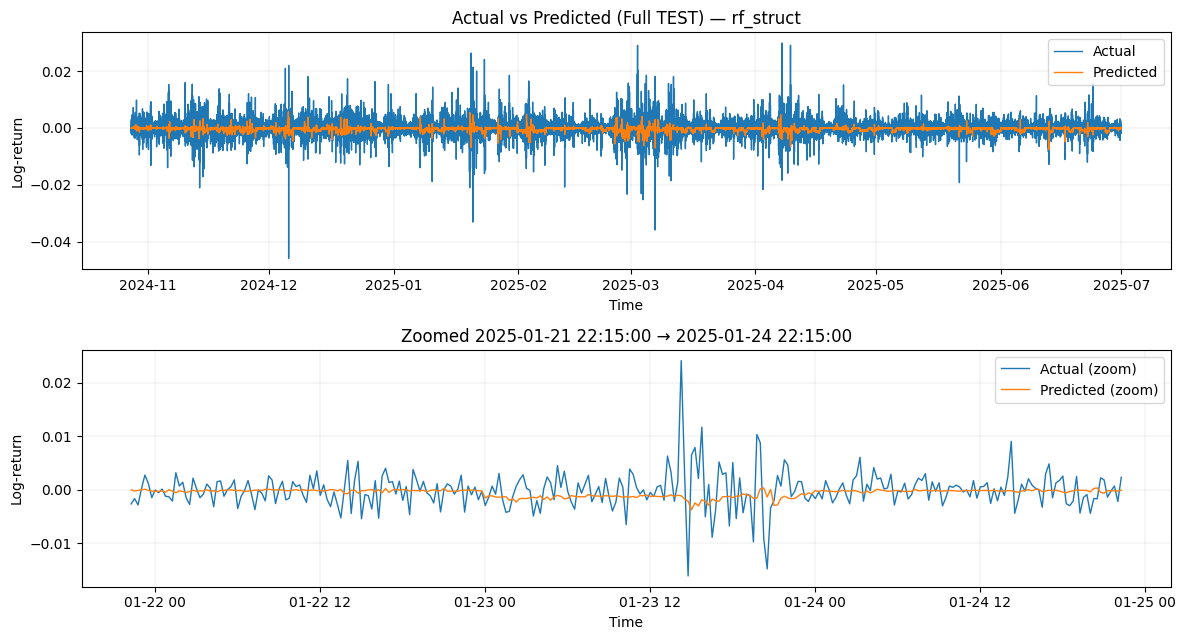

[Saved] plot → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/xgb_rf_struct_full_and_zoom.png

=== XGBoost on rf_multi ===
[DATA] Feats: 112 | Rows: train 110,305  val 23,637  test 23,638
[SWEEP] n_estimators=200   VAL_RMSE=0.002887
[SWEEP] n_estimators=400   VAL_RMSE=0.002923
[SWEEP] n_estimators=800   VAL_RMSE=0.002991
[SWEEP] n_estimators=1200  VAL_RMSE=0.003079
[SELECT] n_estimators=200 (VAL_RMSE=0.002887)
[VAL ] RMSE=0.002887  MAE=0.001891  R2=-0.028  DirAcc(ε)=0.509
[TEST] RMSE=0.002772  MAE=0.001836  R2=-0.059  DirAcc(ε)=0.504
[Saved] predictions → xgb_rf_multi_pred_val.csv / _pred_test.csv

Top 15 Feature Importances (gain):
 1. close                                     0.000799
 2. reddit_has_institutional_adoption         0.000762
 3. reddit_has_nft_market                     0.000663
 4. low                                       0.000647
 5. close_lag_13                              0.000580
 6. BBU_20_2.0                                0.000524
 7. reddit_has_macroeco

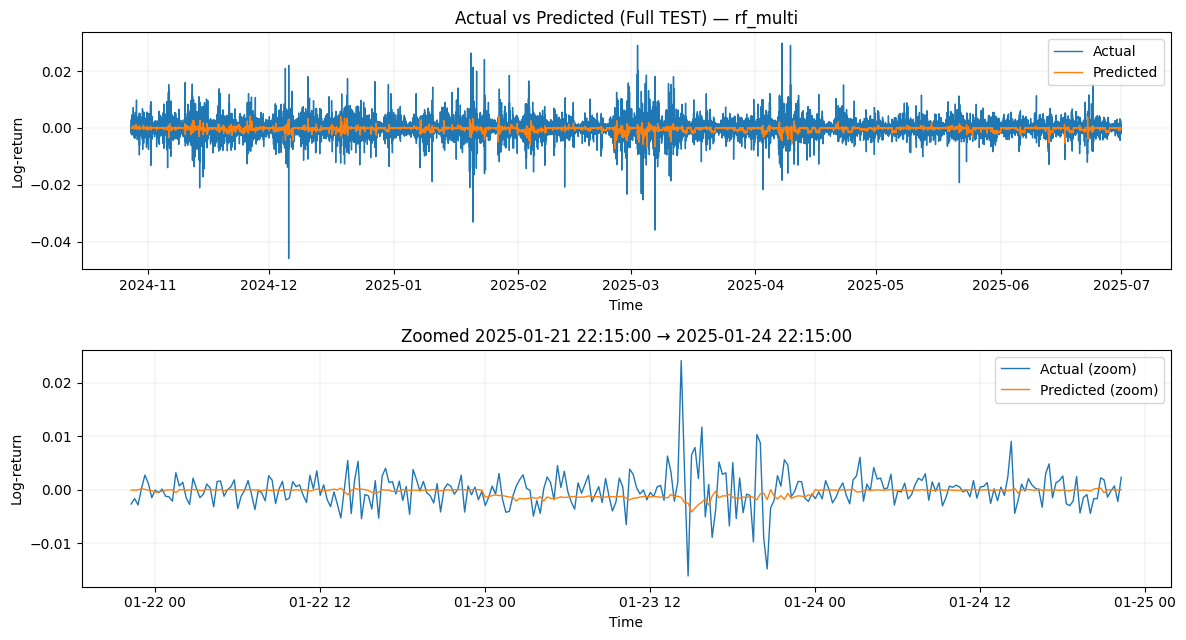

[Saved] plot → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/xgb_rf_multi_full_and_zoom.png

==================== Comparison (STRUCTURED vs MULTIMODAL) ====================
 Dataset   VAL_RMSE  VAL_MAE   VAL_R2   VAL_DirAcc  TEST_RMSE  TEST_MAE   TEST_R2  TEST_DirAcc  Best_n_estimators
rf_struct  0.002890 0.001890 -0.030717   0.499020   0.002778   0.001842 -0.063740   0.502754          200        
 rf_multi  0.002887 0.001891 -0.028122   0.508705   0.002772   0.001836 -0.059062   0.503611          200        
[Saved] summary → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/xgb_struct_vs_multi_summary.csv


In [ ]:
# ============================================
# XGBoost training & visualization (STRUCT vs MULTI)
# - Loads artifacts from Step 1–4
# - Trains on STRUCTURED and MULTIMODAL
# - Picks n_estimators by VAL RMSE (simple sweep)
# - Retrains on TRAIN+VAL, evaluates on TEST
# - Plots: full test + zoomed date range (set below)
# - Prints top-15 feature importances
# - Summarizes both runs in a metrics table
# ============================================

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# -----------------------
# CONFIG (edit these)
# -----------------------
ART_DIR    = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"
USE_GPU    = False                      # True if GPU available and xgboost-gpu installed
CAND_EST   = [200, 400, 800, 1200]      # simple sweep for n_estimators
DATASETS   = ["rf_struct", "rf_multi"]  # train both

# Zoomed plot range (on TEST). If None, an automatic 3-day window near the middle of TEST is used.
PLOT_START = None    # e.g. "2024-04-01 00:00:00"
PLOT_END   = None    # e.g. "2024-04-03 23:59:59"

# -----------------------
# Helpers
# -----------------------
def set_device_params(use_gpu: bool):
    """Safe device params across XGBoost versions."""
    return dict(tree_method="gpu_hist", predictor="gpu_predictor") if use_gpu else dict(tree_method="hist")

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))

def dir_acc_deadband(y_true, y_pred, eps: float):
    """Directional accuracy ignoring |y| < eps."""
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) >= eps
    if mask.sum() == 0: return np.nan
    return float(np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask])))

def load_xy(art_dir, tag):
    """Load X/y train/val/test preserving the DatetimeIndex from parquet."""
    p = lambda n: os.path.join(art_dir, n)
    Xtr = pd.read_parquet(p(f"X_train_{tag}.parquet"))
    Xva = pd.read_parquet(p(f"X_val_{tag}.parquet"))
    Xte = pd.read_parquet(p(f"X_test_{tag}.parquet"))
    ytr = pd.read_parquet(p(f"y_train_{tag}.parquet"))["y"]
    yva = pd.read_parquet(p(f"y_val_{tag}.parquet"))["y"]
    yte = pd.read_parquet(p(f"y_test_{tag}.parquet"))["y"]
    # Ensure datetime index
    for df_ in (Xtr, Xva, Xte):
        if not isinstance(df_.index, pd.DatetimeIndex):
            df_.index = pd.to_datetime(df_.index, errors="coerce")
    for s_ in (ytr, yva, yte):
        if not isinstance(s_.index, pd.DatetimeIndex):
            s_.index = pd.to_datetime(s_.index, errors="coerce")
    return Xtr, ytr, Xva, yva, Xte, yte

def load_meta(art_dir):
    with open(os.path.join(art_dir, "meta.json")) as f:
        meta = json.load(f)
    return {
        "index_start": meta.get("index_start"),
        "index_end":   meta.get("index_end"),
        "train_end_ts": meta.get("train_end_ts"),
        "val_end_ts":   meta.get("val_end_ts"),
        "test_end_ts":  meta.get("test_end_ts"),
        "eps": float(meta.get("epsilon_move_value", 0.0))
    }

def auto_zoom_range(test_index: pd.DatetimeIndex, days: int = 3):
    """Pick a ~3-day window centered in the TEST period if no explicit range given."""
    if len(test_index) == 0: return None, None
    start = test_index[int(len(test_index)*0.35)]
    end   = start + pd.Timedelta(days=days)
    return start, end

def plot_actual_vs_pred_full_and_zoom(idx, y_true, y_pred, zoom_start=None, zoom_end=None, title_suffix=""):
    """Render two-panel plot: full test (top) + zoomed range (bottom)."""
    fig, axes = plt.subplots(2, 1, figsize=(12, 6.5), sharey=False)
    # Full test
    axes[0].plot(idx, y_true, label="Actual", linewidth=1.0)
    axes[0].plot(idx, y_pred, label="Predicted", linewidth=1.0)
    axes[0].set_title(f"Actual vs Predicted (Full TEST) {title_suffix}")
    axes[0].set_xlabel("Time")
    axes[0].set_ylabel("Log-return")
    axes[0].legend(loc="upper right")
    axes[0].grid(True, linewidth=0.3, alpha=0.5)

    # Zoom range
    if zoom_start is None or zoom_end is None:
        z0, z1 = auto_zoom_range(idx, days=3)
    else:
        z0, z1 = pd.Timestamp(zoom_start), pd.Timestamp(zoom_end)

    m = (idx >= z0) & (idx <= z1)
    axes[1].plot(idx[m], y_true[m], label="Actual (zoom)", linewidth=1.0)
    axes[1].plot(idx[m], y_pred[m], label="Predicted (zoom)", linewidth=1.0)
    axes[1].set_title(f"Zoomed {z0} → {z1}")
    axes[1].set_xlabel("Time")
    axes[1].set_ylabel("Log-return")
    axes[1].legend(loc="upper right")
    axes[1].grid(True, linewidth=0.3, alpha=0.5)

    plt.tight_layout()
    return fig

# -----------------------
# Base model params (conservative)
# -----------------------
BASE_PARAMS = dict(
    objective="reg:squarederror",
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=42,
)

# -----------------------
# Run both datasets
# -----------------------
meta = load_meta(ART_DIR)
print(f"[INFO] Using ε-deadband = {meta['eps']:.6f}")
summary_rows = []

for tag in DATASETS:
    print("\n" + "="*34)
    print(f"=== XGBoost on {tag} ===")
    print("="*34)

    Xtr, ytr, Xva, yva, Xte, yte = load_xy(ART_DIR, tag)
    print(f"[DATA] Feats: {Xtr.shape[1]} | Rows: train {len(Xtr):,}  val {len(Xva):,}  test {len(Xte):,}")

    # Sweep n_estimators on VAL
    best_est, best_rmse, best_model = None, np.inf, None
    for n in CAND_EST:
        params = {**BASE_PARAMS, **set_device_params(USE_GPU), "n_estimators": n}
        model = xgb.XGBRegressor(**params)
        model.fit(Xtr, ytr)  # keep it version-agnostic (no early stopping args)
        pred_val = model.predict(Xva)
        score = rmse(yva, pred_val)
        print(f"[SWEEP] n_estimators={n:<4d}  VAL_RMSE={score:.6f}")
        if score < best_rmse:
            best_rmse, best_est, best_model = score, n, model

    print(f"[SELECT] n_estimators={best_est} (VAL_RMSE={best_rmse:.6f})")

    # Retrain on TRAIN+VAL with selected n_estimators
    X_trv = pd.concat([Xtr, Xva], axis=0)
    y_trv = pd.concat([ytr, yva], axis=0)
    final_params = {**BASE_PARAMS, **set_device_params(USE_GPU), "n_estimators": best_est}
    final_model = xgb.XGBRegressor(**final_params)
    final_model.fit(X_trv, y_trv)

    # Predictions
    y_val_pred  = best_model.predict(Xva)
    y_test_pred = final_model.predict(Xte)

    # Metrics
    eps = meta["eps"]
    val_metrics = dict(
        split="VAL",
        RMSE=rmse(yva, y_val_pred),
        MAE=mean_absolute_error(yva, y_val_pred),
        R2=r2_score(yva, y_val_pred),
        DirAcc=dir_acc_deadband(yva, y_val_pred, eps)
    )
    test_metrics = dict(
        split="TEST",
        RMSE=rmse(yte, y_test_pred),
        MAE=mean_absolute_error(yte, y_test_pred),
        R2=r2_score(yte, y_test_pred),
        DirAcc=dir_acc_deadband(yte, y_test_pred, eps)
    )

    print(f"[VAL ] RMSE={val_metrics['RMSE']:.6f}  MAE={val_metrics['MAE']:.6f}  R2={val_metrics['R2']:.3f}  DirAcc(ε)={val_metrics['DirAcc']:.3f}")
    print(f"[TEST] RMSE={test_metrics['RMSE']:.6f}  MAE={test_metrics['MAE']:.6f}  R2={test_metrics['R2']:.3f}  DirAcc(ε)={test_metrics['DirAcc']:.3f}")

    # Save predictions & plots
    save_prefix = f"xgb_{tag}"
    pred_df_val  = pd.DataFrame({"y_actual": yva.values,  "y_pred": y_val_pred},  index=yva.index)
    pred_df_test = pd.DataFrame({"y_actual": yte.values,  "y_pred": y_test_pred}, index=yte.index)
    pred_df_val.to_csv(os.path.join(ART_DIR, f"{save_prefix}_pred_val.csv"))
    pred_df_test.to_csv(os.path.join(ART_DIR, f"{save_prefix}_pred_test.csv"))
    print(f"[Saved] predictions → {save_prefix}_pred_val.csv / _pred_test.csv")

    # Feature importances (gain) — top 15
    booster = final_model.get_booster()
    gain = booster.get_score(importance_type="gain")
    # Map f{idx} back to column names:
    name_map = {f"f{i}": col for i, col in enumerate(X_trv.columns)}
    top_imp = sorted(((name_map.get(k, k), float(v)) for k, v in gain.items()),
                     key=lambda x: x[1], reverse=True)[:15]

    print("\nTop 15 Feature Importances (gain):")
    for i, (feat, score) in enumerate(top_imp, 1):
        print(f"{i:2d}. {feat:40s}  {score:.6f}")

    # Plots: full test + zoom
    zs, ze = PLOT_START, PLOT_END
    fig = plot_actual_vs_pred_full_and_zoom(
        idx=pred_df_test.index, y_true=pred_df_test["y_actual"].values, y_pred=pred_df_test["y_pred"].values,
        zoom_start=zs, zoom_end=ze, title_suffix=f"— {tag}"
    )
    plot_path = os.path.join(ART_DIR, f"{save_prefix}_full_and_zoom.png")
    fig.savefig(plot_path, dpi=160); plt.show()
    print(f"[Saved] plot → {plot_path}")

    # Keep rows for summary table
    summary_rows.append({
        "Dataset": tag,
        "VAL_RMSE":  val_metrics["RMSE"], "VAL_MAE":  val_metrics["MAE"], "VAL_R2":  val_metrics["R2"], "VAL_DirAcc":  val_metrics["DirAcc"],
        "TEST_RMSE": test_metrics["RMSE"], "TEST_MAE": test_metrics["MAE"], "TEST_R2": test_metrics["R2"], "TEST_DirAcc": test_metrics["DirAcc"],
        "Best_n_estimators": best_est
    })

# -----------------------
# Comparison table
# -----------------------
summary_df = pd.DataFrame(summary_rows)
# Sort so rf_struct shows first
summary_df = summary_df.set_index("Dataset").loc[["rf_struct","rf_multi"]].reset_index()
print("\n==================== Comparison (STRUCTURED vs MULTIMODAL) ====================")
display_cols = ["Dataset",
                "VAL_RMSE","VAL_MAE","VAL_R2","VAL_DirAcc",
                "TEST_RMSE","TEST_MAE","TEST_R2","TEST_DirAcc",
                "Best_n_estimators"]
print(summary_df[display_cols].to_string(index=False, justify="center"))
summary_df.to_csv(os.path.join(ART_DIR, "xgb_struct_vs_multi_summary.csv"), index=False)
print(f"[Saved] summary → {os.path.join(ART_DIR, 'xgb_struct_vs_multi_summary.csv')}")


## **LSTM Model (Structured and Multimodal)**

[INFO] Using ε-deadband = 0.001755

=== LSTM on rf_struct ===
[DATA] Lookback=64 | Feats=62 | Rows: train 110,241  val 23,573  test 23,574
[VAL ] RMSE=0.002879  MAE=0.001901  R2=-0.020  DirAcc(ε)=0.490  (best_epoch=4)

Top 15 Permutation Importances (VAL, ΔMAE):
 1. fee_per_tx                                ΔMAE=0.000056
 2. avg_tx_fee_btc                            ΔMAE=0.000005
 3. tx_count                                  ΔMAE=0.000003
 4. MACDs_12_26_9                             ΔMAE=0.000001
 5. quote_asset_volume                        ΔMAE=0.000001
 6. FGI_Classification_Greed                  ΔMAE=0.000001
 7. Sentiment_Level                           ΔMAE=0.000001
 8. SMA_20                                    ΔMAE=0.000001
 9. avg_fee_ma_8                              ΔMAE=0.000001
10. volume_lag_13                             ΔMAE=0.000001
11. tx_per_address                            ΔMAE=0.000001
12. num_trades                                ΔMAE=0.000001
13. hour_cos     

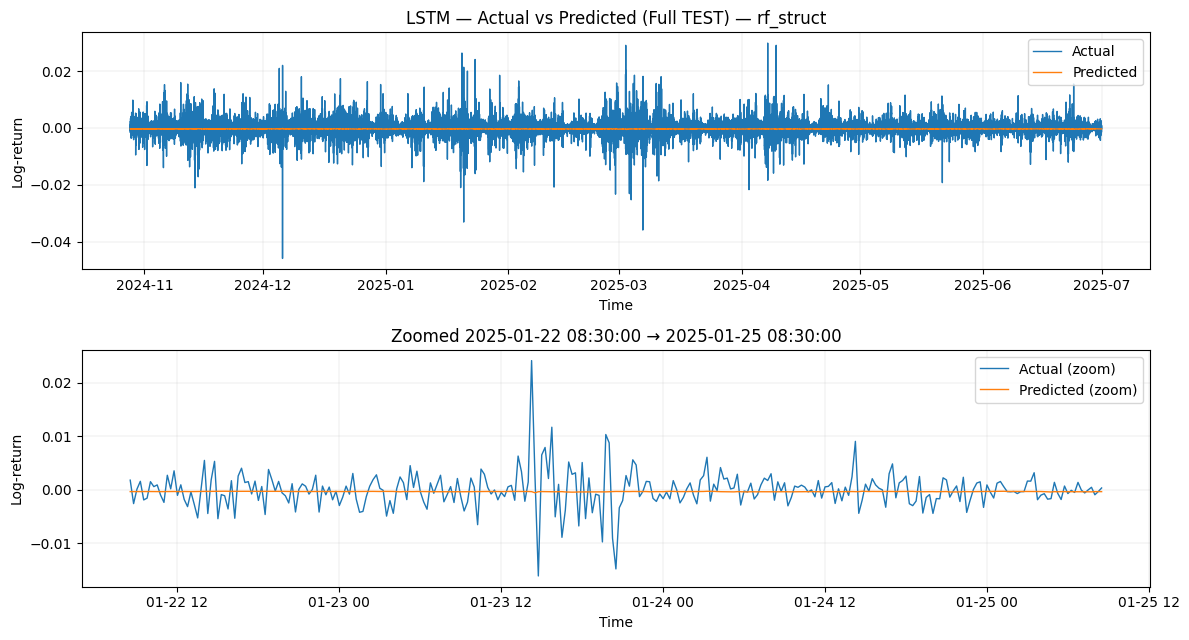

[Saved] plot → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/lstm_rf_struct_full_and_zoom.png

=== LSTM on rf_multi ===
[DATA] Lookback=64 | Feats=112 | Rows: train 110,241  val 23,573  test 23,574
[VAL ] RMSE=0.002885  MAE=0.001910  R2=-0.025  DirAcc(ε)=0.501  (best_epoch=3)

Top 15 Permutation Importances (VAL, ΔMAE):
 1. news_has_on_chain_activity                ΔMAE=0.000009
 2. news_has_social_media_buzz                ΔMAE=0.000005
 3. news_has_halving_event                    ΔMAE=0.000004
 4. avg_tx_fee_btc                            ΔMAE=0.000004
 5. news_sentiment_score                      ΔMAE=0.000004
 6. MACDs_12_26_9                             ΔMAE=0.000003
 7. avg_fee_ma_8                              ΔMAE=0.000003
 8. fee_per_tx                                ΔMAE=0.000003
 9. news_sentiment_bearish                    ΔMAE=0.000003
10. reddit_is_post                            ΔMAE=0.000003
11. news_has_tech_development                 ΔMAE=0.000002
12. reddit_

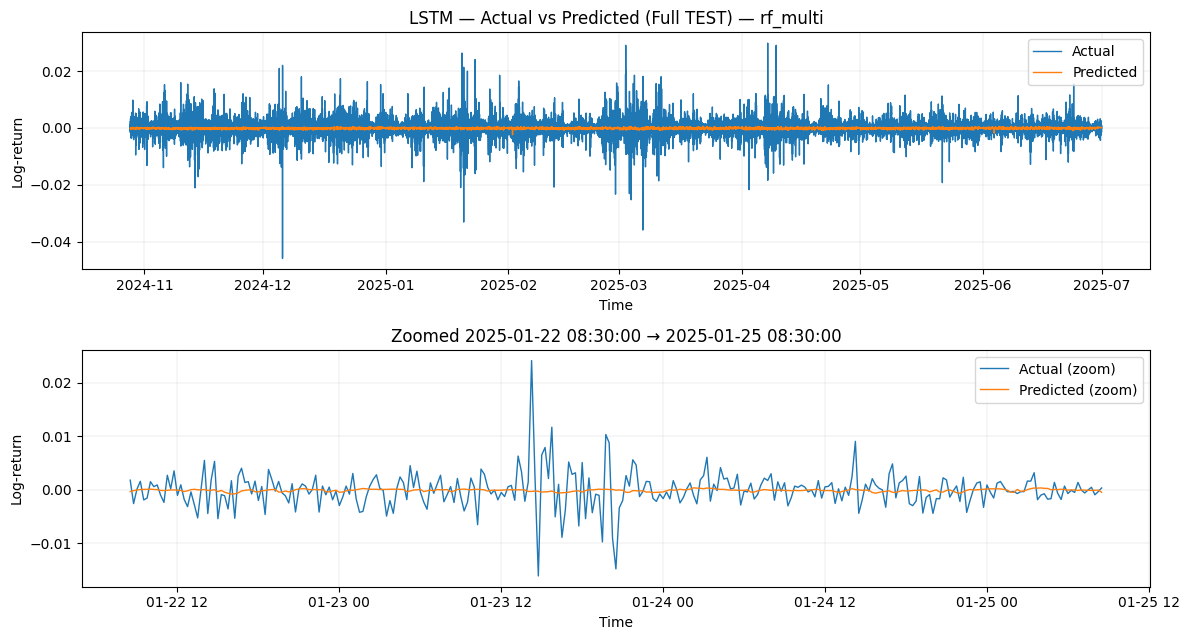

[Saved] plot → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/lstm_rf_multi_full_and_zoom.png

==================== Comparison (STRUCTURED vs MULTIMODAL) ====================
 Dataset   VAL_RMSE  VAL_MAE   VAL_R2   VAL_DirAcc  TEST_RMSE  TEST_MAE   TEST_R2  TEST_DirAcc  Best_Epoch
rf_struct  0.002879 0.001901 -0.020400   0.489845   0.002719   0.001801 -0.016953   0.490804        4     
 rf_multi  0.002885 0.001910 -0.024896   0.501385   0.002705   0.001785 -0.006678   0.493134        3     
[Saved] summary → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/lstm_struct_vs_multi_summary.csv


In [ ]:
# ============================================
# LSTM training & visualization (STRUCT vs MULTI)
# - Loads NPZ sequences
# - Trains on STRUCTURED and MULTIMODAL with early stopping
# - Retrains on TRAIN+VAL for best epoch; evaluates on TEST
# - Plots: full test + zoomed date range
# - Prints permutation importance (top-15) on VAL
# - Summarizes both runs in a metrics table
# ============================================

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------
# CONFIG (edit these)
# -----------------------
ART_DIR    = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"
DATASETS   = [("rf_struct","lstm_struct_sequences.npz"),
              ("rf_multi" ,"lstm_multi_sequences.npz")]

SEED       = 42
BATCH_SIZE = 256
EPOCHS_MAX = 60
PATIENCE   = 6
LR         = 1e-3

# Zoomed plot range for TEST (datetime). If None, auto-picks a ~3-day window.
PLOT_START = None   # e.g. "2024-04-01 00:00:00"
PLOT_END   = None   # e.g. "2024-04-03 23:59:59"

# Permutation importance config (on VAL)
DO_PERM_IMPORTANCE = True
PERM_TOPK = 15
PERM_MAX_SAMPLES = 10000   # subsample VAL sequences for speed

# -----------------------
# Reproducibility
# -----------------------
def set_all_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_all_seeds(SEED)

# -----------------------
# Helpers
# -----------------------
def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))

def dir_acc_deadband(y_true, y_pred, eps: float):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    mask = np.abs(y_true) >= eps
    if mask.sum() == 0: return np.nan
    return float(np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask])))

def load_meta(art_dir):
    with open(os.path.join(art_dir, "meta.json")) as f:
        meta = json.load(f)
    return {
        "eps": float(meta.get("epsilon_move_value", 0.0))
    }

def load_sequences(art_dir, npz_name):
    """Return Xtr, ytr, Xva, yva, Xte, yte with strict key checks."""
    path = os.path.join(art_dir, npz_name)
    z = np.load(path)
    needed = ["X_train","y_train","X_val","y_val","X_test","y_test"]
    for k in needed:
        if k not in z.files:
            raise KeyError(f"NPZ missing {k}: {path} (found: {list(z.files)})")
    return z["X_train"], z["y_train"], z["X_val"], z["y_val"], z["X_test"], z["y_test"]

def load_y_test_index_for_plot(art_dir, tag, lookback):
    """Use parquet y_test index, trimmed by lookback to align with sequences."""
    yte = pd.read_parquet(os.path.join(art_dir, f"y_test_{tag}.parquet"))["y"]
    idx = pd.to_datetime(yte.index)
    if len(idx) <= lookback:
        raise ValueError(f"Not enough test rows ({len(idx)}) for lookback={lookback}.")
    return idx[lookback:]  # align to sequence target alignment

def auto_zoom_range(test_index: pd.DatetimeIndex, days: int = 3):
    if len(test_index) == 0: return None, None
    start = test_index[int(len(test_index)*0.35)]
    end   = start + pd.Timedelta(days=days)
    return start, end

def plot_actual_vs_pred_full_and_zoom(idx, y_true, y_pred, zoom_start=None, zoom_end=None, title_suffix=""):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6.5), sharey=False)
    # Full
    axes[0].plot(idx, y_true, label="Actual", linewidth=1.0)
    axes[0].plot(idx, y_pred, label="Predicted", linewidth=1.0)
    axes[0].set_title(f"LSTM — Actual vs Predicted (Full TEST) {title_suffix}")
    axes[0].set_xlabel("Time"); axes[0].set_ylabel("Log-return")
    axes[0].legend(loc="upper right"); axes[0].grid(True, linewidth=0.3, alpha=0.5)
    # Zoom
    if zoom_start is None or zoom_end is None:
        z0, z1 = auto_zoom_range(idx, days=3)
    else:
        z0, z1 = pd.Timestamp(zoom_start), pd.Timestamp(zoom_end)
    m = (idx >= z0) & (idx <= z1)
    axes[1].plot(idx[m], y_true[m], label="Actual (zoom)", linewidth=1.0)
    axes[1].plot(idx[m], y_pred[m], label="Predicted (zoom)", linewidth=1.0)
    axes[1].set_title(f"Zoomed {z0} → {z1}")
    axes[1].set_xlabel("Time"); axes[1].set_ylabel("Log-return")
    axes[1].legend(loc="upper right"); axes[1].grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout()
    return fig

def build_lstm_model(lookback, n_feats, lr=1e-3):
    """A simple, stable LSTM for log-returns."""
    inp = keras.Input(shape=(lookback, n_feats))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation="relu")(x)
    out = layers.Dense(1, activation="linear")(x)
    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return model

def permutation_importance_on_val(model, X_val, y_val, topk=15, max_samples=10000, random_state=42):
    """
    Permute one feature across samples (preserving within-sample time structure) and
    measure MAE increase. Returns sorted list [(feat_idx, delta_mae), ...].
    """
    rng = np.random.default_rng(random_state)
    n, L, d = X_val.shape
    n_use = min(n, max_samples)
    X = X_val[:n_use].copy()
    y = y_val[:n_use].copy()
    base_pred = model.predict(X, verbose=0).ravel()
    base_mae = mean_absolute_error(y, base_pred)
    importances = []
    for f in range(d):
        Xp = X.copy()
        perm = rng.permutation(n_use)
        Xp[:, :, f] = X[perm, :, f]  # shuffle across samples
        yp = model.predict(Xp, verbose=0).ravel()
        mae = mean_absolute_error(y, yp)
        importances.append((f, mae - base_mae))
    importances.sort(key=lambda x: x[1], reverse=True)
    return importances[:topk]

# -----------------------
# Run both datasets
# -----------------------
meta = load_meta(ART_DIR)
eps = meta["eps"]
print(f"[INFO] Using ε-deadband = {eps:.6f}")

summary_rows = []

for tag, npz_name in DATASETS:
    print("\n" + "="*34)
    print(f"=== LSTM on {tag} ===")
    print("="*34)

    # Load sequences
    Xtr, ytr, Xva, yva, Xte, yte = load_sequences(ART_DIR, npz_name)
    lookback, n_feats = Xtr.shape[1], Xtr.shape[2]
    print(f"[DATA] Lookback={lookback} | Feats={n_feats} | Rows: train {len(Xtr):,}  val {len(Xva):,}  test {len(Xte):,}")

    # Stage 1: train with early stopping on VAL
    set_all_seeds(SEED)
    model = build_lstm_model(lookback, n_feats, lr=LR)
    cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)]
    hist = model.fit(
        Xtr, ytr,
        validation_data=(Xva, yva),
        epochs=EPOCHS_MAX,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0,
        callbacks=cb
    )
    # Best epoch via val_loss
    val_losses = hist.history.get("val_loss", [])
    if not val_losses:
        raise RuntimeError("No validation loss logged; check model.fit arguments.")
    best_epoch = int(np.argmin(val_losses)) + 1

    # Validation metrics
    y_val_pred = model.predict(Xva, verbose=0).ravel()
    val_rmse = rmse(yva, y_val_pred)
    val_mae  = mean_absolute_error(yva, y_val_pred)
    val_r2   = r2_score(yva, y_val_pred)
    val_dir  = dir_acc_deadband(yva, y_val_pred, eps)
    print(f"[VAL ] RMSE={val_rmse:.6f}  MAE={val_mae:.6f}  R2={val_r2:.3f}  DirAcc(ε)={val_dir:.3f}  (best_epoch={best_epoch})")

    # Optional: permutation importance on validation
    if DO_PERM_IMPORTANCE:
        imps = permutation_importance_on_val(model, Xva, yva, topk=PERM_TOPK, max_samples=PERM_MAX_SAMPLES, random_state=SEED)
        # If we can map feature indices back to names, load names from meta
        with open(os.path.join(ART_DIR, "meta.json")) as f:
            meta_full = json.load(f)
        feat_names = meta_full["structured_feature_names"] if tag=="rf_struct" else meta_full["multimodal_feature_names"]
        print("\nTop 15 Permutation Importances (VAL, ΔMAE):")
        for rank, (fi, delta) in enumerate(imps, 1):
            name = feat_names[fi] if fi < len(feat_names) else f"f{fi}"
            print(f"{rank:2d}. {name:40s}  ΔMAE={delta:.6f}")

    # Stage 2: re-train on TRAIN+VAL for best_epoch epochs, then evaluate on TEST
    set_all_seeds(SEED)
    model_final = build_lstm_model(lookback, n_feats, lr=LR)
    X_trv = np.concatenate([Xtr, Xva], axis=0)
    y_trv = np.concatenate([ytr, yva], axis=0)
    model_final.fit(
        X_trv, y_trv,
        epochs=best_epoch,
        batch_size=BATCH_SIZE,
        shuffle=True,
        verbose=0
    )

    y_test_pred = model_final.predict(Xte, verbose=0).ravel()
    test_rmse = rmse(yte, y_test_pred)
    test_mae  = mean_absolute_error(yte, y_test_pred)
    test_r2   = r2_score(yte, y_test_pred)
    test_dir  = dir_acc_deadband(yte, y_test_pred, eps)
    print(f"[TEST] RMSE={test_rmse:.6f}  MAE={test_mae:.6f}  R2={test_r2:.3f}  DirAcc(ε)={test_dir:.3f}")

    # Save predictions
    save_prefix = f"lstm_{tag}"
    val_df  = pd.DataFrame({"y_actual": yva, "y_pred": y_val_pred})
    test_df = pd.DataFrame({"y_actual": yte, "y_pred": y_test_pred})
    val_df.to_csv(os.path.join(ART_DIR, f"{save_prefix}_pred_val.csv"), index=False)
    test_df.to_csv(os.path.join(ART_DIR, f"{save_prefix}_pred_test.csv"), index=False)
    print(f"[Saved] predictions → {save_prefix}_pred_val.csv / _pred_test.csv")

    # Plot (need datetime index; align with lookback)
    test_idx = load_y_test_index_for_plot(ART_DIR, tag, lookback)
    if len(test_idx) != len(test_df):
        # If any mismatch, fallback to a simple integer index
        print(f"[WARN] Index length mismatch (idx {len(test_idx)} vs preds {len(test_df)}). Using integer index.")
        test_idx = np.arange(len(test_df))

    fig = plot_actual_vs_pred_full_and_zoom(
        idx=test_idx,
        y_true=test_df["y_actual"].values,
        y_pred=test_df["y_pred"].values,
        zoom_start=PLOT_START, zoom_end=PLOT_END,
        title_suffix=f"— {tag}"
    )
    plot_path = os.path.join(ART_DIR, f"{save_prefix}_full_and_zoom.png")
    fig.savefig(plot_path, dpi=160); plt.show()
    print(f"[Saved] plot → {plot_path}")

    # Summary row
    summary_rows.append({
        "Dataset": tag,
        "VAL_RMSE":  val_rmse, "VAL_MAE":  val_mae, "VAL_R2":  val_r2, "VAL_DirAcc":  val_dir,
        "TEST_RMSE": test_rmse, "TEST_MAE": test_mae, "TEST_R2": test_r2, "TEST_DirAcc": test_dir,
        "Best_Epoch": best_epoch
    })

# -----------------------
# Comparison table
# -----------------------
summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.set_index("Dataset").loc[["rf_struct","rf_multi"]].reset_index()
print("\n==================== Comparison (STRUCTURED vs MULTIMODAL) ====================")
display_cols = ["Dataset",
                "VAL_RMSE","VAL_MAE","VAL_R2","VAL_DirAcc",
                "TEST_RMSE","TEST_MAE","TEST_R2","TEST_DirAcc",
                "Best_Epoch"]
print(summary_df[display_cols].to_string(index=False, justify="center"))
summary_df.to_csv(os.path.join(ART_DIR, "lstm_struct_vs_multi_summary.csv"), index=False)
print(f"[Saved] summary → {os.path.join(ART_DIR, 'lstm_struct_vs_multi_summary.csv')}")

## **Hybrid Model**

[INFO] ε-deadband = 0.001755
[DATA] Feats=112 | TRAIN 110,305 | VAL 23,637 | TEST 23,638
[SEQ ] Lookback=64 | Feats=112 | TrainSeq 110,241 | ValSeq 23,573 | TestSeq 23,574
[XGB SWEEP] n_estimators=200   VAL_RMSE=0.002887
[XGB SWEEP] n_estimators=400   VAL_RMSE=0.002923
[XGB SWEEP] n_estimators=800   VAL_RMSE=0.002991
[XGB SELECT] n_estimators=200 (VAL_RMSE=0.002887)
[SHRINK] alpha* (VAL) = 0.2112

[VAL ] XGB  : RMSE=0.002890  MAE=0.001893  R2=-0.028  DirAcc(ε)=0.509
       HYBRID: RMSE=0.002889  MAE=0.001893  R2=-0.028  DirAcc(ε)=0.504
[TEST] XGB  : RMSE=0.002774  MAE=0.001838  R2=-0.059  DirAcc(ε)=0.504
       HYBRID: RMSE=0.002778  MAE=0.001842  R2=-0.062  DirAcc(ε)=0.504

=== Top-15 XGB Feature Importances (gain) ===
 1. close                                    gain=0.000799
 2. reddit_has_institutional_adoption        gain=0.000762
 3. reddit_has_nft_market                    gain=0.000663
 4. low                                      gain=0.000647
 5. close_lag_13                  

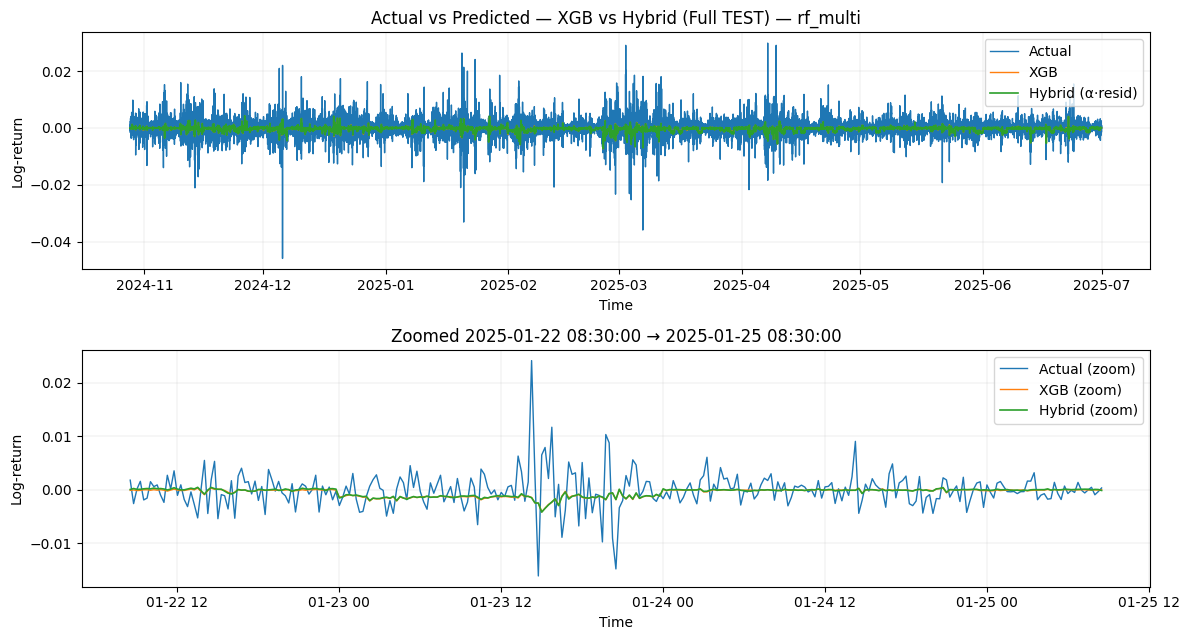

[Saved] plot → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/hybrid_final_rf_multi_full_and_zoom.png
[Saved] summary → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/hybrid_final_rf_multi_summary.csv


In [ ]:
# ============================================================
# FINAL HYBRID (for Thesis): XGB (primary) + α-shrunk LSTM residual
# Uses artifacts from leakage-safe pipeline (Step 1–4).
# - TRAIN/VAL/TEST parquet for XGB
# - LSTM sequences NPZ (lookback-aligned)
# Saves: plot (full+zoom) and summary CSV
# ============================================================

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt, random
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# -----------------------
# CONFIG
# -----------------------
ART_DIR     = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"

# Choose dataset:
DATASET_TAG = "rf_multi"                 # "rf_multi" (multimodal, recommended) or "rf_struct" (structured)
SEQ_FILE    = "lstm_multi_sequences.npz" # "lstm_struct_sequences.npz" for structured

# XGB settings (simple & stable)
USE_GPU_XGB = False
CAND_EST    = [200, 400, 800]            # tiny sweep; 200 was best in your runs
SEED        = 42

# LSTM residual model (small & regularized)
BATCH_SIZE  = 256
EPOCHS_MAX  = 30
PATIENCE    = 4
LR          = 1e-3
DROPOUT     = 0.30
L2REG       = 1e-4

# Optional zoom window for TEST plot (ISO timestamps) or leave None to auto-choose
PLOT_START = None
PLOT_END   = None

# -----------------------
# Utilities
# -----------------------
def set_all_seeds(s=42):
    random.seed(s); np.random.seed(s); tf.random.set_seed(s)

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))

def dir_acc_deadband(y_true, y_pred, eps: float):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    m = np.abs(y_true) >= eps
    if m.sum() == 0: return np.nan
    return float(np.mean(np.sign(y_true[m]) == np.sign(y_pred[m])))

def set_device_params(use_gpu: bool):
    return dict(tree_method="gpu_hist", predictor="gpu_predictor") if use_gpu else dict(tree_method="hist")

def load_meta_eps(art_dir):
    with open(os.path.join(art_dir, "meta.json")) as f:
        meta = json.load(f)
    return float(meta.get("epsilon_move_value", 0.0))

def load_xy(art_dir, tag):
    p = lambda n: os.path.join(art_dir, n)
    Xtr = pd.read_parquet(p(f"X_train_{tag}.parquet"))
    Xva = pd.read_parquet(p(f"X_val_{tag}.parquet"))
    Xte = pd.read_parquet(p(f"X_test_{tag}.parquet"))
    ytr = pd.read_parquet(p(f"y_train_{tag}.parquet"))["y"]
    yva = pd.read_parquet(p(f"y_val_{tag}.parquet"))["y"]
    yte = pd.read_parquet(p(f"y_test_{tag}.parquet"))["y"]
    # Ensure DatetimeIndex for plotting
    for df_ in (Xtr, Xva, Xte):
        if not isinstance(df_.index, pd.DatetimeIndex):
            df_.index = pd.to_datetime(df_.index, errors="coerce")
    for s_ in (ytr, yva, yte):
        if not isinstance(s_.index, pd.DatetimeIndex):
            s_.index = pd.to_datetime(s_.index, errors="coerce")
    return Xtr, ytr, Xva, yva, Xte, yte

def load_sequences(art_dir, npz_name):
    z = np.load(os.path.join(art_dir, npz_name))
    needed = ["X_train","y_train","X_val","y_val","X_test","y_test"]
    for k in needed:
        if k not in z.files:
            raise KeyError(f"NPZ missing {k}; found {list(z.files)}")
    return z["X_train"], z["y_train"], z["X_val"], z["y_val"], z["X_test"], z["y_test"]

def build_lstm_residual_small(lookback, n_feats, lr=1e-3, dr=0.3, l2=1e-4):
    inp = keras.Input(shape=(lookback, n_feats))
    x = layers.LSTM(16, kernel_regularizer=regularizers.l2(l2))(inp)
    x = layers.Dropout(dr)(x)
    x = layers.Dense(16, activation="relu", kernel_regularizer=regularizers.l2(l2))(x)
    out = layers.Dense(1, activation="linear")(x)
    m = keras.Model(inp, out)
    m.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse", metrics=["mae"])
    return m

def auto_zoom_range(test_index: pd.DatetimeIndex, days: int = 3):
    if len(test_index) == 0: return None, None
    start = test_index[int(len(test_index)*0.35)]
    end   = start + pd.Timedelta(days=days)
    return start, end

def plot_full_and_zoom(idx, actual, pred_xgb, pred_hyb, title_suffix="", zs=None, ze=None):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6.5), sharey=False)
    # Full
    axes[0].plot(idx, actual, label="Actual", linewidth=1.0)
    axes[0].plot(idx, pred_xgb, label="XGB", linewidth=1.0)
    axes[0].plot(idx, pred_hyb, label="Hybrid (α·resid)", linewidth=1.2)
    axes[0].set_title(f"Actual vs Predicted — XGB vs Hybrid (Full TEST) {title_suffix}")
    axes[0].set_xlabel("Time"); axes[0].set_ylabel("Log-return")
    axes[0].legend(loc="upper right"); axes[0].grid(True, linewidth=0.3, alpha=0.5)
    # Zoom
    if zs is None or ze is None:
        z0, z1 = auto_zoom_range(pd.DatetimeIndex(idx), days=3)
    else:
        z0, z1 = pd.Timestamp(zs), pd.Timestamp(ze)
    m = (pd.DatetimeIndex(idx) >= z0) & (pd.DatetimeIndex(idx) <= z1)
    axes[1].plot(pd.DatetimeIndex(idx)[m], np.array(actual)[m], label="Actual (zoom)", linewidth=1.0)
    axes[1].plot(pd.DatetimeIndex(idx)[m], np.array(pred_xgb)[m], label="XGB (zoom)", linewidth=1.0)
    axes[1].plot(pd.DatetimeIndex(idx)[m], np.array(pred_hyb)[m], label="Hybrid (zoom)", linewidth=1.2)
    axes[1].set_title(f"Zoomed {z0} → {z1}")
    axes[1].set_xlabel("Time"); axes[1].set_ylabel("Log-return")
    axes[1].legend(loc="upper right"); axes[1].grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout()
    return fig

# -----------------------
# Base XGB params
# -----------------------
BASE_PARAMS = dict(
    objective="reg:squarederror",
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.0,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
)

# -----------------------
# Run
# -----------------------
set_all_seeds(SEED)
eps = load_meta_eps(ART_DIR)
print(f"[INFO] ε-deadband = {eps:.6f}")

# Load artifacts
Xtr, ytr, Xva, yva, Xte, yte = load_xy(ART_DIR, DATASET_TAG)
Xseq_tr, yseq_tr, Xseq_va, yseq_va, Xseq_te, yseq_te = load_sequences(ART_DIR, SEQ_FILE)
lookback, n_feats = Xseq_tr.shape[1], Xseq_tr.shape[2]
print(f"[DATA] Feats={Xtr.shape[1]} | TRAIN {len(Xtr):,} | VAL {len(Xva):,} | TEST {len(Xte):,}")
print(f"[SEQ ] Lookback={lookback} | Feats={n_feats} | TrainSeq {len(Xseq_tr):,} | ValSeq {len(Xseq_va):,} | TestSeq {len(Xseq_te):,}")

# 1) XGB: choose n_estimators on VAL (train on TRAIN only)
best_est, best_rmse, best_model = None, np.inf, None
for n in CAND_EST:
    params = {**BASE_PARAMS, **set_device_params(USE_GPU_XGB), "n_estimators": n}
    m = xgb.XGBRegressor(**params).fit(Xtr, ytr)
    pv = m.predict(Xva)
    sc = rmse(yva, pv)
    print(f"[XGB SWEEP] n_estimators={n:<4d}  VAL_RMSE={sc:.6f}")
    if sc < best_rmse:
        best_rmse, best_est, best_model = sc, n, m
print(f"[XGB SELECT] n_estimators={best_est} (VAL_RMSE={best_rmse:.6f})")

# Final XGB for TEST (train on TRAIN+VAL)
X_trv = pd.concat([Xtr, Xva], axis=0)
y_trv = pd.concat([ytr, yva], axis=0)
xgb_final = xgb.XGBRegressor(**{**BASE_PARAMS, **set_device_params(USE_GPU_XGB), "n_estimators": best_est}).fit(X_trv, y_trv)

# Predictions
yhat_val  = pd.Series(best_model.predict(Xva), index=yva.index)        # TRAIN-only model on VAL
yhat_test = pd.Series(xgb_final.predict(Xte), index=yte.index)         # TRAIN+VAL model on TEST

# 2) Residual labels (no leakage): split TRAIN into TRAIN1 -> TRAIN2 (forward)
Ntr = len(ytr); mid = Ntr // 2
Xtr1, ytr1 = Xtr.iloc[:mid], ytr.iloc[:mid]
Xtr2, ytr2 = Xtr.iloc[mid:], ytr.iloc[mid:]
xgb_tr1 = xgb.XGBRegressor(**{**BASE_PARAMS, **set_device_params(USE_GPU_XGB), "n_estimators": best_est}).fit(Xtr1, ytr1)
yhat_tr2 = pd.Series(xgb_tr1.predict(Xtr2), index=ytr2.index)          # forward prediction
res_tr2_raw = ytr2.values - yhat_tr2.values
res_val_raw = yva.values  - yhat_val.values

# Align residuals to sequence targets (drop first lookback)
if len(res_tr2_raw) <= lookback or len(res_val_raw) <= lookback:
    raise ValueError("Not enough rows for lookback; reduce lookback or ensure data size.")
start_i_tr2 = max(0, mid - lookback)
Xseq_tr2 = Xseq_tr[start_i_tr2:]; yseq_tr2 = yseq_tr[start_i_tr2:]
need_len = len(res_tr2_raw) - lookback
Xseq_tr2 = Xseq_tr2[-need_len:]; yseq_tr2 = yseq_tr2[-need_len:]
res_tr2  = res_tr2_raw[lookback:]
res_val  = res_val_raw[lookback:]
if len(Xseq_va) != len(res_val):
    raise ValueError(f"VAL residual length mismatch: res {len(res_val)} vs Xseq {len(Xseq_va)}")

# 3) Standardize residuals (fit on TRAIN2 only)
mu_res = float(np.mean(res_tr2)); sd_res = float(np.std(res_tr2) + 1e-8)
res_tr2_z = (res_tr2 - mu_res) / sd_res
res_val_z = (res_val - mu_res) / sd_res

# 4) Train small, regularized LSTM on residuals
set_all_seeds(SEED)
res_net = build_lstm_residual_small(lookback, n_feats, lr=LR, dr=DROPOUT, l2=L2REG)
cb = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True)]
res_net.fit(
    Xseq_tr2, res_tr2_z,
    validation_data=(Xseq_va, res_val_z),
    epochs=EPOCHS_MAX,
    batch_size=BATCH_SIZE,
    shuffle=True,
    verbose=0,
    callbacks=cb
)

# 5) Residual predictions (de-standardized) + α-shrinkage from VAL
res_val_pred_z  = res_net.predict(Xseq_va, verbose=0).ravel()
res_test_pred_z = res_net.predict(Xseq_te, verbose=0).ravel()
res_val_pred    = res_val_pred_z * sd_res + mu_res
res_test_pred   = res_test_pred_z * sd_res + mu_res

# α* = argmin || r_val - α rhat_val ||^2  (nonnegative, clipped)
num = float(np.dot(res_val, res_val_pred))
den = float(np.dot(res_val_pred, res_val_pred)) if float(np.dot(res_val_pred, res_val_pred)) > 0 else 0.0
alpha = max(0.0, num / den) if den > 0 else 0.0
alpha = float(np.clip(alpha, 0.0, 1.5))
print(f"[SHRINK] alpha* (VAL) = {alpha:.4f}")

# Align XGB predictions with sequence targets
yhat_val_seq  = yhat_val.values[lookback:]
yhat_test_seq = yhat_test.values[lookback:]

# Hybrid predictions
y_val_hyb  = yhat_val_seq  + alpha * res_val_pred
y_test_hyb = yhat_test_seq + alpha * res_test_pred
y_val_xgb  = yhat_val_seq
y_test_xgb = yhat_test_seq

# 6) Metrics (VAL & TEST) — XGB vs Hybrid (sequence-aligned)
eps = eps  # from meta
val_rmse_xgb = rmse(yseq_va,  y_val_xgb);  val_mae_xgb = mean_absolute_error(yseq_va, y_val_xgb)
val_r2_xgb   = r2_score(yseq_va,  y_val_xgb); val_dir_xgb = dir_acc_deadband(yseq_va, y_val_xgb, eps)

val_rmse_hyb = rmse(yseq_va,  y_val_hyb);  val_mae_hyb = mean_absolute_error(yseq_va, y_val_hyb)
val_r2_hyb   = r2_score(yseq_va,  y_val_hyb); val_dir_hyb = dir_acc_deadband(yseq_va, y_val_hyb, eps)

test_rmse_xgb = rmse(yseq_te, y_test_xgb); test_mae_xgb = mean_absolute_error(yseq_te, y_test_xgb)
test_r2_xgb   = r2_score(yseq_te, y_test_xgb); test_dir_xgb = dir_acc_deadband(yseq_te, y_test_xgb, eps)

test_rmse_hyb = rmse(yseq_te, y_test_hyb); test_mae_hyb = mean_absolute_error(yseq_te, y_test_hyb)
test_r2_hyb   = r2_score(yseq_te, y_test_hyb); test_dir_hyb = dir_acc_deadband(yseq_te, y_test_hyb, eps)

print("\n[VAL ] XGB  : RMSE={:.6f}  MAE={:.6f}  R2={:.3f}  DirAcc(ε)={:.3f}".format(val_rmse_xgb, val_mae_xgb, val_r2_xgb, val_dir_xgb))
print(    "       HYBRID: RMSE={:.6f}  MAE={:.6f}  R2={:.3f}  DirAcc(ε)={:.3f}".format(val_rmse_hyb, val_mae_hyb, val_r2_hyb, val_dir_hyb))
print("[TEST] XGB  : RMSE={:.6f}  MAE={:.6f}  R2={:.3f}  DirAcc(ε)={:.3f}".format(test_rmse_xgb, test_mae_xgb, test_r2_xgb, test_dir_xgb))
print(    "       HYBRID: RMSE={:.6f}  MAE={:.6f}  R2={:.3f}  DirAcc(ε)={:.3f}".format(test_rmse_hyb, test_mae_hyb, test_r2_hyb, test_dir_hyb))

# 7) Top-15 XGB feature importances (gain)
booster = xgb_final.get_booster()
gain_scores = booster.get_score(importance_type="gain")
name_map = {f"f{idx}": col for idx, col in enumerate(X_trv.columns)}
imp = sorted(((name_map.get(k,k), float(v)) for k,v in gain_scores.items()), key=lambda x: x[1], reverse=True)[:15]
print("\n=== Top-15 XGB Feature Importances (gain) ===")
for i,(f,s) in enumerate(imp,1):
    print(f"{i:2d}. {f:40s} gain={s:.6f}")

# 8) Plot TEST: Actual vs XGB vs Hybrid — full + zoom
yte_idx_full = pd.read_parquet(os.path.join(ART_DIR, f"y_test_{DATASET_TAG}.parquet"))["y"].index
yte_idx_seq  = pd.to_datetime(yte_idx_full)[lookback:]
if len(yte_idx_seq) != len(yseq_te):
    print("[WARN] TEST index length mismatch, using integer index for plotting.")
    yte_idx_seq = np.arange(len(yseq_te))

fig = plot_full_and_zoom(
    idx=yte_idx_seq,
    actual=yseq_te,
    pred_xgb=y_test_xgb,
    pred_hyb=y_test_hyb,
    title_suffix=f"— {DATASET_TAG}",
    zs=PLOT_START, ze=PLOT_END
)
plot_path = os.path.join(ART_DIR, f"hybrid_final_{DATASET_TAG}_full_and_zoom.png")
fig.savefig(plot_path, dpi=160); plt.show()
print(f"[Saved] plot → {plot_path}")

# 9) Summary CSV (XGB vs Hybrid)
summary = pd.DataFrame([
    ["XGB (base)",   val_rmse_xgb, val_mae_xgb, val_r2_xgb, val_dir_xgb, test_rmse_xgb, test_mae_xgb, test_r2_xgb, test_dir_xgb],
    ["Hybrid α·res", val_rmse_hyb, val_mae_hyb, val_r2_hyb, val_dir_hyb, test_rmse_hyb, test_mae_hyb, test_r2_hyb, test_dir_hyb],
], columns=["Model","VAL_RMSE","VAL_MAE","VAL_R2","VAL_DirAcc","TEST_RMSE","TEST_MAE","TEST_R2","TEST_DirAcc"])
out_csv = os.path.join(ART_DIR, f"hybrid_final_{DATASET_TAG}_summary.csv")
summary.to_csv(out_csv, index=False)
print(f"[Saved] summary → {out_csv}")

## **Regime wise XGBoost on Multimodal)**

In [ ]:
# ================================================================
# Regime-wise 6→6 Evaluation (XGBoost) using prep_pipeline artifacts
# - Reuses feature list from meta.json (ensures consistency)
# - Train 6 months → Test next 6 months, stride = 6 months
# - Per-window train-only winsorization (0.5%/99.5%) on heavy-tailed cols
# - Saves per-window plots + summary CSV
# ================================================================

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import List, Tuple
from pandas.api.types import is_numeric_dtype, is_bool_dtype

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# -----------------------
# Config
# -----------------------
@dataclass
class Cfg:
    master_csv: str = "/content/drive/MyDrive/Thesis/final_master_df.csv"
    art_dir:    str = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"  # where meta.json lives
    out_dir:    str = "/content/drive/MyDrive/Thesis/Reusable/regime_xgb_6to6"

    dataset_start: str = "2021-01-01 00:00:00"
    dataset_end:   str = "2025-06-30 23:59:59"

    train_months:  int = 6
    test_months:   int = 6
    stride_months: int = 6

    # XGB params (stable)
    n_estimators: int = 200
    learning_rate: float = 0.03
    max_depth: int = 8
    min_child_weight: int = 4
    subsample: float = 0.8
    colsample_bytree: float = 0.8
    reg_alpha: float = 0.0
    reg_lambda: float = 1.0
    use_gpu: bool = False
    seed: int = 42

    # Metrics
    eps_quantile: float = 0.60  # deadband from TRAIN abs(y)
    winsor_low: float = 0.005   # train-only caps per window
    winsor_high: float = 0.995

cfg = Cfg()
os.makedirs(cfg.out_dir, exist_ok=True)

# -----------------------
# Utilities
# -----------------------
def to_naive_utc_index(idx_like) -> pd.DatetimeIndex:
    dti = pd.DatetimeIndex(pd.to_datetime(idx_like, errors='coerce', utc=True))
    return dti.tz_convert('UTC').tz_localize(None)

def make_windows(start: str, end: str, months: int, stride_months: int) -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
    anchors = pd.date_range(start=pd.Timestamp(start), end=pd.Timestamp(end), freq=pd.DateOffset(months=stride_months))
    out = []
    end_ts = pd.Timestamp(end)
    for s in anchors:
        e = s + pd.DateOffset(months=months) - pd.Timedelta(seconds=1)
        if e > end_ts: e = end_ts
        if s >= e: break
        out.append((s, e))
    return out

def split_train_test(window_start: pd.Timestamp, train_m: int, test_m: int) -> Tuple[pd.Timestamp, pd.Timestamp]:
    tr_end = window_start + pd.DateOffset(months=train_m) - pd.Timedelta(seconds=1)
    te_end = window_start + pd.DateOffset(months=train_m+test_m) - pd.Timedelta(seconds=1)
    return tr_end, te_end

def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def dir_acc_deadband(y_true, y_pred, eps):
    yt, yp = np.asarray(y_true), np.asarray(y_pred)
    m = np.abs(yt) >= eps
    return float((np.sign(yt[m]) == np.sign(yp[m])).mean()) if m.sum() else float("nan")

def set_device_params(use_gpu: bool):
    return dict(tree_method="gpu_hist", predictor="gpu_predictor") if use_gpu else dict(tree_method="hist")

def is_numeric_or_bool(s: pd.Series) -> bool:
    return bool(is_numeric_dtype(s) or is_bool_dtype(s))

def numeric_only(df: pd.DataFrame, cols: List[str]) -> List[str]:
    return [c for c in cols if c in df.columns and is_numeric_or_bool(df[c])]

def plot_full_and_zoom(idx, actual, pred, title, save_path, zoom_days=3):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6.5), sharey=False)
    axes[0].plot(idx, actual, label="Actual", linewidth=1.0)
    axes[0].plot(idx, pred,   label="Predicted", linewidth=1.0)
    axes[0].set_title(title + " — Full TEST")
    axes[0].set_xlabel("Time"); axes[0].set_ylabel("Log-return")
    axes[0].legend(); axes[0].grid(True, linewidth=0.3, alpha=0.5)
    if len(idx) > 0:
        z0 = idx[int(len(idx)*0.35)]
        z1 = z0 + pd.Timedelta(days=zoom_days)
        m  = (idx >= z0) & (idx <= z1)
        axes[1].plot(idx[m], actual[m], label="Actual (zoom)", linewidth=1.0)
        axes[1].plot(idx[m], pred[m],   label="Predicted (zoom)", linewidth=1.0)
        axes[1].set_title(f"Zoomed {z0} → {z1}")
        axes[1].set_xlabel("Time"); axes[1].set_ylabel("Log-return")
        axes[1].legend(); axes[1].grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout(); fig.savefig(save_path, dpi=160); plt.close(fig)

# Heavy-tailed hints (same spirit as prep_pipeline)
HEAVY_TAILED_HINTS = [
    "volume","quote_asset_volume","num_trades","taker_buy_base_volume","taker_buy_quote_volume",
    "total_btc_transferred","active_addresses","miner_revenue_btc","avg_tx_fee_btc","tx_count",
    "miner_rev_ma_8","avg_fee_ma_8","btc_transferred_vol","reddit_count","news_count","reddit_score"
]

def robustable(cols: List[str]) -> List[str]:
    # columns that deserve winsorization
    return [c for c in cols if any(h == c or h in c for h in HEAVY_TAILED_HINTS)]

def fit_caps(train_df: pd.DataFrame, cols: List[str], low: float, high: float):
    caps = {}
    for c in cols:
        s = pd.to_numeric(train_df[c], errors="coerce").dropna()
        if len(s) == 0: continue
        lo, hi = float(s.quantile(low)), float(s.quantile(high))
        if lo > hi: lo, hi = hi, lo
        caps[c] = (lo, hi)
    return caps

def apply_caps(df_part: pd.DataFrame, caps: dict):
    out = df_part.copy()
    for c, (lo, hi) in caps.items():
        if c in out.columns:
            out[c] = out[c].clip(lower=lo, upper=hi)
    return out

# -----------------------
# Load artifact meta + master data
# -----------------------
META_PATH = os.path.join(cfg.art_dir, "meta.json")
with open(META_PATH, "r") as f:
    meta = json.load(f)

# Feature list from artifacts (MULTIMODAL)
MM_COLS = meta.get("multimodal_feature_names", [])
if not MM_COLS:
    raise ValueError("multimodal_feature_names not found in meta.json. Run prep_pipeline first.")

# Read master
df = pd.read_csv(cfg.master_csv, index_col=0)
df.index = to_naive_utc_index(df.index)
df = df.sort_index()
df = df[~df.index.duplicated(keep="first")]
# Clamp range
df = df[(df.index >= pd.Timestamp(cfg.dataset_start)) & (df.index <= pd.Timestamp(cfg.dataset_end))]

# Target: strictly forward t+1 log-return
if "close" not in df.columns:
    raise ValueError("Expected 'close' in master CSV.")
df["y"] = np.log(df["close"].shift(-1) / df["close"])
df = df.iloc[:-1]

# Time encodings (add if missing) – harmless for trees
if "hour_sin" not in df.columns or "hour_cos" not in df.columns:
    df["hour_sin"] = np.sin(2*np.pi*df.index.hour/24)
    df["hour_cos"] = np.cos(2*np.pi*df.index.hour/24)
if "dow_sin" not in df.columns or "dow_cos" not in df.columns:
    df["dow_sin"]  = np.sin(2*np.pi*df.index.dayofweek/7)
    df["dow_cos"]  = np.cos(2*np.pi*df.index.dayofweek/7)

# Ensure those encodings are in column set (if the prep feature list included them, fine; if not, add)
for c in ["hour_sin","hour_cos","dow_sin","dow_cos"]:
    if c not in MM_COLS and c in df.columns:
        MM_COLS.append(c)

# Final column filter (numeric only, present)
MM_COLS = numeric_only(df, MM_COLS)
print(f"[INFO] Total rows: {len(df):,} | Using {len(MM_COLS)} multimodal features from artifacts")

# -----------------------
# Rolling 6→6
# -----------------------
windows = make_windows(cfg.dataset_start, cfg.dataset_end, months=cfg.train_months+cfg.test_months, stride_months=cfg.stride_months)
print(f"[INFO] Generated {len(windows)} windows | mode: 6→6, stride={cfg.stride_months}M")

summary_rows = []
for wi, (ws, we) in enumerate(windows, start=1):
    tr_end, te_end = split_train_test(ws, cfg.train_months, cfg.test_months)
    if te_end > we:
        te_end = we
        if not (ws < tr_end <= te_end):
            print(f"[SKIP] W{wi:02d}: insufficient span → {ws}..{we}")
            continue

    df_w = df[(df.index >= ws) & (df.index <= te_end)]
    if df_w.empty:
        print(f"[SKIP] W{wi:02d}: no data → {ws}..{te_end}")
        continue

    Xw = df_w[MM_COLS].copy()
    yw = df_w["y"].copy()

    tr_mask = (df_w.index >= ws)     & (df_w.index <= tr_end)
    te_mask = (df_w.index >  tr_end) & (df_w.index <= te_end)

    Xtr, ytr = Xw.loc[tr_mask], yw.loc[tr_mask]
    Xte, yte = Xw.loc[te_mask], yw.loc[te_mask]
    if min(len(Xtr), len(Xte)) < 200:
        print(f"[SKIP] W{wi:02d}: too few rows (tr {len(Xtr)}, te {len(Xte)})")
        continue

    # Train-only winsorization on heavy-tailed cols (per window)
    ht_cols = robustable(list(Xtr.columns))
    caps = fit_caps(Xtr, ht_cols, cfg.winsor_low, cfg.winsor_high)
    Xtr_c = apply_caps(Xtr, caps) if caps else Xtr
    Xte_c = apply_caps(Xte, caps) if caps else Xte

    # Epsilon (from TRAIN only)
    eps = float(np.quantile(np.abs(ytr.values), cfg.eps_quantile))

    # XGB fit
    xgb_params = dict(
        objective="reg:squarederror",
        learning_rate=cfg.learning_rate,
        max_depth=cfg.max_depth,
        min_child_weight=cfg.min_child_weight,
        subsample=cfg.subsample,
        colsample_bytree=cfg.colsample_bytree,
        reg_alpha=cfg.reg_alpha,
        reg_lambda=cfg.reg_lambda,
        random_state=cfg.seed,
        n_jobs=-1,
        **set_device_params(cfg.use_gpu)
    )
    model = xgb.XGBRegressor(**xgb_params, n_estimators=cfg.n_estimators)
    model.fit(Xtr_c, ytr)

    yhat = model.predict(Xte_c)

    m_rmse = rmse(yte, yhat)
    m_mae  = mean_absolute_error(yte, yhat)
    m_r2   = r2_score(yte, yhat)
    m_da   = dir_acc_deadband(yte, yhat, eps)

    print(f"[W{wi:02d}] {ws.date()} → {te_end.date()} | tr {len(Xtr):,} te {len(Xte):,} | RMSE={m_rmse:.6f} MAE={m_mae:.6f} R2={m_r2:.3f} DA={m_da:.3f}")

    # Plot
    plot_path = os.path.join(cfg.out_dir, f"win{wi:02d}_{ws.date()}_{te_end.date()}_XGB_actual_vs_pred.png")
    plot_full_and_zoom(
        idx=pd.DatetimeIndex(Xte.index),
        actual=yte.values,
        pred=yhat,
        title=f"XGBoost — Window {wi:02d} ({ws.date()}→{te_end.date()})",
        save_path=plot_path
    )

    summary_rows.append(dict(
        window=wi,
        start=str(ws),
        train_end=str(tr_end),
        test_end=str(te_end),
        rows_train=len(Xtr),
        rows_test=len(Xte),
        eps=eps,
        test_rmse=m_rmse,
        test_mae=m_mae,
        test_r2=m_r2,
        test_diracc=m_da
    ))

# Save summary
if summary_rows:
    out_csv = os.path.join(cfg.out_dir, "regime_xgb_6to6_summary.csv")
    pd.DataFrame(summary_rows).to_csv(out_csv, index=False)
    print(f"\n[OK] Saved summary → {out_csv}")
else:
    print("\n[WARN] No valid windows.")

[INFO] Total rows: 157,581 | Using 112 multimodal features from artifacts
[INFO] Generated 9 windows | mode: 6→6, stride=6M
[W01] 2021-01-01 → 2021-12-31 | tr 17,327 te 17,664 | RMSE=0.003653 MAE=0.002490 R2=-0.041 DA=0.492
[W02] 2021-07-01 → 2022-06-30 | tr 17,664 te 17,376 | RMSE=0.003938 MAE=0.002547 R2=-0.056 DA=0.503
[W03] 2022-01-01 → 2022-12-31 | tr 17,376 te 17,664 | RMSE=0.004403 MAE=0.003223 R2=-1.214 DA=0.515
[W04] 2022-07-01 → 2023-06-30 | tr 17,664 te 17,376 | RMSE=0.002755 MAE=0.001760 R2=-0.221 DA=0.498
[W05] 2023-01-01 → 2023-12-31 | tr 17,376 te 17,664 | RMSE=0.002301 MAE=0.001384 R2=-0.183 DA=0.504
[W06] 2023-07-01 → 2024-06-30 | tr 17,664 te 17,472 | RMSE=0.003076 MAE=0.002077 R2=-0.171 DA=0.497
[W07] 2024-01-01 → 2024-12-31 | tr 17,472 te 17,664 | RMSE=0.002897 MAE=0.001935 R2=-0.056 DA=0.498
[W08] 2024-07-01 → 2025-06-30 | tr 17,664 te 17,374 | RMSE=0.002667 MAE=0.001724 R2=-0.042 DA=0.502
[SKIP] W09: too few rows (tr 17374, te 0)

[OK] Saved summary → /content/dri

## **MFB Model (Global vs Regime wise)**

In [ ]:
# ================================================================
# MFB-style Multimodal Fusion for BTC log-returns
# Part A: Global 70/15/15 (uses prep_pipeline artifacts)
# Part B: Regime-wise 6→6 (train-only scaling + imputation per window)
# ------------------------------------------------
# Model: per-modality towers → [BiLSTM → BiGRU → Attention → Dense]
#         SpatialDropout1D regularization, concat towers → Dense → Linear
# Target: y = log(next_close/close)
# ================================================================

import os, json, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Dict, List, Tuple

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# -----------------------
# Config
# -----------------------
@dataclass
class Cfg:
    # Artifacts from prep_pipeline.py
    art_dir: str = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"

    # Master CSV for regime runs
    master_csv: str = "/content/drive/MyDrive/Thesis/final_master_df.csv"
    dataset_start: str = "2021-01-01 00:00:00"
    dataset_end:   str = "2025-06-30 23:59:59"

    # Output folders
    out_global: str = "/content/drive/MyDrive/Thesis/Reusable/mfb_global"
    out_regime: str = "/content/drive/MyDrive/Thesis/Reusable/mfb_6to6"

    # Sequence/scale
    lookback: int = 64
    eps_quantile: float = 0.60

    # Regime windows (6→6)
    train_months:  int = 6
    test_months:   int = 6
    stride_months: int = 6

    # Training
    seed: int = 42
    batch_size: int = 256
    epochs: int = 40
    early_stop_patience: int = 4
    lr: float = 1e-3
    spatial_dropout: float = 0.2
    dense_dropout: float = 0.2
    tower_units: int = 64      # BiLSTM/BiGRU units per direction
    head_units: int = 64       # post-fusion dense width

cfg = Cfg()
os.makedirs(cfg.out_global, exist_ok=True)
os.makedirs(cfg.out_regime, exist_ok=True)
tf.keras.utils.set_random_seed(cfg.seed)

# -----------------------
# Helpers
# -----------------------
def to_naive_utc_index(idx_like) -> pd.DatetimeIndex:
    dti = pd.DatetimeIndex(pd.to_datetime(idx_like, errors="coerce", utc=True))
    return dti.tz_convert("UTC").tz_localize(None)

def rmse(y, yhat): return float(np.sqrt(mean_squared_error(y, yhat)))
def dir_acc_deadband(y_true, y_pred, eps):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    m = np.abs(y_true) >= eps
    if m.sum() == 0: return float("nan")
    return float((np.sign(y_true[m]) == np.sign(y_pred[m])).mean())

def make_windows(start: str, end: str, months: int, stride_months: int):
    anchors = pd.date_range(start=pd.Timestamp(start), end=pd.Timestamp(end), freq=pd.DateOffset(months=stride_months))
    out = []
    end_ts = pd.Timestamp(end)
    for s in anchors:
        e = s + pd.DateOffset(months=months) - pd.Timedelta(seconds=1)
        if e > end_ts: e = end_ts
        if s >= e: break
        out.append((s, e))
    return out

def split_train_test(window_start: pd.Timestamp, train_m: int, test_m: int):
    tr_end = window_start + pd.DateOffset(months=train_m) - pd.Timedelta(seconds=1)
    te_end = window_start + pd.DateOffset(months=train_m + test_m) - pd.Timedelta(seconds=1)
    return tr_end, te_end

def make_sequences_from_df(X_df: pd.DataFrame, y: pd.Series, lookback: int):
    Xv = X_df.values.astype("float32"); yv = y.values.astype("float32")
    n, d = Xv.shape
    m = n - lookback
    if m <= 0:
        return np.empty((0, lookback, d), dtype="float32"), np.empty((0,), dtype="float32")
    X_seq = np.empty((m, lookback, d), dtype="float32")
    y_seq = np.empty((m,), dtype="float32")
    for i in range(m):
        X_seq[i] = Xv[i:i+lookback]
        y_seq[i] = yv[i+lookback]
    return X_seq, y_seq

def plot_full_and_zoom(idx, actual, pred, title, save_path, zoom_days=3):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6.5), sharey=False)
    axes[0].plot(idx, actual, label="Actual", linewidth=1.0)
    axes[0].plot(idx, pred,   label="Predicted", linewidth=1.0)
    axes[0].set_title(title + " — Full TEST")
    axes[0].set_xlabel("Time"); axes[0].set_ylabel("Log-return")
    axes[0].legend(); axes[0].grid(True, linewidth=0.3, alpha=0.5)
    if len(idx) > 0:
        z0 = idx[int(len(idx)*0.35)]
        z1 = z0 + pd.Timedelta(days=zoom_days)
        m  = (idx >= z0) & (idx <= z1)
        axes[1].plot(idx[m], actual[m], label="Actual (zoom)", linewidth=1.0)
        axes[1].plot(idx[m], pred[m],   label="Predicted (zoom)", linewidth=1.0)
        axes[1].set_title(f"Zoomed {z0} → {z1}")
        axes[1].set_xlabel("Time"); axes[1].set_ylabel("Log-return")
        axes[1].legend(); axes[1].grid(True, linewidth=0.3, alpha=0.5)
    plt.tight_layout(); fig.savefig(save_path, dpi=160); plt.close(fig)

# -----------------------
# Attention layer (time-wise)
# -----------------------
class Attention1D(layers.Layer):
    """Time-wise attention over sequences: returns context vector [batch, features]."""
    def __init__(self):
        super().__init__()
        self.w = None; self.b = None; self.u = None

    def build(self, input_shape):
        self.w = self.add_weight(name="attn_w", shape=(input_shape[-1], input_shape[-1]), initializer="glorot_uniform")
        self.b = self.add_weight(name="attn_b", shape=(input_shape[-1],), initializer="zeros")
        self.u = self.add_weight(name="attn_u", shape=(input_shape[-1],), initializer="glorot_uniform")
        super().build(input_shape)

    def call(self, x):
        uit = tf.tanh(tf.tensordot(x, self.w, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)         # [B, T]
        a = tf.nn.softmax(ait, axis=1)                  # [B, T]
        a = tf.expand_dims(a, axis=-1)                  # [B, T, 1]
        weighted = x * a
        return tf.reduce_sum(weighted, axis=1)          # [B, F]

# -----------------------
# Build MFB-like fusion model (per-modality towers)
# -----------------------
def build_mfb_fusion(mod_shapes: Dict[str, Tuple[int,int]],
                     tower_units=64, head_units=64,
                     spatial_dropout=0.2, dense_dropout=0.2, lr=1e-3) -> keras.Model:
    """
    mod_shapes: dict modality -> (timesteps, n_features)
    Returns a Keras model with multiple inputs, one per modality.
    """
    inputs, towers = [], []
    for mod, (T, F) in mod_shapes.items():
        if F <= 0:
            continue
        inp = layers.Input(shape=(T, F), name=f"in_{mod}")
        x = layers.SpatialDropout1D(spatial_dropout)(inp)
        x = layers.Bidirectional(layers.LSTM(tower_units, return_sequences=True))(x)
        x = layers.Bidirectional(layers.GRU(tower_units, return_sequences=True))(x)
        x = Attention1D()(x)
        x = layers.Dense(32, activation="relu")(x)
        x = layers.Dropout(dense_dropout)(x)
        inputs.append(inp); towers.append(x)

    z = towers[0] if len(towers) == 1 else layers.Concatenate(name="fusion_concat")(towers)
    z = layers.Dense(head_units, activation="relu")(z)
    z = layers.Dropout(dense_dropout)(z)
    out = layers.Dense(1, activation="linear", name="y_hat")(z)

    model = keras.Model(inputs=inputs, outputs=out, name="MFB_Fusion_LogReturn")
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss="mse")
    return model

# -----------------------
# Load artifact maps (features & modality indices)
# -----------------------
META_PATH = os.path.join(cfg.art_dir, "meta.json")
with open(META_PATH, "r") as f:
    meta = json.load(f)

MFBMAP_PATH = os.path.join(cfg.art_dir, "mfb_index_maps.json")
with open(MFBMAP_PATH, "r") as f:
    mfbmap = json.load(f)

# modality index maps (in the order of multimodal columns used in sequences)
MM_COLUMNS = mfbmap["columns"]
IDX_PRICE   = mfbmap.get("price_idx", [])
IDX_ONCHAIN = mfbmap.get("onchain_idx", [])
IDX_FGI     = mfbmap.get("fgi_idx", [])
IDX_NEWS    = mfbmap.get("news_idx", [])
IDX_REDDIT  = mfbmap.get("reddit_idx", [])
MOD_IDXS = {
    "price_ta": IDX_PRICE,
    "onchain":  IDX_ONCHAIN,
    "fgi":      IDX_FGI,
    "news":     IDX_NEWS,
    "reddit":   IDX_REDDIT,
}

def split_modalities(X_seq: np.ndarray, mod_idxs: Dict[str, List[int]]) -> Dict[str, np.ndarray]:
    out = {}
    for k, idxs in mod_idxs.items():
        out[k] = X_seq[:, :, idxs] if len(idxs) else np.zeros((X_seq.shape[0], X_seq.shape[1], 0), dtype=X_seq.dtype)
    return out

# ================================================================
# PART A — Global 70/15/15 using artifacts (no leakage)
# ================================================================
def run_global_from_artifacts():
    npz_path = os.path.join(cfg.art_dir, "lstm_multi_sequences.npz")
    Z = np.load(npz_path)
    Xtr, ytr = Z["X_train"], Z["y_train"]
    Xva, yva = Z["X_val"],   Z["y_val"]
    Xte, yte = Z["X_test"],  Z["y_test"]

    # train epsilon from TRAIN
    eps = float(np.quantile(np.abs(ytr), cfg.eps_quantile))

    # Split modalities
    tr_mod = split_modalities(Xtr, MOD_IDXS)
    va_mod = split_modalities(Xva, MOD_IDXS)
    te_mod = split_modalities(Xte, MOD_IDXS)

    # Build model
    mod_shapes = {k: (cfg.lookback, v.shape[-1]) for k, v in tr_mod.items() if v.shape[-1] > 0}
    model = build_mfb_fusion(mod_shapes,
                             tower_units=cfg.tower_units,
                             head_units=cfg.head_units,
                             spatial_dropout=cfg.spatial_dropout,
                             dense_dropout=cfg.dense_dropout,
                             lr=cfg.lr)

    # Early stopping on val loss
    callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=cfg.early_stop_patience, restore_best_weights=True)]
    model.fit(
        [tr_mod[k] for k in mod_shapes.keys()], ytr,
        validation_data=([va_mod[k] for k in mod_shapes.keys()], yva),
        epochs=cfg.epochs,
        batch_size=cfg.batch_size,
        verbose=1,
        callbacks=callbacks
    )

    # Evaluate
    yhat_te = model.predict([te_mod[k] for k in mod_shapes.keys()], verbose=0).ravel()
    metrics = dict(
        test_rmse = rmse(yte, yhat_te),
        test_mae  = mean_absolute_error(yte, yhat_te),
        test_r2   = r2_score(yte, yhat_te),
        test_diracc = dir_acc_deadband(yte, yhat_te, eps)
    )

    # Save
    out_csv = os.path.join(cfg.out_global, "mfb_global_summary.csv")
    pd.DataFrame([metrics]).to_csv(out_csv, index=False)
    model.save(os.path.join(cfg.out_global, "mfb_global.keras"))

    print("\n[GLOBAL] MFB results:", metrics)
    print(f"[OK] Saved → {out_csv} and model .keras")

# ================================================================
# PART B — Regime-wise 6→6 (train-only hybrid scaling + imputation per window)
# ================================================================
def run_regime_6to6():
    # Load master
    df = pd.read_csv(cfg.master_csv, index_col=0)
    df.index = to_naive_utc_index(df.index)
    df = df.sort_index()
    df = df[~df.index.duplicated(keep="first")]
    df = df[(df.index >= pd.Timestamp(cfg.dataset_start)) & (df.index <= pd.Timestamp(cfg.dataset_end))]

    # target
    if "close" not in df.columns:
        raise ValueError("Need 'close' in master CSV.")
    df["y"] = np.log(df["close"].shift(-1) / df["close"])
    df = df.iloc[:-1]

    # Ensure time encodings exist (harmless)
    if "hour_sin" not in df.columns or "hour_cos" not in df.columns:
        df["hour_sin"] = np.sin(2*np.pi*df.index.hour/24)
        df["hour_cos"] = np.cos(2*np.pi*df.index.hour/24)
    if "dow_sin" not in df.columns or "dow_cos" not in df.columns:
        df["dow_sin"]  = np.sin(2*np.pi*df.index.dayofweek/7)
        df["dow_cos"]  = np.cos(2*np.pi*df.index.dayofweek/7)

    # Columns must match the order used in mfb_index_maps["columns"]
    MM_COLS = [c for c in MM_COLUMNS if c in df.columns]

    windows = make_windows(cfg.dataset_start, cfg.dataset_end, months=cfg.train_months+cfg.test_months, stride_months=cfg.stride_months)
    rows = []

    # scaling layout from artifacts (std vs robust sets)
    scaling_maps = meta.get("scaling_maps", {})
    multi_std_cols  = [c for c in scaling_maps.get("multi_std_cols", [])  if c in MM_COLS]
    multi_rob_cols  = [c for c in scaling_maps.get("multi_robust_cols", []) if c in MM_COLS]
    if not (multi_std_cols or multi_rob_cols):
        multi_std_cols = MM_COLS[:]   # fallback: everything standard
        multi_rob_cols = []

    def train_only_impute(Xtr: pd.DataFrame, Xte: pd.DataFrame):
        # Replace infs → NaN, fill with TRAIN medians (no leakage)
        Xtr2 = Xtr.replace([np.inf, -np.inf], np.nan)
        Xte2 = Xte.replace([np.inf, -np.inf], np.nan)
        med = Xtr2.median(numeric_only=True)
        return Xtr2.fillna(med), Xte2.fillna(med), med

    for wi, (ws, we) in enumerate(windows, start=1):
        tr_end, te_end = split_train_test(ws, cfg.train_months, cfg.test_months)
        if te_end > we: te_end = we
        if not (ws < tr_end <= te_end):
            print(f"[SKIP] W{wi:02d}: insufficient span {ws}..{we}")
            continue

        df_w = df[(df.index >= ws) & (df.index <= te_end)]
        if df_w.empty:
            print(f"[SKIP] W{wi:02d}: no data {ws}..{te_end}")
            continue

        Xw = df_w[MM_COLS].copy()
        yw = df_w["y"].copy()

        tr_mask = (df_w.index >= ws)     & (df_w.index <= tr_end)
        te_mask = (df_w.index >  tr_end) & (df_w.index <= te_end)

        Xtr, ytr = Xw.loc[tr_mask], yw.loc[tr_mask]
        Xte, yte = Xw.loc[te_mask], yw.loc[te_mask]
        if min(len(Xtr), len(Xte)) <= cfg.lookback + 200:
            print(f"[SKIP] W{wi:02d}: too few rows after lookback (tr {len(Xtr)}, te {len(Xte)})")
            continue

        # --- Hybrid scaling per window (fit on TRAIN only) with train-only imputation ---
        std_cols_art = [c for c in multi_std_cols if c in Xtr.columns]
        rob_cols_art = [c for c in multi_rob_cols if c in Xtr.columns]
        residual_cols = [c for c in MM_COLS if c not in set(std_cols_art + rob_cols_art)]
        std_cols = std_cols_art + residual_cols
        rob_cols = rob_cols_art

        # Train-only imputation
        Xtr_imp, Xte_imp, med = train_only_impute(Xtr[MM_COLS], Xte[MM_COLS])

        parts_tr = []; parts_te = []

        # Standard part
        if std_cols:
            ss = StandardScaler()
            Xtr_std = pd.DataFrame(ss.fit_transform(Xtr_imp[std_cols]), index=Xtr_imp.index, columns=std_cols)
            Xte_std = pd.DataFrame(ss.transform(Xte_imp[std_cols]),     index=Xte_imp.index, columns=std_cols)
            parts_tr.append(Xtr_std); parts_te.append(Xte_std)

        # Robust part
        if rob_cols:
            rs = RobustScaler()
            Xtr_rob = pd.DataFrame(rs.fit_transform(Xtr_imp[rob_cols]), index=Xtr_imp.index, columns=rob_cols)
            Xte_rob = pd.DataFrame(rs.transform(Xte_imp[rob_cols]),     index=Xte_imp.index, columns=rob_cols)
            parts_tr.append(Xtr_rob); parts_te.append(Xte_rob)

        Xtr_s = pd.concat(parts_tr, axis=1)[MM_COLS]
        Xte_s = pd.concat(parts_te, axis=1)[MM_COLS]

        # Final safety
        if not np.isfinite(Xtr_s.to_numpy()).all() or not np.isfinite(Xte_s.to_numpy()).all():
            raise ValueError(f"[W{wi:02d}] Non-finite values remain after scaling/imputation.")

        # Build sequences
        lb = cfg.lookback
        Xtr_seq, ytr_seq = make_sequences_from_df(Xtr_s, ytr, lb)
        Xte_seq, yte_seq = make_sequences_from_df(Xte_s, yte, lb)
        if min(len(Xtr_seq), len(Xte_seq)) < 200:
            print(f"[SKIP] W{wi:02d}: not enough sequence rows (tr {len(Xtr_seq)}, te {len(Xte_seq)})")
            continue

        # train epsilon
        eps = float(np.quantile(np.abs(ytr_seq), cfg.eps_quantile))

        # small validation (85/15) from train sequences
        cut = int(len(Xtr_seq) * 0.85)
        Xcore, ycore = Xtr_seq[:cut], ytr_seq[:cut]
        Xval,  yval  = Xtr_seq[cut:], ytr_seq[cut:]

        # Slice modalities
        def split_modalities_np(Xseq):
            out = {}
            for k, idxs in MOD_IDXS.items():
                out[k] = Xseq[:, :, idxs] if len(idxs) else np.zeros((Xseq.shape[0], Xseq.shape[1], 0), dtype=Xseq.dtype)
            return out

        tr_mod = split_modalities_np(Xcore)
        va_mod = split_modalities_np(Xval)
        te_mod = split_modalities_np(Xte_seq)

        # Build model
        mod_shapes = {k: (lb, v.shape[-1]) for k, v in tr_mod.items() if v.shape[-1] > 0}
        model = build_mfb_fusion(mod_shapes,
                                 tower_units=cfg.tower_units,
                                 head_units=cfg.head_units,
                                 spatial_dropout=cfg.spatial_dropout,
                                 dense_dropout=cfg.dense_dropout,
                                 lr=cfg.lr)
        cbs = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=cfg.early_stop_patience, restore_best_weights=True)]
        model.fit(
            [tr_mod[k] for k in mod_shapes.keys()], ycore,
            validation_data=([va_mod[k] for k in mod_shapes.keys()], yval),
            epochs=cfg.epochs,
            batch_size=cfg.batch_size,
            verbose=0,
            callbacks=cbs
        )

        # Predict + metrics (align index for plot)
        yhat_te = model.predict([te_mod[k] for k in mod_shapes.keys()], verbose=0).ravel()
        te_idx = pd.DatetimeIndex(Xte.index[lb:])  # sequences shift by lookback

        m_rmse = rmse(yte_seq, yhat_te)
        m_mae  = mean_absolute_error(yte_seq, yhat_te)
        m_r2   = r2_score(yte_seq, yhat_te)
        m_da   = dir_acc_deadband(yte_seq, yhat_te, eps)

        print(f"[W{wi:02d}] {ws.date()} → {te_end.date()} | tr {len(Xtr):,} te {len(Xte):,} | RMSE={m_rmse:.6f} MAE={m_mae:.6f} R2={m_r2:.3f} DA={m_da:.3f}")

        # Save plot + row + model
        plot_path = os.path.join(cfg.out_regime, f"win{wi:02d}_{ws.date()}_{te_end.date()}_MFB_actual_vs_pred.png")
        plot_full_and_zoom(te_idx, yte_seq, yhat_te, f"MFB Fusion — W{wi:02d}", plot_path)

        rows.append(dict(
            window=wi, start=str(ws), train_end=str(tr_end), test_end=str(te_end),
            rows_train=len(Xtr), rows_test=len(Xte),
            test_rmse=m_rmse, test_mae=m_mae, test_r2=m_r2, test_diracc=m_da
        ))

        model.save(os.path.join(cfg.out_regime, f"mfb_window_{wi:02d}.keras"))

    if rows:
        out_csv = os.path.join(cfg.out_regime, "mfb_6to6_summary.csv")
        pd.DataFrame(rows).to_csv(out_csv, index=False)
        print(f"\n[OK] Saved regime summary → {out_csv}")
    else:
        print("\n[WARN] No valid windows produced.")

# -----------------------
# Run both parts
# -----------------------
if __name__ == "__main__":
    print("=== PART A: Global 70/15/15 (artifacts) ===")
    run_global_from_artifacts()
    print("\n=== PART B: Regime-wise 6→6 ===")
    run_regime_6to6()

=== PART A: Global 70/15/15 (artifacts) ===
Epoch 1/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 53s 83ms/step - loss: 0.0015 - val_loss: 8.2895e-06
Epoch 2/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - loss: 1.5276e-05 - val_loss: 8.2005e-06
Epoch 3/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - loss: 1.4044e-05 - val_loss: 8.1708e-06
Epoch 4/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - loss: 1.3793e-05 - val_loss: 8.1422e-06
Epoch 5/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - loss: 1.3691e-05 - val_loss: 8.1400e-06
Epoch 6/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - loss: 1.3647e-05 - val_loss: 8.1467e-06
Epoch 7/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - loss: 1.3643e-05 - val_loss: 8.1522e-06
Epoch 8/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - loss: 1.3602e-05 - val_loss: 8.2113e-06
Epoch 9/40
431/431 ━━━━━━━━━━━━━━━━━━━━ 33s 76ms/step - loss: 1.3605e-05 - val_loss: 8.3315e-06

[GLOBAL] MFB results: {'test_rmse': 0.002699053914872078, 'test_mae': 0.0017776094609871507, 't

# **Final Model and Shap**

Multimodal XGBoost was selected over other models because of it's stable performance.

**Step 1 — Train Multimodal XGBoost and Save Final Model**

[DATA] Feats: 112 | Train 110305 | Val 23637 | Test 23638
[INFO] Using ε-deadband = 0.001755
[SWEEP] n_estimators=200    VAL_RMSE=0.002887
[SWEEP] n_estimators=400    VAL_RMSE=0.002923
[SWEEP] n_estimators=800    VAL_RMSE=0.002991
[SWEEP] n_estimators=1200   VAL_RMSE=0.003079
[SELECT] n_estimators=200 (VAL_RMSE=0.002887)
[OK] Final multimodal XGBoost saved → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/final_xgb_multi.json
[TEST] RMSE=0.002772  MAE=0.001836  R2=-0.059  DirAcc(ε)=0.504


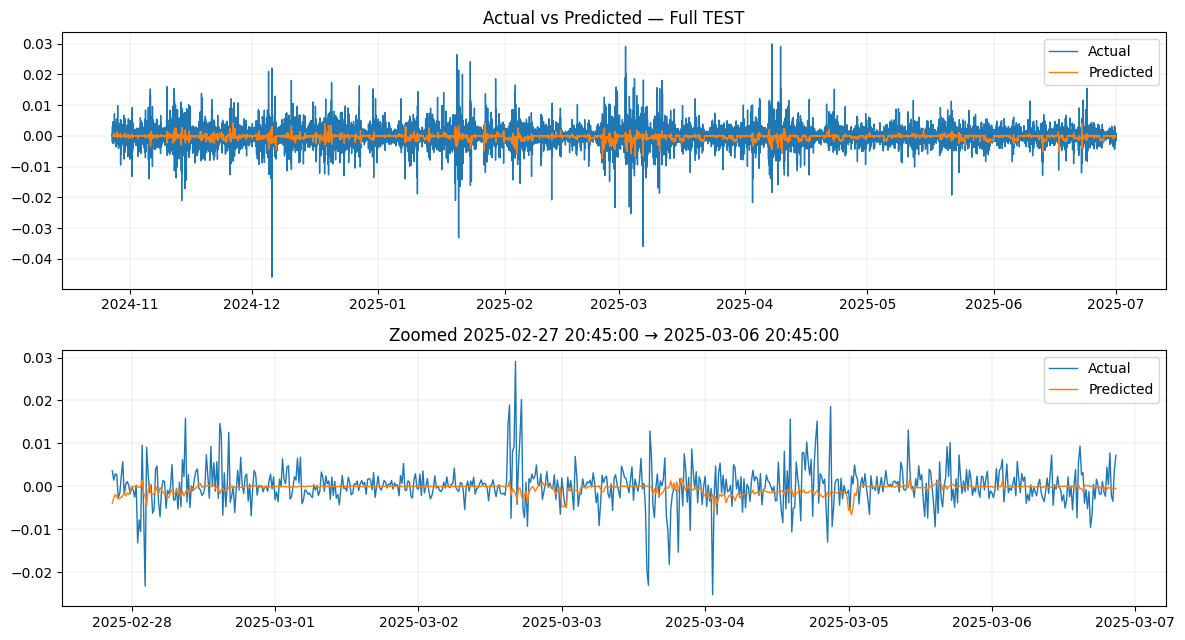

[Saved] /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/final_xgb_multi_actual_vs_pred.png


In [ ]:
# =====================================================
# Part 1: Train & Save Multimodal XGBoost (rf_multi)
# =====================================================

import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

# -----------------------
# CONFIG
# -----------------------
ART_DIR    = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot"
USE_GPU    = False
CAND_EST   = [200, 400, 800, 1200]
MODEL_PATH = os.path.join(ART_DIR, "final_xgb_multi.json")

# Optional manual zoom range (1 week)
PLOT_START = "2024-05-01 00:00:00"
PLOT_END   = "2024-05-07 23:59:59"

# -----------------------
# Helpers
# -----------------------
def set_device_params(use_gpu: bool):
    return dict(tree_method="gpu_hist", predictor="gpu_predictor") if use_gpu else dict(tree_method="hist")

def rmse(a,b): return float(np.sqrt(mean_squared_error(a,b)))

def dir_acc_deadband(y_true, y_pred, eps: float):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    mask = np.abs(y_true) >= eps
    if mask.sum() == 0: return np.nan
    return float(np.mean(np.sign(y_true[mask]) == np.sign(y_pred[mask])))

def load_xy(art_dir, tag):
    p = lambda n: os.path.join(art_dir, n)
    Xtr = pd.read_parquet(p(f"X_train_{tag}.parquet"))
    Xva = pd.read_parquet(p(f"X_val_{tag}.parquet"))
    Xte = pd.read_parquet(p(f"X_test_{tag}.parquet"))
    ytr = pd.read_parquet(p(f"y_train_{tag}.parquet"))["y"]
    yva = pd.read_parquet(p(f"y_val_{tag}.parquet"))["y"]
    yte = pd.read_parquet(p(f"y_test_{tag}.parquet"))["y"]
    return Xtr, ytr, Xva, yva, Xte, yte

def load_meta(art_dir):
    with open(os.path.join(art_dir, "meta.json")) as f:
        meta = json.load(f)
    return float(meta.get("epsilon_move_value", 0.0))

def auto_zoom_range(test_index, days=7):
    mid = test_index[len(test_index)//2]
    return mid, mid + pd.Timedelta(days=days)

def plot_actual_vs_pred(idx, y_true, y_pred, zoom_start=None, zoom_end=None):
    fig, axes = plt.subplots(2, 1, figsize=(12, 6.5))

    # Full TEST
    axes[0].plot(idx, y_true, label="Actual", linewidth=1)
    axes[0].plot(idx, y_pred, label="Predicted", linewidth=1)
    axes[0].set_title("Actual vs Predicted — Full TEST")
    axes[0].legend(); axes[0].grid(True, linewidth=0.3, alpha=0.5)

    # Zoom
    if zoom_start is not None and zoom_end is not None:
        z0, z1 = pd.Timestamp(zoom_start), pd.Timestamp(zoom_end)
    else:
        z0, z1 = auto_zoom_range(idx)

    mask = (idx >= z0) & (idx <= z1)
    if mask.sum() == 0:   # fallback if invalid range
        z0, z1 = auto_zoom_range(idx)
        mask = (idx >= z0) & (idx <= z1)

    axes[1].plot(idx[mask], y_true[mask], label="Actual", linewidth=1)
    axes[1].plot(idx[mask], y_pred[mask], label="Predicted", linewidth=1)
    axes[1].set_title(f"Zoomed {z0} → {z1}")
    axes[1].legend(); axes[1].grid(True, linewidth=0.3, alpha=0.5)

    plt.tight_layout()
    return fig

# -----------------------
# Load data
# -----------------------
eps = load_meta(ART_DIR)
Xtr, ytr, Xva, yva, Xte, yte = load_xy(ART_DIR, "rf_multi")
print(f"[DATA] Feats: {Xtr.shape[1]} | Train {len(Xtr)} | Val {len(Xva)} | Test {len(Xte)}")
print(f"[INFO] Using ε-deadband = {eps:.6f}")

# -----------------------
# Sweep for best n_estimators
# -----------------------
BASE_PARAMS = dict(
    objective="reg:squarederror",
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)

best_est, best_rmse = None, np.inf
for n in CAND_EST:
    model = xgb.XGBRegressor(**BASE_PARAMS, **set_device_params(USE_GPU), n_estimators=n)
    model.fit(Xtr, ytr)
    score = rmse(yva, model.predict(Xva))
    print(f"[SWEEP] n_estimators={n:<4d}   VAL_RMSE={score:.6f}")
    if score < best_rmse:
        best_rmse, best_est = score, n

print(f"[SELECT] n_estimators={best_est} (VAL_RMSE={best_rmse:.6f})")

# -----------------------
# Retrain on TRAIN+VAL
# -----------------------
X_trv = pd.concat([Xtr, Xva], axis=0)
y_trv = pd.concat([ytr, yva], axis=0)
final_model = xgb.XGBRegressor(**BASE_PARAMS, **set_device_params(USE_GPU), n_estimators=best_est)
final_model.fit(X_trv, y_trv)

final_model.save_model(MODEL_PATH)
print(f"[OK] Final multimodal XGBoost saved → {MODEL_PATH}")

# -----------------------
# Evaluate
# -----------------------
y_test_pred = final_model.predict(Xte)
metrics = dict(
    RMSE=rmse(yte, y_test_pred),
    MAE=mean_absolute_error(yte, y_test_pred),
    R2=r2_score(yte, y_test_pred),
    DirAcc=dir_acc_deadband(yte, y_test_pred, eps)
)
print(f"[TEST] RMSE={metrics['RMSE']:.6f}  MAE={metrics['MAE']:.6f}  "
      f"R2={metrics['R2']:.3f}  DirAcc(ε)={metrics['DirAcc']:.3f}")

# -----------------------
# Save plots
# -----------------------
fig = plot_actual_vs_pred(Xte.index, yte.values, y_test_pred,
                          zoom_start=PLOT_START, zoom_end=PLOT_END)
plot_path = os.path.join(ART_DIR, "final_xgb_multi_actual_vs_pred.png")
fig.savefig(plot_path, dpi=160); plt.show()
print(f"[Saved] {plot_path}")

**Step 2 — SHAP (Global + Local) on Saved Model**


=== Global SHAP ===


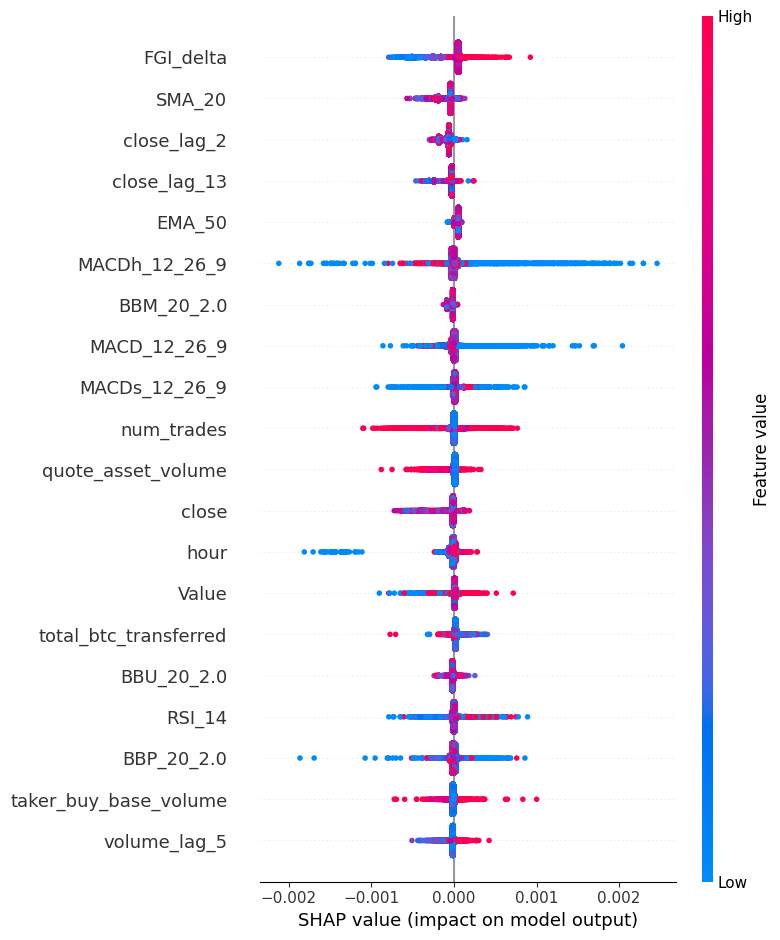

[Saved] /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_beeswarm.png


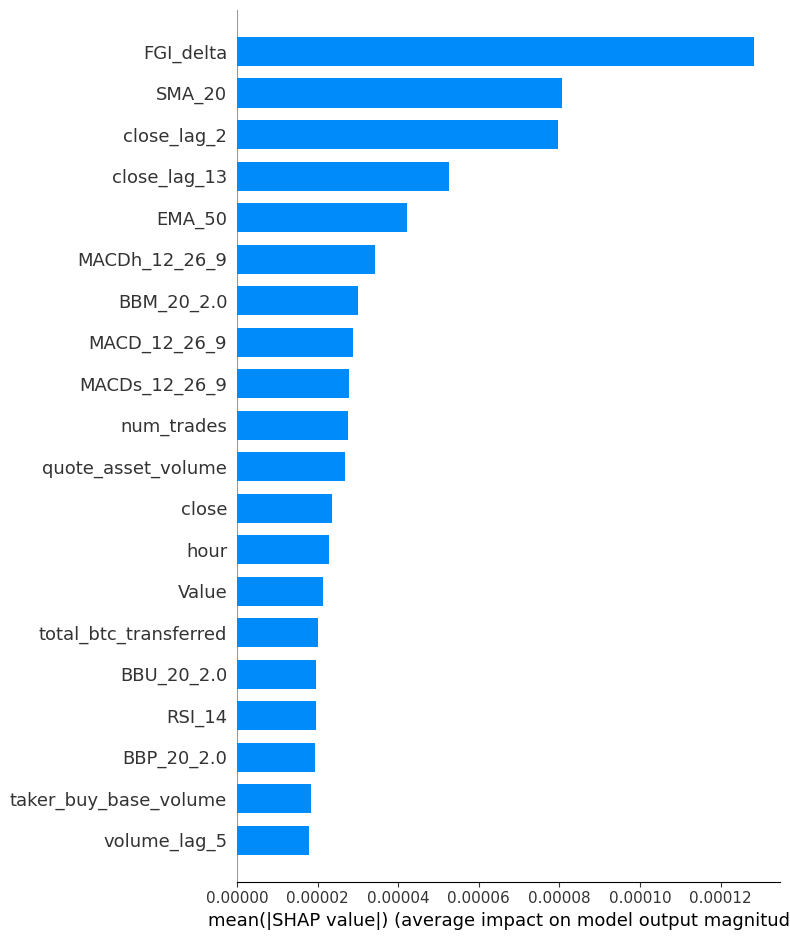

[Saved] /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_bar.png

=== Local SHAP (3 examples) ===


<Figure size 800x500 with 0 Axes>

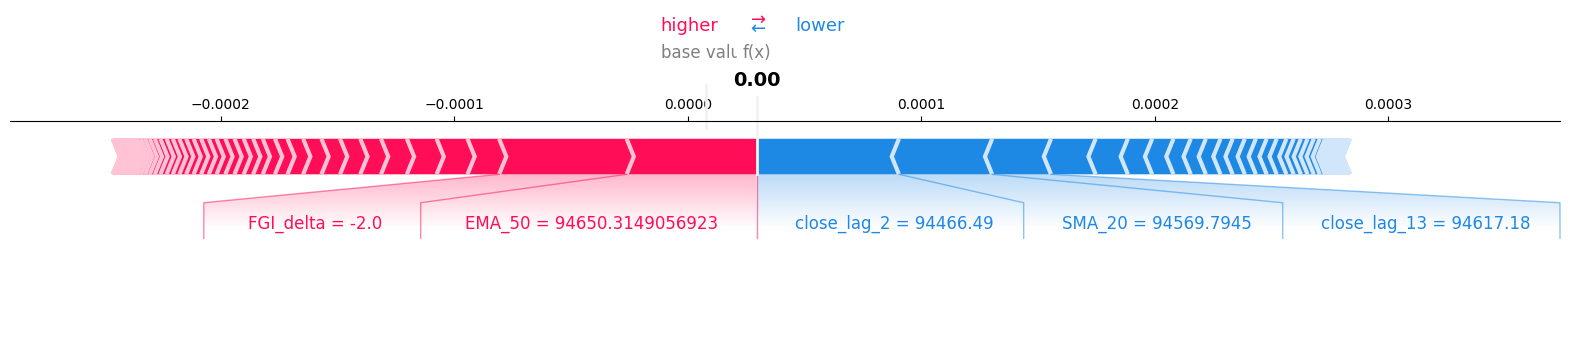

[Saved] Local SHAP → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_local_20241228_0715.png


<Figure size 800x500 with 0 Axes>

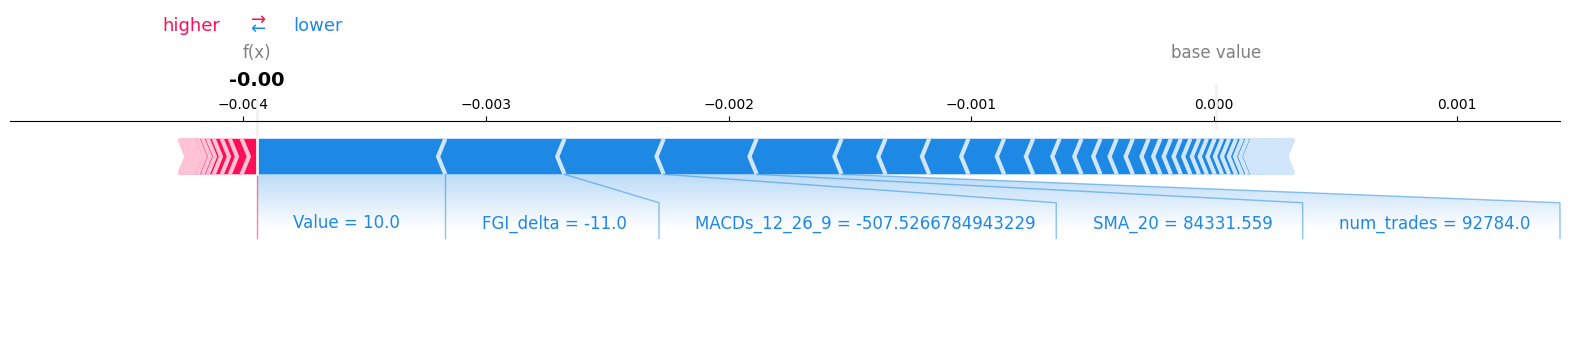

[Saved] Local SHAP → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_local_20250227_2045.png


<Figure size 800x500 with 0 Axes>

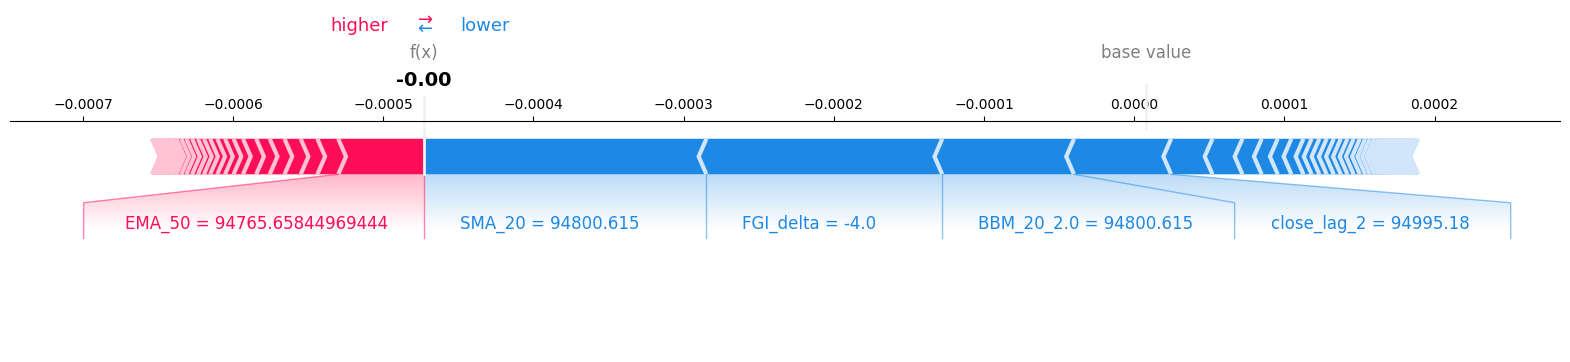

[Saved] Local SHAP → /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_local_20250430_1000.png

[OK] Global and Local SHAP visualizations completed and saved.


In [ ]:
# =====================================================
# Part 2: SHAP Explainability (Global + Local)
# =====================================================

import shap, matplotlib.pyplot as plt

# -----------------------
# Reload model
# -----------------------
final_model = xgb.XGBRegressor()
final_model.load_model(MODEL_PATH)

# Use TEST data
_, _, _, _, Xte, yte = load_xy(ART_DIR, "rf_multi")

# -----------------------
# Global SHAP
# -----------------------
print("\n=== Global SHAP ===")

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(Xte)

# Beeswarm
plt.figure()
shap.summary_plot(shap_values, Xte, plot_type="dot", show=False)
beeswarm_path = os.path.join(ART_DIR, "shap_beeswarm.png")
plt.savefig(beeswarm_path, dpi=160, bbox_inches="tight")
plt.show()
plt.close()
print(f"[Saved] {beeswarm_path}")

# Bar
plt.figure()
shap.summary_plot(shap_values, Xte, plot_type="bar", show=False)
bar_path = os.path.join(ART_DIR, "shap_bar.png")
plt.savefig(bar_path, dpi=160, bbox_inches="tight")
plt.show()
plt.close()
print(f"[Saved] {bar_path}")

# -----------------------
# Local SHAP (3 timestamps)
# -----------------------
print("\n=== Local SHAP (3 examples) ===")

sample_idx = [Xte.index[len(Xte)//4],
              Xte.index[len(Xte)//2],
              Xte.index[3*len(Xte)//4]]

for ts in sample_idx:
    row = Xte.loc[[ts]]
    shap_val_row = explainer.shap_values(row)

    plt.figure(figsize=(8,5))
    shap.force_plot(explainer.expected_value, shap_val_row, row,
                    matplotlib=True, show=False)
    out_path = os.path.join(ART_DIR, f"shap_local_{ts.strftime('%Y%m%d_%H%M')}.png")
    plt.savefig(out_path, dpi=160, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"[Saved] Local SHAP → {out_path}")

print("\n[OK] Global and Local SHAP visualizations completed and saved.")

# **LLM Based Explanability using Perplexity API**

In [ ]:
!pip -q install --upgrade openai
import os

assert os.getenv("PPLX_API_KEY"), "Set PPLX_API_KEY env var first."


In [ ]:
from openai import OpenAI

client = OpenAI(
    api_key=os.getenv("PPLX_API_KEY"),
    base_url="https://api.perplexity.ai"
)

In [ ]:
SYS_PROMPT = """
You are a concise financial explainer. You will receive ONE image (a SHAP LOCAL force plot).
Return a single JSON object ONLY (no extra text).

Rules:
- Derive the net prediction direction/magnitude (▲/▼ and percent). If the exact value isn’t visible, estimate from relative red (up) vs blue (down) pushes; round to one decimal place. Use "direction": "up" | "down" | "flat".
- Identify top 3–5 drivers. Translate technical names to simple English:
  MACD → market momentum; SMA/EMA/Bollinger → recent price trend; FGI_delta → fear & greed change; volume/num_trades → trading activity; news_* → news signal; whale_* → whale accumulation.
- Estimate each driver’s impact so the percentages sum ≈100 (adjust last item if needed). Use "direction" per driver: "up" or "down".
- No invented drivers; stay faithful to the plot.

Schema:
{
  "headline": "Predicted ▲X.X% due to:",
  "predicted_pct": <float>,             // signed, e.g. 1.2 or -0.3
  "direction": "up" | "down" | "flat",
  "drivers": [
    { "text": "<plain driver>", "impact_pct": <int 0-100>, "direction": "up" | "down" }
  ]
}
"""

In [ ]:
import base64, json, re, os

def b64(path):
    with open(path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def parse_json_loose(text: str):
    # try strict
    try:
        return json.loads(text)
    except:
        pass
    # fallback: grab first {...} blob
    m = re.search(r"\{.*\}", text, flags=re.S)
    if not m:
        raise ValueError("Could not parse JSON from model output:\n" + text[:500])
    return json.loads(m.group(0))

def normalize_impacts(drivers):
    # make impacts sum exactly 100
    raw = [max(0, int(round(d.get("impact_pct", 0)))) for d in drivers]
    s = sum(raw) or 1
    scaled = [int(round(100 * v / s)) for v in raw]
    diff = 100 - sum(scaled)
    if scaled:
        scaled[-1] += diff
    for i, d in enumerate(drivers):
        d["impact_pct"] = scaled[i]
    return drivers

def make_headline(predicted_pct, direction):
    arrow = "▲" if (direction == "up" or (direction not in ("up","down","flat") and predicted_pct >= 0)) else "▼"
    return f"Predicted {arrow}{abs(float(predicted_pct)):.1f}% due to:"

In [ ]:
def explain_from_image_perplexity(image_path, model="sonar-pro"):
    # NOTE: sonar-pro supports images; avoid sonar-deep-research for image input.
    # Images can be passed as base64 data URIs. :contentReference[oaicite:2]{index=2}
    data_uri = f"data:image/png;base64,{b64(image_path)}"
    resp = client.chat.completions.create(
        model=model,
        temperature=0.1,
        messages=[
            {"role":"system","content": SYS_PROMPT},
            {"role":"user","content":[
                {"type":"text","text":"Read this SHAP LOCAL plot and return JSON only."},
                {"type":"image_url","image_url":{"url": data_uri}}
            ]}
        ]
    )
    raw = resp.choices[0].message.content.strip()
    data = parse_json_loose(raw)

    # ensure headline + impacts are clean
    data["drivers"] = normalize_impacts(data.get("drivers", []))
    if "predicted_pct" in data:
        data["headline"] = make_headline(data["predicted_pct"], data.get("direction", ""))
    return data

In [ ]:
def extract_ts_from_filename(path):
    # e.g., shap_local_20241228_0715.png → "2024-12-28 07:15"
    m = re.search(r"(\d{8})_(\d{4})", os.path.basename(path))
    if not m: return ""
    ymd, hm = m.groups()
    return f"{ymd[:4]}-{ymd[4:6]}-{ymd[6:]} {hm[:2]}:{hm[2:]}"

def img_to_data_url(path):
    mime = "image/png" if path.lower().endswith(".png") else "image/jpeg"
    return f"data:{mime};base64,{b64(path)}"

def render_cards_html(items):
    css = """
    <style>
    :root { --bg:#0f1220; --card:#171a2b; --text:#e8eaf6; --muted:#b8bcd8; --up:#3bd671; --down:#ff6b6b; --chip:#272b45; --ring:#2b2f4a; }
    *{box-sizing:border-box} body{margin:0;padding:32px;background:var(--bg);color:var(--text);font:15px/1.5 Inter,system-ui,Segoe UI,Roboto,Arial}
    h1{margin:0 0 16px;font-size:20px;font-weight:700}
    .grid{display:grid;grid-template-columns:repeat(auto-fit,minmax(340px,1fr));gap:16px}
    .card{background:radial-gradient(1200px 600px at -10% -10%,#212548 0%,var(--card) 48%);border:1px solid var(--ring);border-radius:18px;padding:18px;box-shadow:0 8px 24px rgba(0,0,0,.25)}
    .row{display:flex;align-items:center;justify-content:space-between;gap:10px}
    .headline{font-size:18px;font-weight:700;letter-spacing:.2px}
    .stamp{color:var(--muted);font-size:12px}
    .bullets{margin:10px 0 0;padding:0;list-style:none;display:grid;gap:8px}
    .bullet{display:flex;align-items:center;justify-content:space-between;gap:8px;background:var(--chip);border:1px solid var(--ring);border-radius:12px;padding:10px 12px}
    .label{color:var(--text)}
    .impact{font-weight:700;padding:4px 8px;border-radius:999px;min-width:64px;text-align:center;background:#1d213a;border:1px solid var(--ring)}
    .impact.up{color:var(--up)} .impact.down{color:var(--down)}
    .thumb{margin-top:12px;border-radius:10px;border:1px solid var(--ring);width:100%}
    </style>
    """
    html = ["<html><head><meta charset='utf-8'>", css, "</head><body>"]
    html.append("<h1>Local SHAP Narratives</h1><div class='grid'>")
    for it in items:
        d = it["data"]
        headline = d.get("headline","Prediction")
        as_of = it.get("as_of","")
        html.append("<div class='card'>")
        html.append(f"<div class='row'><div class='headline'>{headline}</div><div class='stamp'>{as_of}</div></div>")
        html.append("<ul class='bullets'>")
        for b in d.get("drivers", []):
            txt = b.get("text","")
            pct = int(b.get("impact_pct",0))
            dirc = (b.get("direction","") or "").lower()
            cls = "up" if dirc=="up" else ("down" if dirc=="down" else "")
            sign = "+" if dirc=="up" else ("–" if dirc=="down" else "")
            html.append(f"<li class='bullet'><div class='label'>{txt}</div><div class='impact {cls}'>{sign}{pct}%</div></li>")
        html.append("</ul>")
        if it.get("image_data_url"):
            html.append(f"<img class='thumb' src='{it['image_data_url']}' alt='SHAP plot'>")
        html.append("</div>")
    html.append("</div></body></html>")
    return "".join(html)

In [ ]:
paths = [
  "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_local_20241228_0715.png",
  "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_local_20250227_2045.png",
  "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_local_20250430_1000.png"
]

items = []
for p in paths:
    try:
        data = explain_from_image_perplexity(p, model="sonar-pro")
    except Exception as e:
        # fall back to a placeholder if the API call fails (quota/rate/etc.)
        data = {
            "headline": "Predicted ▼0.0% due to:",
            "predicted_pct": 0.0, "direction": "flat",
            "drivers": [
                {"text":"Could not fetch explanation (API error). Check key/limits.", "impact_pct": 100, "direction":"down"}
            ]
        }
        print(f"[WARN] {e}")
    items.append({
        "image_data_url": img_to_data_url(p),
        "as_of": extract_ts_from_filename(p),
        "data": data
    })

html = render_cards_html(items)
out_path = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_narratives_perplexity.html"
with open(out_path, "w", encoding="utf-8") as f:
    f.write(html)
print(f"[Saved] {out_path}")

[Saved] /content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_narratives_perplexity.html



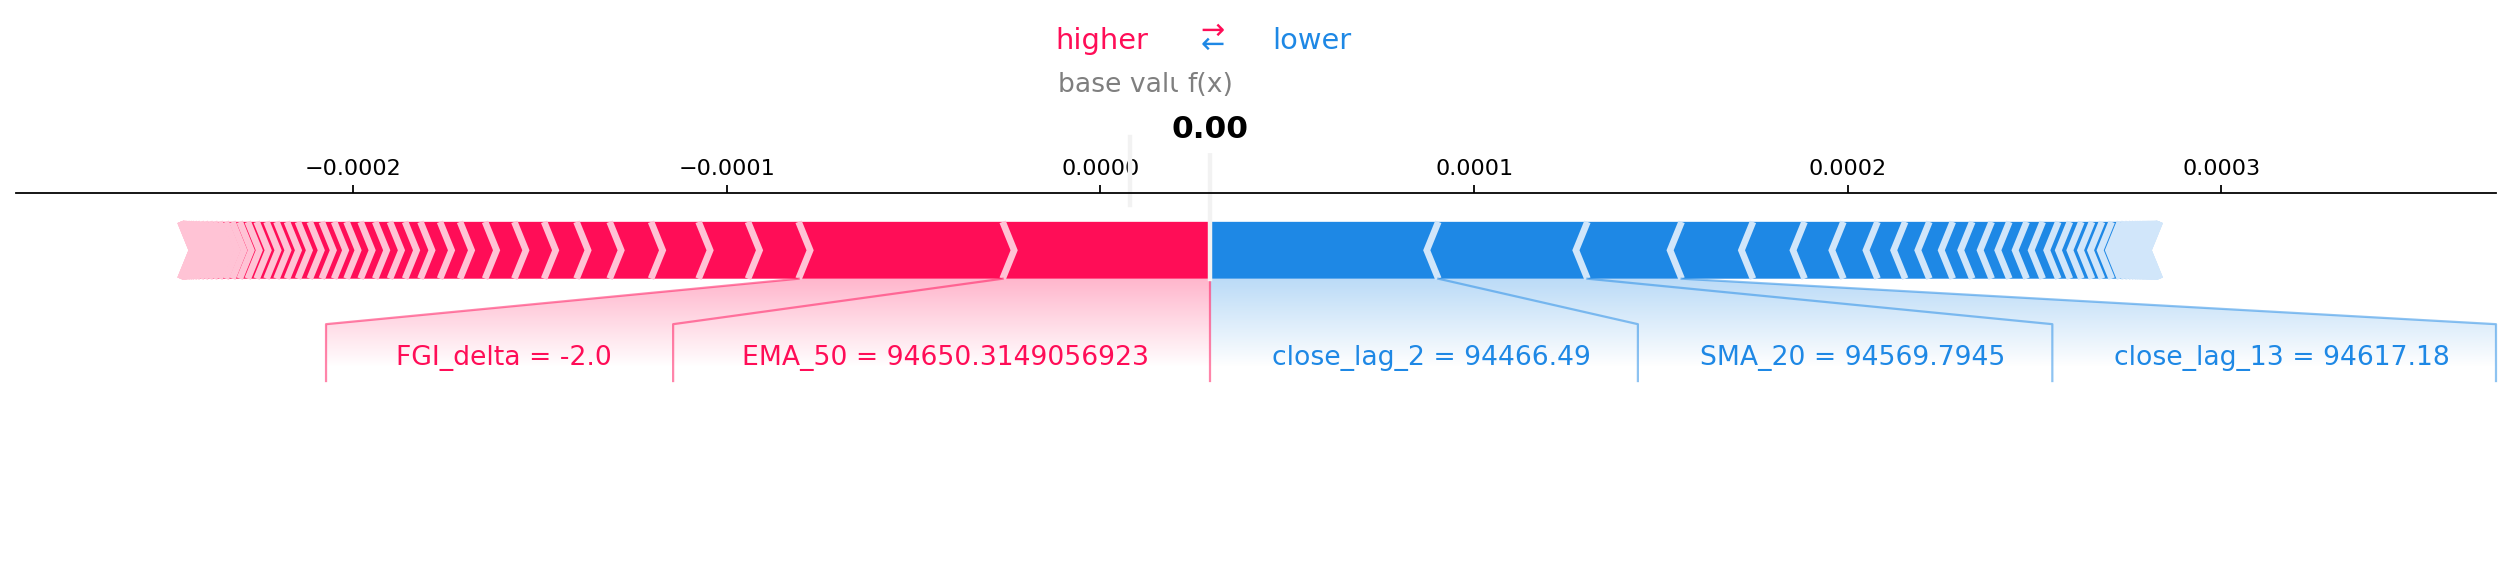
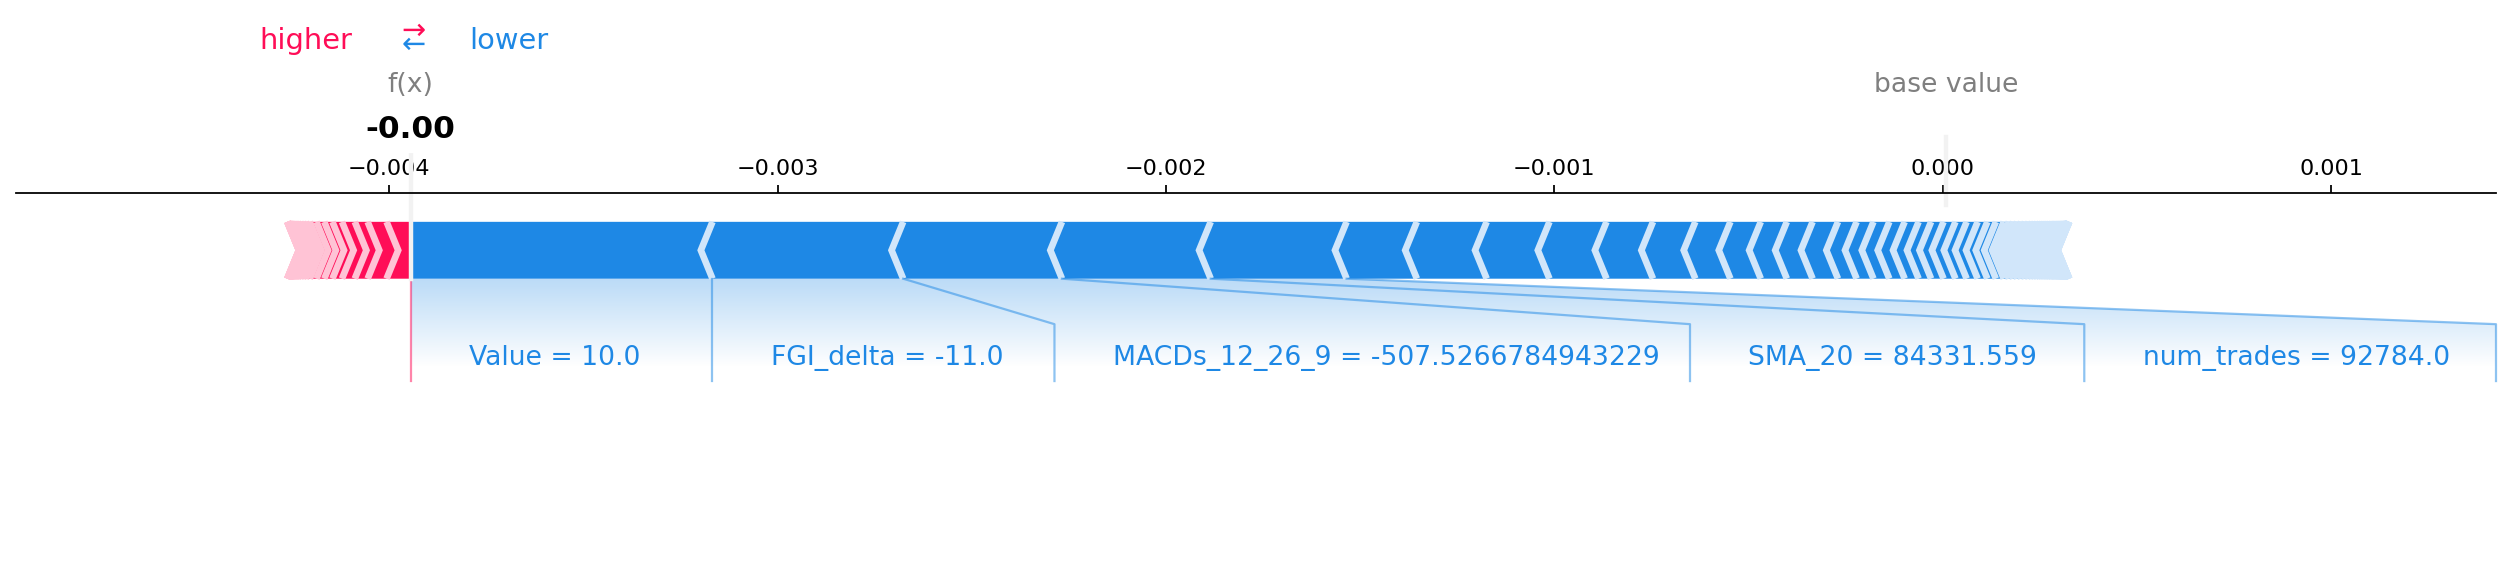
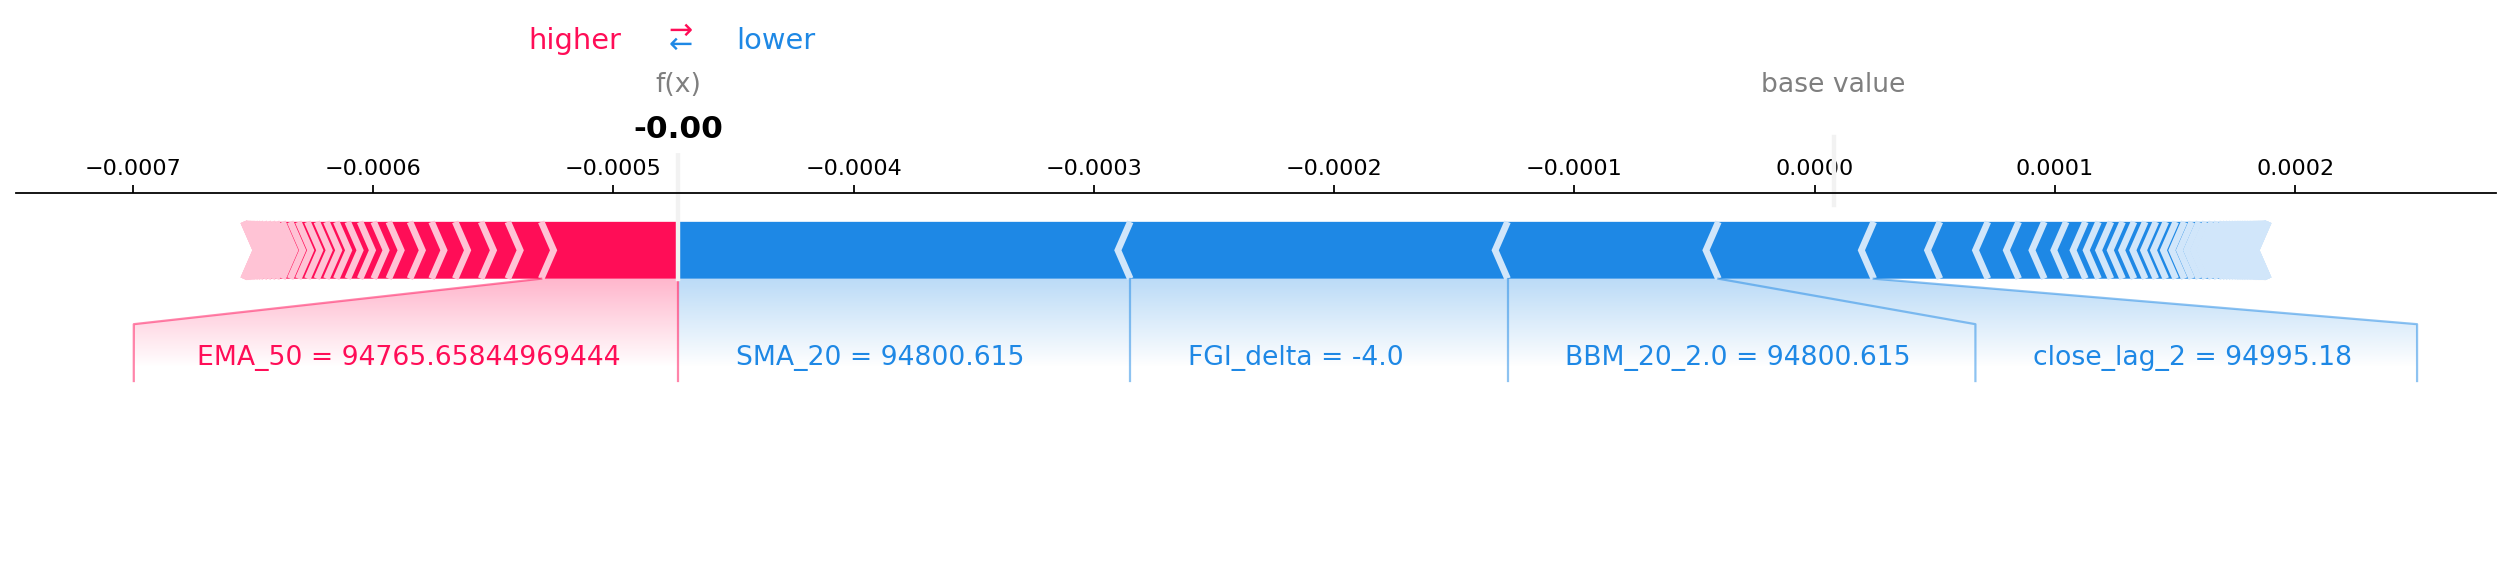

In [ ]:
from IPython.display import HTML
path = "/content/drive/MyDrive/Thesis/Reusable/prep_snapshot/shap_narratives_perplexity.html"
HTML(filename=path)  # renders the page right here

# **Apendix 1: MFB(Closing Price)**

## **Full dataset**

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ price_input         │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ onchain_input       │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fgi_input           │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ news_input          │ (None, 24)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reddit_input        │ (None, 26)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_60 (Dense)    │ (None, 64)        │      1,664 │ price_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_62 (Dense)    │ (None, 64)        │        576 │ onchain_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_64 (Dense)    │ (None, 64)        │        576 │ fgi_input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_66 (Dense)    │ (None, 64)        │      1,600 │ news_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_68 (Dense)    │ (None, 64)        │      1,728 │ reddit_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_60[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_62[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_64[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_66[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_68[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_32          │ (None, 64)        │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 46,753 (182.63 KB)

 Trainable params: 46,113 (180.13 KB)

 Non-trainable params: 640 (2.50 KB)

Epoch 1/50
862/862 - 18s - 21ms/step - loss: 167516688.0000 - mae: 6999.3267 - val_loss: 17432704.0000 - val_mae: 3743.8694 - learning_rate: 1.0000e-03
Epoch 2/50
862/862 - 3s - 4ms/step - loss: 10008503.0000 - mae: 2457.5845 - val_loss: 5790505.5000 - val_mae: 1946.2179 - learning_rate: 1.0000e-03
Epoch 3/50
862/862 - 3s - 3ms/step - loss: 9207538.0000 - mae: 2329.4990 - val_loss: 2974471.5000 - val_mae: 1270.1284 - learning_rate: 1.0000e-03
Epoch 4/50
862/862 - 3s - 3ms/step - loss: 8542124.0000 - mae: 2230.2629 - val_loss: 2119746.7500 - val_mae: 1054.7694 - learning_rate: 1.0000e-03
Epoch 5/50
862/862 - 3s - 3ms/step - loss: 8139709.0000 - mae: 2173.8235 - val_loss: 5551801.5000 - val_mae: 2133.7041 - learning_rate: 1.0000e-03
Epoch 6/50
862/862 - 3s - 4ms/step - loss: 7961043.0000 - mae: 2139.7732 - val_loss: 3857580.5000 - val_mae: 1711.9188 - learning_rate: 1.0000e-03
Epoch 7/50

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
862/862 - 3s - 4ms/step 

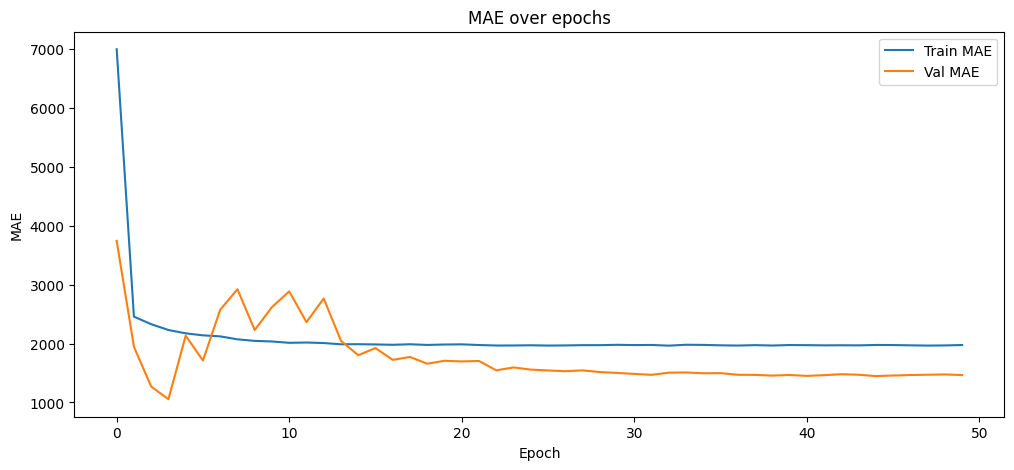

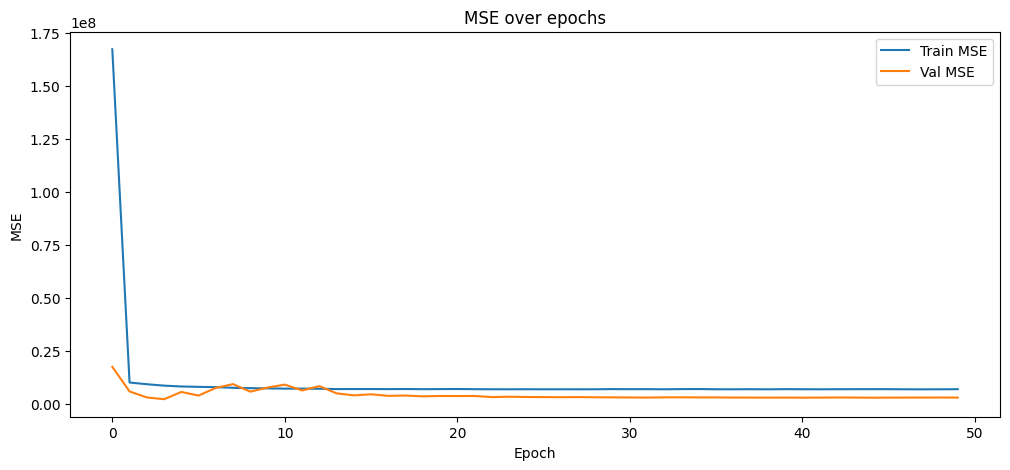

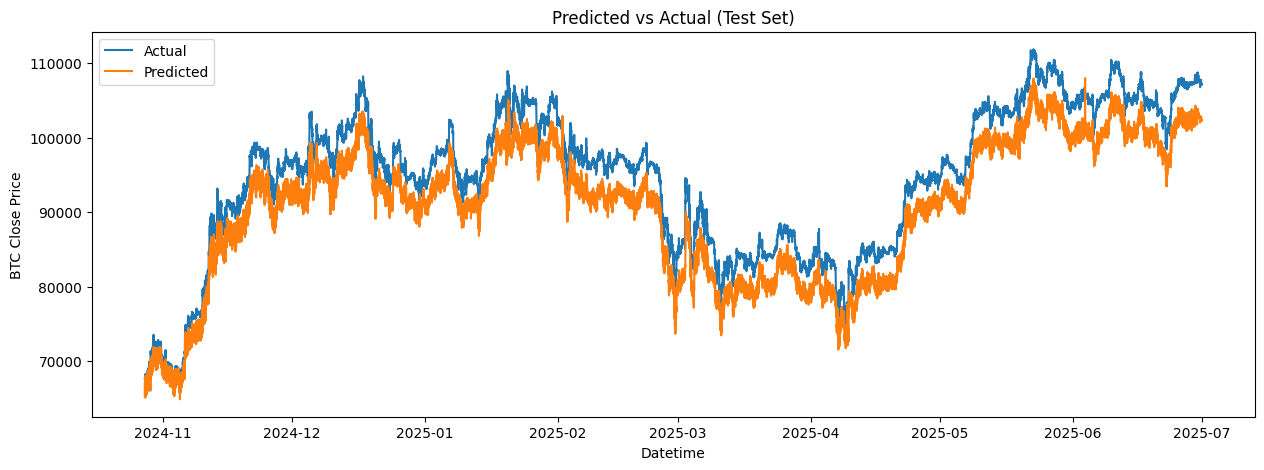

Model saved to /content/drive/MyDrive/Thesis/saved_model


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os

#
random.seed(42)
np.random.seed(42)

# ===========================
# 1️⃣ Load dataset
# ===========================
df = pd.read_csv('/content/drive/MyDrive/Thesis/final_master_df.csv', index_col=0)
df.index = pd.to_datetime(df.index)
df = df.sort_index()

# ===========================
# 2️⃣ Define column groups
# ===========================
price_cols = ['open','high','low','SMA_20','EMA_50','BBL_20_2.0','BBM_20_2.0','BBU_20_2.0',
              'BBB_20_2.0','BBP_20_2.0','OBV','hour','day_of_week',
              'close_lag_1','volume_lag_1','close_lag_2','volume_lag_2',
              'close_lag_3','volume_lag_3','close_lag_5','volume_lag_5',
              'close_lag_8','volume_lag_8','close_lag_13','volume_lag_13']

onchain_cols = ['active_addresses','avg_block_interval_secs','avg_block_size_bytes','avg_tx_fee_btc',
                'miner_revenue_btc','total_btc_transferred','tx_count','Value']

fgi_cols = ['FGI_7d_avg','FGI_delta','Sentiment_Level','FGI_Classification_Extreme Fear',
            'FGI_Classification_Extreme Greed','FGI_Classification_Fear','FGI_Classification_Greed',
            'FGI_Classification_Neutral']

news_cols = [col for col in df.columns if col.startswith('news_')]
reddit_cols = [col for col in df.columns if col.startswith('reddit_')]

# ===========================
# 3️⃣ Target
# ===========================
df['target'] = df['target']  # already exists, assumed next-step target
X_price = df[price_cols].copy()
X_onchain = df[onchain_cols].copy()
X_fgi = df[fgi_cols].copy()
X_news = df[news_cols].copy()
X_reddit = df[reddit_cols].copy()
y = df['target'].copy()

# ===========================
# 4️⃣ Train / Validation / Test split (70/15/15)
# ===========================
train_size = 0.7
val_size = 0.15
test_size = 0.15

# Step 1: Split off test
X_price_trainval, X_price_test, y_trainval, y_test = train_test_split(
    X_price, y, test_size=test_size, shuffle=False
)
X_onchain_trainval, X_onchain_test = train_test_split(X_onchain, test_size=test_size, shuffle=False)
X_fgi_trainval, X_fgi_test = train_test_split(X_fgi, test_size=test_size, shuffle=False)
X_news_trainval, X_news_test = train_test_split(X_news, test_size=test_size, shuffle=False)
X_reddit_trainval, X_reddit_test = train_test_split(X_reddit, test_size=test_size, shuffle=False)

# Step 2: Split train vs val
val_fraction = val_size / (train_size + val_size)
X_train_price, X_val_price, \
X_train_onchain, X_val_onchain, \
X_train_fgi, X_val_fgi, \
X_train_news, X_val_news, \
X_train_reddit, X_val_reddit, \
y_train, y_val = train_test_split(
    X_price_trainval, X_onchain_trainval, X_fgi_trainval, X_news_trainval, X_reddit_trainval, y_trainval,
    test_size=val_fraction, shuffle=False
)

# ===========================
# 5️⃣ Scale features
# ===========================
scalers = {}
for name, X_tr, X_val_ in zip(
    ['price','onchain','fgi','news','reddit'],
    [X_train_price, X_train_onchain, X_train_fgi, X_train_news, X_train_reddit],
    [X_val_price, X_val_onchain, X_val_fgi, X_val_news, X_val_reddit]
):
    scaler = StandardScaler().fit(X_tr)
    globals()[f'X_train_{name}'] = scaler.transform(X_tr)
    globals()[f'X_val_{name}'] = scaler.transform(X_val_)
    scalers[name] = scaler

# Scale test
X_test_price = scalers['price'].transform(X_price_test)
X_test_onchain = scalers['onchain'].transform(X_onchain_test)
X_test_fgi = scalers['fgi'].transform(X_fgi_test)
X_test_news = scalers['news'].transform(X_news_test)
X_test_reddit = scalers['reddit'].transform(X_reddit_test)

# ===========================
# 6️⃣ Build multi-input model
# ===========================
def build_model():
    price_input = Input(shape=(X_train_price.shape[1],), name='price_input')
    onchain_input = Input(shape=(X_train_onchain.shape[1],), name='onchain_input')
    fgi_input = Input(shape=(X_train_fgi.shape[1],), name='fgi_input')
    news_input = Input(shape=(X_train_news.shape[1],), name='news_input')
    reddit_input = Input(shape=(X_train_reddit.shape[1],), name='reddit_input')

    def dense_block(x):
        x = Dense(64, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)
        x = Dense(32, activation='relu')(x)
        return x

    price_branch = dense_block(price_input)
    onchain_branch = dense_block(onchain_input)
    fgi_branch = dense_block(fgi_input)
    news_branch = dense_block(news_input)
    reddit_branch = dense_block(reddit_input)

    merged = Concatenate()([price_branch, onchain_branch, fgi_branch, news_branch, reddit_branch])
    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.2)(x)
    x = Dense(64, activation='relu')(x)
    output = Dense(1, name='regression_output')(x)

    model = Model(inputs=[price_input, onchain_input, fgi_input, news_input, reddit_input], outputs=output)
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

model = build_model()
model.summary()

# ===========================
# 7️⃣ Callbacks
# ===========================
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# ===========================
# 8️⃣ Train
# ===========================
history = model.fit(
    [X_train_price, X_train_onchain, X_train_fgi, X_train_news, X_train_reddit],
    y_train,
    validation_data=([X_val_price, X_val_onchain, X_val_fgi, X_val_news, X_val_reddit], y_val),
    epochs=50,
    batch_size=128,
    callbacks=[reduce_lr],
    verbose=2
)

# ===========================
# 9️⃣ Evaluate on validation
# ===========================
y_pred_val = model.predict([X_val_price, X_val_onchain, X_val_fgi, X_val_news, X_val_reddit])
mae = mean_absolute_error(y_val, y_pred_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
r2 = r2_score(y_val, y_pred_val)
print(f"[VAL RESULT] MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}")

# ===========================
# 10️⃣ Evaluate on test
# ===========================
y_pred_test = model.predict([X_test_price, X_test_onchain, X_test_fgi, X_test_news, X_test_reddit])
mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
print(f"[TEST RESULT] MAE={mae_test:.2f}, RMSE={rmse_test:.2f}, R²={r2_test:.4f}")

# ===========================
# 11️⃣ Plot training history
# ===========================
plt.figure(figsize=(12,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('MAE over epochs')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train MSE')
plt.plot(history.history['val_loss'], label='Val MSE')
plt.title('MSE over epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

# ===========================
# 12️⃣ Plot predicted vs actual (test)
# ===========================
plt.figure(figsize=(15,5))
plt.plot(df.index[-len(y_test):], y_test.values, label='Actual')
plt.plot(df.index[-len(y_test):], y_pred_test.flatten(), label='Predicted')
plt.xlabel('Datetime')
plt.ylabel('BTC Close Price')
plt.title('Predicted vs Actual (Test Set)')
plt.legend()
plt.show()

# ===========================
# 13️⃣ Save model
# ===========================
output_dir = '/content/drive/MyDrive/Thesis/saved_model'
os.makedirs(output_dir, exist_ok=True)
model.save(os.path.join(output_dir, 'multi_input_btc_model.h5'))
print(f"Model saved to {output_dir}")

## **6 month period**

In [ ]:
# ============================== #
#  Multimodal 6-Month Windows    #
#  Training & Evaluation Script  #
#  + Directional Accuracy        #
#   (FIXED FOR DATA LEAKAGE)    #
# ============================== #

import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Reproducibility (best-effort)
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)
tf.keras.backend.set_floatx('float32')

from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ------------------------------
# User-configurable paths & flags
# ------------------------------
MASTER_CSV_PATH   = "/content/drive/MyDrive/Thesis/final_master_df.csv"
RESULTS_CSV_PATH  = "/content/drive/MyDrive/Thesis/window_results.csv"
PLOTS_DIR         = "/content/drive/MyDrive/Thesis/window_plots"

MONTHS_PER_WINDOW = 6
BATCH_SIZE        = 128
EPOCHS            = 50
MIN_SAMPLES_AFTER_CLEAN = 1000  # skip tiny windows

# IMPORTANT:
# If target is absolute price -> True (DA on price is not meaningful)
# If target is next-step log return -> False (recommended; DA is meaningful)
SCALE_TARGET      = False
TARGET_COL        = "target"

# Directional accuracy config (for return targets)
# Deadband example for returns: 0.0005 = 5 bps
DEADBAND          = 0.0

# ------------------------------
# Utilities: dirs
# ------------------------------
Path(PLOTS_DIR).mkdir(parents=True, exist_ok=True)

# ------------------------------
# Data cleaning utilities
# ------------------------------
def _coerce_numeric(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for c in out.columns:
        if not pd.api.types.is_numeric_dtype(out[c]):
            out[c] = pd.to_numeric(out[c], errors="coerce")
    return out.replace([np.inf, -np.inf], np.nan)

def _impute_timewise(df: pd.DataFrame) -> pd.DataFrame:
    # Forward/Backward fill within the window; remaining -> 0
    return df.ffill().bfill().fillna(0.0)

def _drop_near_constant(df: pd.DataFrame, thresh: float = 1e-15):
    variances = df.var(axis=0, numeric_only=True)
    keep_cols = [c for c in df.columns if c in variances.index and float(variances[c]) > thresh]
    removed = [c for c in df.columns if c not in keep_cols]
    return df[keep_cols], removed

# ------------------------------
# Grouping (auto-detect)
# ------------------------------
ONCHAIN_KNOWN = {
    "active_addresses", "avg_block_interval_secs", "avg_block_size_bytes",
    "avg_tx_fee_btc", "miner_revenue_btc", "total_btc_transferred", "tx_count"
}

def split_groups(df: pd.DataFrame, target_col: str = TARGET_COL):
    cols = [c for c in df.columns if c != target_col]

    news   = [c for c in cols if c.lower().startswith("news_")]
    reddit = [c for c in cols if c.lower().startswith("reddit_")]
    fgi    = [c for c in cols if c.lower().startswith("fgi_") or c.lower().startswith("fear_greed")]
    onch   = [c for c in cols if c.lower().startswith("onchain_") or c in ONCHAIN_KNOWN]

    reserved = set(news + reddit + fgi + onch + [target_col])
    price   = [c for c in cols if c not in reserved]

    # numeric only
    def _num(arr): return [c for c in arr if pd.api.types.is_numeric_dtype(df[c])]
    groups = {
        "price":   _num(price),
        "onchain": _num(onch),
        "fgi":     _num(fgi),
        "news":    _num(news),
        "reddit":  _num(reddit),
    }
    groups = {k: v for k, v in groups.items() if len(v) > 0}
    if "price" not in groups:
        raise ValueError("No price/technical columns detected after numeric filtering.")
    return groups

# ------------------------------
# Model builder (dynamic shapes)
# ------------------------------
def build_multimodal_model_dynamic(group_shapes: dict) -> keras.Model:
    inputs, branches = [], []

    def branch(inp):
        x = keras.layers.Dense(64)(inp)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(0.3)(x)
        x = keras.layers.Dense(32)(x)
        return x

    for name, dim in group_shapes.items():
        inp = keras.Input(shape=(dim,), name=f"{name}_input")
        inputs.append(inp)
        branches.append(branch(inp))

    merged = branches[0] if len(branches) == 1 else keras.layers.Concatenate(name="concat")(branches)
    x = keras.layers.Dense(128, activation="relu")(merged)
    x = keras.layers.Dropout(0.3)(x)
    x = keras.layers.Dense(64, activation="relu")(x)
    out = keras.layers.Dense(1, name="regression_output")(x)

    model = keras.Model(inputs=inputs, outputs=out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

# ------------------------------
# Window generation (chronological)
# ------------------------------
def generate_windows(df: pd.DataFrame, start_date, end_date, months=6):
    windows = []
    cur = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)
    while cur < end:
        ws = cur
        we = (cur + pd.DateOffset(months=months)) - pd.Timedelta(minutes=15)
        mask = (df.index >= ws) & (df.index <= we)
        if mask.sum() > 0:
            windows.append((ws, we, df.loc[mask]))
        cur += pd.DateOffset(months=months)
    return windows

# ------------------------------
# Plot helpers
# ------------------------------
def plot_metric_over_time(results_df: pd.DataFrame, metric: str, save_path: str):
    plt.figure(figsize=(9, 4.5))
    xs = range(1, len(results_df) + 1)
    ys = results_df[metric].values
    plt.plot(xs, ys, marker='o')
    plt.xticks(xs)
    plt.title(f"{metric} across windows")
    plt.xlabel("Window index (chronological)")
    plt.ylabel(metric)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.tight_layout()
    plt.savefig(save_path, dpi=160)
    plt.close()

# ------------------------------
# Directional accuracy helpers
# ------------------------------
def directional_accuracy(y_true: np.ndarray, y_pred: np.ndarray, deadband: float = 0.0) -> float:
    """
    Computes directional accuracy on returns-like targets.
    deadband: treat values with |value| <= deadband as 0 (no-change).
    """
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()

    if deadband > 0.0:
        s_true = np.where(np.abs(y_true) <= deadband, 0.0, np.sign(y_true))
        s_pred = np.where(np.abs(y_pred) <= deadband, 0.0, np.sign(y_pred))
    else:
        s_true = np.sign(y_true)
        s_pred = np.sign(y_pred)

    return float(np.mean(s_true == s_pred))

# ------------------------------
# Main experiment loop
# ------------------------------
def run_experiments_fixed(
    df: pd.DataFrame,
    target_col: str = TARGET_COL,
    results_path: str | None = None,
    batch_size: int = BATCH_SIZE,
    epochs: int = EPOCHS,
    months_per_window: int = MONTHS_PER_WINDOW,
    scale_target: bool = SCALE_TARGET,
    min_samples_after_clean: int = MIN_SAMPLES_AFTER_CLEAN,
    deadband: float = DEADBAND,
):
    results = []

    # Global sanity pass
    df = _coerce_numeric(df)

    windows = generate_windows(df, df.index.min(), df.index.max(), months=months_per_window)

    for i, (ws, we, wdf_raw) in enumerate(windows, start=1):
        print("=" * 80)
        print(f"[WINDOW {i}] {ws.date()} -> {we.date()} | Raw samples: {len(wdf_raw)}")

        # 1) Drop rows with NaN target from the raw window
        before_drop = len(wdf_raw)
        wdf_raw = wdf_raw[~wdf_raw[target_col].isna()]
        print(f" - Dropped {before_drop - len(wdf_raw)} rows with NaN target")

        # 2) Chronological split 70/15/15 on the raw, target-cleaned data
        n = len(wdf_raw)
        if n < min_samples_after_clean:
            print(" ! Skipping window (too few samples after cleaning).")
            continue

        train_end = int(0.70 * n)
        val_end   = int(0.85 * n)
        train_raw, val_raw, test_raw = wdf_raw.iloc[:train_end], wdf_raw.iloc[train_end:val_end], wdf_raw.iloc[val_end:]

        # 3) Process and clean each partition separately to prevent leakage

        # A) TRAINING SET PROCESSING
        train_feats = _impute_timewise(train_raw.drop(columns=[target_col]))
        train_feats_cleaned, removed_cols = _drop_near_constant(train_feats, thresh=1e-15)

        # B) VALIDATION & TEST SET PROCESSING
        # Use the columns and transformations learned from the training data
        val_feats = _impute_timewise(val_raw.drop(columns=[target_col]))
        test_feats = _impute_timewise(test_raw.drop(columns=[target_col]))

        # Drop the same columns from val and test as were removed from train
        val_feats_cleaned = val_feats[train_feats_cleaned.columns]
        test_feats_cleaned = test_feats[train_feats_cleaned.columns]

        print(f" - Removed near-constant cols based on training data: {len(removed_cols)}")
        print(f" - Feature NaNs before impute on train: {train_feats.isna().sum().sum()}, after: {train_feats_cleaned.isna().sum().sum()}")

        # 4) Groups after cleaning
        groups = split_groups(pd.concat([train_feats_cleaned, train_raw[target_col]], axis=1), target_col=target_col)
        group_shapes = {k: len(v) for k, v in groups.items()}
        print(" - Detected feature dims:", group_shapes)

        # 5) Per-group scalers (fit on train)
        scalers = {g: StandardScaler() for g in groups.keys()}

        def make_X(df_part: pd.DataFrame, fit: bool = False):
            mats = []
            for g, cols in groups.items():
                Xg = df_part[cols].values.astype(np.float32)
                if fit:
                    Xg = scalers[g].fit_transform(Xg)
                else:
                    Xg = scalers[g].transform(Xg)
                mats.append(Xg.astype(np.float32))
            return mats

        X_train = make_X(train_feats_cleaned, fit=True)
        X_val   = make_X(val_feats_cleaned, fit=False)
        X_test  = make_X(test_feats_cleaned, fit=False)

        # 6) Targets (optional scaling)
        if scale_target:
            y_scaler = StandardScaler()
            y_train = y_scaler.fit_transform(train_raw[[target_col]].values).astype(np.float32).ravel()
            y_val   = y_scaler.transform(val_raw[[target_col]].values).astype(np.float32).ravel()
            y_test  = y_scaler.transform(test_raw[[target_col]].values).astype(np.float32).ravel()
        else:
            y_train = train_raw[target_col].values.astype(np.float32)
            y_val   = val_raw[target_col].values.astype(np.float32)
            y_test  = test_raw[target_col].values.astype(np.float32)

        # 7) Final NaN/Inf guard
        def _assert_clean(arr_list, name):
            for idx, arr in enumerate(arr_list):
                if not np.isfinite(arr).all():
                    bad = np.argwhere(~np.isfinite(arr))
                    raise ValueError(f"{name}[{idx}] contains non-finite values at positions like {bad[:5].tolist()}")
        _assert_clean(X_train, "X_train"); _assert_clean(X_val, "X_val"); _assert_clean(X_test, "X_test")
        if not np.isfinite(y_train).all() or not np.isfinite(y_val).all() or not np.isfinite(y_test).all():
            raise ValueError("y contains non-finite values after cleaning.")

        # 8) Build & train
        model = build_multimodal_model_dynamic(group_shapes)
        lr_sched   = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, verbose=1, min_lr=1e-6)
        early_stop = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        hist = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2,
            callbacks=[lr_sched, early_stop]
        )

        # 9) Predict & metrics (RMSE fix: no 'squared=False')
        y_pred = model.predict(X_test, verbose=0).flatten()
        if scale_target:
            y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()
            y_true = y_scaler.inverse_transform(y_test.reshape(-1, 1)).ravel()
        else:
            y_true = y_test

        mae  = float(mean_absolute_error(y_true, y_pred))
        mse  = float(mean_squared_error(y_true, y_pred))
        rmse = float(np.sqrt(mse))
        r2   = float(r2_score(y_true, y_pred))

        # Directional accuracy (only meaningful for return targets)
        dir_acc    = directional_accuracy(y_true, y_pred, deadband=0.0)
        dir_acc_db = directional_accuracy(y_true, y_pred, deadband=deadband)

        val_mae_last = float(hist.history["val_mae"][-1])

        results.append({
            "window": i,
            "start": ws,
            "end": we,
            "samples": int(n),
            "groups": "|".join([f"{g}:{group_shapes[g]}" for g in group_shapes]),
            "val_mae": val_mae_last,
            "test_mae": mae,
            "test_rmse": rmse,
            "test_r2": r2,
            "dir_acc": dir_acc,
            "dir_acc_db": dir_acc_db,
            "deadband": deadband
        })

        print(f"[RESULT] Window {i}: Test MAE={mae:.2f}, RMSE={rmse:.2f}, R²={r2:.4f}, "
              f"DA={dir_acc:.3f}, DA(db={deadband})={dir_acc_db:.3f}")

        # 10) Save per-window loss plot
        try:
            plt.figure(figsize=(7.5, 4))
            plt.plot(hist.history["loss"], label="train_loss")
            plt.plot(hist.history["val_loss"], label="val_loss")
            plt.title(f"Window {i} Loss ({ws.date()} -> {we.date()})")
            plt.xlabel("Epoch"); plt.ylabel("MSE")
            plt.legend(); plt.grid(True, linestyle="--", alpha=0.4)
            plt.tight_layout()
            plt.savefig(f"{PLOTS_DIR}/loss_window_{i:02d}.png", dpi=160)
            plt.close()
        except Exception as e:
            print(f" ! Plot save failed for window {i}: {e}")

    results_df = pd.DataFrame(results)
    if results_path:
        results_df.to_csv(results_path, index=False)
        print(f"\nSaved results to: {results_path}")

    # 11) Summary plots
    if len(results) > 0:
        try:
            plot_metric_over_time(results_df, "test_mae",  f"{PLOTS_DIR}/test_mae_over_windows.png")
            plot_metric_over_time(results_df, "test_rmse", f"{PLOTS_DIR}/test_rmse_over_windows.png")
            plot_metric_over_time(results_df, "test_r2",   f"{PLOTS_DIR}/test_r2_over_windows.png")
            plot_metric_over_time(results_df, "dir_acc",   f"{PLOTS_DIR}/dir_acc_over_windows.png")
            plot_metric_over_time(results_df, "dir_acc_db",f"{PLOTS_DIR}/dir_acc_db_over_windows.png")
            print(f"Saved summary plots to: {PLOTS_DIR}")
        except Exception as e:
            print(f" ! Summary plot save failed: {e}")

    return results_df

# ------------------------------
# Entry point
# ------------------------------
if __name__ == "__main__":
    # Load master
    master_df = pd.read_csv(MASTER_CSV_PATH, index_col=0, parse_dates=True)
    master_df = master_df.sort_index()  # ensure time order

    # Run experiments with the corrected function
    results_df = run_experiments_fixed(
        master_df,
        target_col=TARGET_COL,
        results_path=RESULTS_CSV_PATH,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        months_per_window=MONTHS_PER_WINDOW,
        scale_target=SCALE_TARGET,
        min_samples_after_clean=MIN_SAMPLES_AFTER_CLEAN,
        deadband=DEADBAND,
    )

    print("\nFinal window results:")
    if len(results_df) > 0:
        print(results_df.to_string(index=False))
    else:
        print("No windows produced results (check MIN_SAMPLES_AFTER_CLEAN or data cleaning).")

[WINDOW 1] 2021-01-01 -> 2021-07-01 | Raw samples: 17376
 - Dropped 0 rows with NaN target
 - Removed near-constant cols based on training data: 5
 - Feature NaNs before impute on train: 0, after: 0
 - Detected feature dims: {'price': 41, 'onchain': 6, 'fgi': 6, 'news': 24, 'reddit': 26}
Epoch 1/50
96/96 - 18s - 192ms/step - loss: 2344097280.0000 - mae: 47456.2070 - val_loss: 1305045376.0000 - val_mae: 35674.5000 - learning_rate: 1.0000e-03
Epoch 2/50
96/96 - 0s - 4ms/step - loss: 582236480.0000 - mae: 20120.8379 - val_loss: 216377008.0000 - val_mae: 11720.3623 - learning_rate: 1.0000e-03
Epoch 3/50
96/96 - 0s - 4ms/step - loss: 158299632.0000 - mae: 9778.4150 - val_loss: 160930080.0000 - val_mae: 9961.6689 - learning_rate: 1.0000e-03
Epoch 4/50
96/96 - 0s - 4ms/step - loss: 127570384.0000 - mae: 8663.7881 - val_loss: 97531856.0000 - val_mae: 7280.8535 - learning_rate: 1.0000e-03
Epoch 5/50
96/96 - 0s - 4ms/step - loss: 106196832.0000 - mae: 7888.1206 - val_loss: 66975964.0000 - val_ma